In [2]:
import pandas as pd 
import numpy as np 
from datetime import datetime,timedelta,date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from bayes_opt import BayesianOptimization 
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate 
from sklearn import  metrics
pd.set_option('display.max_columns', None)

D:\Anaconda\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load Data
df_offline = pd.read_csv('./ccf_offline_stage1_train/ccf_offline_stage1_train.csv')
df_online = pd.read_csv('./ccf_online_stage1_train/ccf_online_stage1_train.csv')
df_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')
df_sample = pd.read_csv('sample_submission.csv', header = None)

# 1. Data Wrangling

In [7]:
# correct data formats
def float2txt(x):
    try:
        return str(int(x))
    except:
        return x
def discount2txt(x):
    try:
        return int(x)
    except:
        return x

def str2date(dataframe, col):
    dataframe[col]=pd.to_datetime(dataframe[col])

In [8]:
# data cleaning to handle missing values
def check_nan(dataframe):
    print(f"{'col_name': <32} | {'nan_num': ^5} | {'null_type': ^5}")
    print('-'*54)

    for col in dataframe:
        if dataframe[col].isnull().any():
            null_type = 'nan' # missing value data type-np.nan
            num = dataframe[dataframe[col].isnull() == True].shape[0]
            print(f"{col: <32} | {num: >7} | {null_type: >7}")
        else:
            null_type = 'Not null' 
            num = dataframe[dataframe[col] == '\\N'].shape[0]
            if num != 0:
                null_type = '\\N' # missing value data type-string
            print(f"{col: <32} | {num: >7} | {null_type: >7}")
    return

In [9]:
# format Coupon_id as string
# reference: https://tianchi.aliyun.com/notebook-ai/home#notebookLabId=97226&notebookType=PRIVATE&isHelp=false&operaType=5
deal_offline_columns = ['User_id','Merchant_id','Coupon_id','Date_received']
for columns in deal_offline_columns:
    df_offline[columns] = df_offline[columns].map(float2txt)
    df_test[columns] = df_test[columns].map(float2txt)
columns = 'Date'
df_offline[columns] = df_offline[columns].map(float2txt)

deal_online_columns = ['User_id','Merchant_id','Action','Coupon_id','Discount_rate','Date','Date_received']
for columns in deal_online_columns:
    df_online[columns] = df_online[columns].map(float2txt)

deal_offline_online_discount = ['Discount_rate']
for columns in deal_offline_online_discount:
    df_offline[columns] = df_offline[columns].map(discount2txt)
    df_test[columns] = df_test[columns].map(discount2txt)
    df_online[columns] = df_online[columns].map(discount2txt)

In [10]:
# format date data as datetime
cols = ['Date_received','Date']
dfs = [df_offline, df_online, df_test]
for df in dfs:
    for col in cols:
        try:
            str2date(df, col)
        except:
            continue

In [11]:
# Offline dataset processing
"""
dataset split:
                      (testing data)                           (features from) 
           train_1: 20160414~20160514 (137167),features_1 from 20160101~20160413
           train_2: 20160515~20160615 (258446),features_2 from 20160201~20160514
           offline_resulte: 20160701~20160731 (113640),features_result from 20160315~20160630  (off_test)  
"""
train_1 = df_offline[(df_offline.Date_received >=datetime(2016,4,14))&(df_offline.Date_received <=datetime(2016,5,14))]
feature_1 = df_offline[(df_offline.Date>=datetime(2016,1,1))&(df_offline.Date<=datetime(2016,4,13))|((df_offline.Date.isnull())&(df_offline.Date_received>=datetime(2016,1,1))&(df_offline.Date_received<=datetime(2016,4,13)))]
feature_1_online = df_online[(df_online.Date>=datetime(2016,1,1))&(df_online.Date<=datetime(2016,4,13))|((df_online.Date.isnull())&(df_online.Date_received>=datetime(2016,1,1))&(df_online.Date_received<=datetime(2016,4,13)))]

train_2 = df_offline[(df_offline.Date_received>=datetime(2016,5,15))&(df_offline.Date_received<=datetime(2016,6,15))]
feature_2 = df_offline[(df_offline.Date>=datetime(2016,2,1))&(df_offline.Date<=datetime(2016,5,14))|((df_offline.Date.isnull())&(df_offline.Date_received>=datetime(2016,2,1))&(df_offline.Date_received<=datetime(2016,5,14)))]
feature_2_online = df_online[(df_online.Date>=datetime(2016,2,1))&(df_online.Date<=datetime(2016,5,14))|((df_online.Date.isnull())&(df_online.Date_received>=datetime(2016,2,1))&(df_online.Date_received<=datetime(2016,5,14)))]

offline_result = df_test.copy()
feature_result = df_offline[((df_offline.Date>=datetime(2016,3,15))&(df_offline.Date<=datetime(2016,6,30)))|((df_offline.Date.isnull())&(df_offline.Date_received>=datetime(2016,3,15))&(df_offline.Date_received<=datetime(2016,6,30)))]
feature_result_online = df_online[((df_online.Date>=datetime(2016,3,15))&(df_online.Date<=datetime(2016,6,30)))|((df_online.Date.isnull())&(df_online.Date_received>=datetime(2016,3,15))&(df_online.Date_received<=datetime(2016,6,30)))]


In [12]:
# convert Discount_rate

def getDiscountType(data):  
    if data == -1:
        return 'null'       #no discount
    elif ':' in data:
        return 1            #tiered discount
    else:
        return 0            #percentage discount

def convertRate(data):
    """Convert discount to rate"""
    if data == -1 :                                   #no discount
        return 1.0
    elif ':' in data:
        dt = data.split(':')
        return 1.0 - float(dt[1])/float(dt[0])      #transfer tiered discount to percentage discount
    else:
        return float(data)                               #percentage discount

def getDiscountrange(data):
    if data == -1:                                   #no discount
        return 'null'
    elif ':' in data:
        dt = data.split(':')
        return int(dt[0])                             #for tiered discount, return the amount of discount
    else:
        return 0                                       

def getDiscountamount(data): 
    if data == -1:                                   #no discount
        return 'null'
    elif ':' in data:
        dt = data.split(':')                 
        return int(dt[1])                             #for tiered discount, return the original price
    else:
        return 0                                        
    
def processData(df):                                  
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_range'] = df['Discount_rate'].apply(getDiscountrange)
    df['discount_amount'] = df['Discount_rate'].apply(getDiscountamount)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    #print(df['discount_rate'].unique())                         
        
    return df 

# 2. Feature Engineering

## 2.1. User Offline Behavior

1. #of times the user has collected coupons
2. #of times the user received coupons but did not use them
3. #of times the user received and used coupons
4. coupon Redemption rate after collecting coupons
5. coupon Redemption rate with a discount threshold of 50, 200, and 500
6. out of all used coupons, the proportion of used coupons with thresholds of 50, 200, and 500 
7. the average/lowest/highest discount rate of coupon used by users
8. the average/maximum/minimum distance from the merchant where users received and used coupon
9. #of different merchants where the user has used coupons, and the proportion of these merchants among all merchants
10. #of types of coupons used by the user, and the proportion of these types among all coupon types
11. Average number of coupons used by the user per merchant

In [14]:
def user_offline_feature(feature_dataset):
        
    features = [] # user_offline_features
    
    user_get_coupon = feature_dataset[~feature_dataset['Coupon_id'].isnull()]
    #user_get_coupon
    #user_get_coupon['Distance'].fillna(-1,inplace = True)
    user_get_coupon = processData(user_get_coupon)  
    
    # 1. #of times the user has collected coupons
    user_get_coupon_times = user_get_coupon[['User_id','Coupon_id']]
    user_get_coupon_times['user_coupon_total'] = 1
    user_get_coupon_times = user_get_coupon_times.groupby('User_id').agg('sum').reset_index()
    user_get_coupon_times.drop_duplicates(inplace=True)
    features.append(user_get_coupon_times)
    
    # 2. #of times the user received coupons but did not use them
    user_get_coupon_NOTuse = user_get_coupon[user_get_coupon['Date'].isnull()]
    user_get_coupon_NOTuse = user_get_coupon_NOTuse[['User_id','Coupon_id']]
    user_get_coupon_NOTuse['user_coupon_NOTuse'] = 1
    user_get_coupon_NOTuse = user_get_coupon_NOTuse.groupby('User_id').agg('sum').reset_index()
    user_get_coupon_NOTuse.drop_duplicates(inplace=True)
    features.append(user_get_coupon_NOTuse)
    
    # 3. #of times the user received and used coupons
    user_receive_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_receive_use = user_receive_use[['User_id','Coupon_id']]
    user_receive_use['user_coupon_use'] = 1
    user_receive_use = user_receive_use.groupby('User_id').agg('sum').reset_index()
    user_receive_use.drop_duplicates(inplace=True)
    features.append(user_receive_use)

    # 4. coupon redemption rate after collecting coupons
    user_coupon_UseRate = pd.merge(user_get_coupon_times, user_receive_use, how = 'left', on = ['User_id'])
    user_coupon_UseRate['user_coupon_use'].fillna(0, inplace = True)
    user_coupon_UseRate['user_coupon_UseRate'] = user_coupon_UseRate['user_coupon_use'] / user_coupon_UseRate['user_coupon_total']
    user_coupon_Userate = user_coupon_UseRate[['User_id','user_coupon_UseRate']]
    user_coupon_Userate.drop_duplicates(inplace=True)
    features.append(user_coupon_Userate)

    # 5&6. coupon redemption rate & the proportion of used coupons with thresholds of 50
    #received 0-50 coupon
    user_coupon_get = user_get_coupon[['User_id','discount_range']]
    user_coupon_less50_get = user_coupon_get[user_coupon_get['discount_range']<=50]
    user_coupon_less50_get = user_coupon_less50_get.groupby('User_id').agg('count').reset_index()
    user_coupon_less50_get.rename(columns={'discount_range':'user_coupon_less50_get'},inplace = True)
    #used 0-50 coupon
    user_coupon_less50 = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_coupon_less50 = user_coupon_less50[['User_id','discount_range']]
    user_coupon_less50_use = user_coupon_less50[user_coupon_less50['discount_range']<=50]
    user_coupon_less50_use = user_coupon_less50_use.groupby('User_id').agg('count').reset_index()
    user_coupon_less50_use.rename(columns={'discount_range':'user_coupon_less50_use'},inplace = True)
    #Redemption rate of 0-50 coupon
    user_coupon_less50_merge = pd.merge(user_coupon_less50_get, user_coupon_less50_use,how = 'left', on = ['User_id'])
    user_coupon_less50_merge['user_coupon_less50_use'].fillna(0,inplace=True)
    user_coupon_less50_merge['user_coupon_less50_rate'] = user_coupon_less50_merge['user_coupon_less50_use'] / user_coupon_less50_merge['user_coupon_less50_get']
    user_coupon_less50_rate = user_coupon_less50_merge[['User_id','user_coupon_less50_rate']]
    user_coupon_less50_rate.drop_duplicates(inplace=True)
    features.append(user_coupon_less50_rate)
    #user_coupon_less50_UseRate, proportion of used coupons with thresholds of 50
    user_coupon50_UseRate = pd.merge(user_receive_use, user_coupon_less50_use, how = 'left', on = ['User_id'])
    user_coupon50_UseRate['user_coupon_less50_use'].fillna(0, inplace = True)
    user_coupon50_UseRate['user_coupon50_UseRate'] = user_coupon50_UseRate['user_coupon_less50_use'] / user_coupon50_UseRate['user_coupon_use']
    user_coupon50_Userate = user_coupon50_UseRate[['User_id','user_coupon50_UseRate']]
    user_coupon50_Userate.drop_duplicates(inplace=True)
    features.append(user_coupon50_Userate)

    # coupon redemption rate & the proportion of used coupons with thresholds of 200
    #received 50-200 coupon
    user_coupon_get = user_get_coupon[['User_id','discount_range']]
    user_coupon_less200_get = user_coupon_get[(user_coupon_get['discount_range']>50) & (user_coupon_get['discount_range']<=200)]
    user_coupon_less200_get = user_coupon_less200_get.groupby('User_id').agg('count').reset_index()
    user_coupon_less200_get.rename(columns={'discount_range':'user_coupon_less200_get'},inplace = True)
    #used 50~200 coupon
    user_coupon_less200 = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_coupon_less200 = user_coupon_less200[['User_id','discount_range']]
    user_coupon_less200_use = user_coupon_less200[(user_coupon_less200['discount_range']>50) & (user_coupon_less200['discount_range']<=200)]
    user_coupon_less200_use = user_coupon_less200_use.groupby('User_id').agg('count').reset_index()
    user_coupon_less200_use.rename(columns={'discount_range':'user_coupon_less200_use'},inplace = True)
    #redemption rate of 50~200 coupon
    user_coupon_less200_merge = pd.merge(user_coupon_less200_get, user_coupon_less200_use,how = 'left', on = ['User_id'])
    user_coupon_less200_merge['user_coupon_less200_use'].fillna(0,inplace=True)
    user_coupon_less200_merge['user_coupon_less200_rate'] = user_coupon_less200_merge['user_coupon_less200_use'] / user_coupon_less200_merge['user_coupon_less200_get']
    user_coupon_less200_rate = user_coupon_less200_merge[['User_id','user_coupon_less200_rate']]
    user_coupon_less200_rate.drop_duplicates(inplace=True)
    features.append(user_coupon_less200_rate)
    #user_coupon_less200_UseRate, proportion of used coupons with thresholds of 200
    user_coupon200_UseRate = pd.merge(user_receive_use, user_coupon_less200_use, how = 'left', on = ['User_id'])
    user_coupon200_UseRate['user_coupon_less200_use'].fillna(0, inplace = True)
    user_coupon200_UseRate['user_coupon200_UseRate'] = user_coupon200_UseRate['user_coupon_less200_use'] / user_coupon200_UseRate['user_coupon_use']
    user_coupon200_Userate = user_coupon200_UseRate[['User_id','user_coupon200_UseRate']]
    user_coupon200_Userate.drop_duplicates(inplace=True)
    features.append(user_coupon200_Userate)
    
    # coupon redemption rate & the proportion of used coupons with thresholds of 500 
    #received 200~500 coupon
    user_coupon_get = user_get_coupon[['User_id','discount_range']]
    user_coupon_less500_get = user_coupon_get[(user_coupon_get['discount_range']>200) & (user_coupon_get['discount_range']<=500)]
    user_coupon_less500_get = user_coupon_less500_get.groupby('User_id').agg('count').reset_index()
    user_coupon_less500_get.rename(columns={'discount_range':'user_coupon_less500_get'},inplace = True)
    #used 200~500 coupon
    user_coupon_less500 = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_coupon_less500 = user_coupon_less500[['User_id','discount_range']]
    user_coupon_less500_use = user_coupon_less500[(user_coupon_less500['discount_range']>200) & (user_coupon_less500['discount_range']<=500)]
    user_coupon_less500_use = user_coupon_less500_use.groupby('User_id').agg('count').reset_index()
    user_coupon_less500_use.rename(columns={'discount_range':'user_coupon_less500_use'},inplace = True)
    #Redemption rate of 200~500 coupon
    user_coupon_less500_merge = pd.merge(user_coupon_less500_get, user_coupon_less500_use,how = 'left', on = ['User_id'])
    user_coupon_less500_merge['user_coupon_less500_use'].fillna(0,inplace=True)
    user_coupon_less500_merge['user_coupon_less500_rate'] = user_coupon_less500_merge['user_coupon_less500_use'] / user_coupon_less500_merge['user_coupon_less500_get']
    user_coupon_less500_rate = user_coupon_less500_merge[['User_id','user_coupon_less500_rate']]
    user_coupon_less500_rate.drop_duplicates(inplace=True)
    features.append(user_coupon_less500_rate)
    #user_coupon_less500_UseRate, proportion of used coupons with thresholds of 500
    user_coupon500_UseRate = pd.merge(user_receive_use, user_coupon_less500_use, how = 'left', on = ['User_id'])
    user_coupon500_UseRate['user_coupon_less500_use'].fillna(0, inplace = True)
    user_coupon500_UseRate['user_coupon500_UseRate'] = user_coupon500_UseRate['user_coupon_less500_use'] / user_coupon500_UseRate['user_coupon_use']
    user_coupon500_Userate = user_coupon500_UseRate[['User_id','user_coupon500_UseRate']]
    user_coupon500_Userate.drop_duplicates(inplace=True)
    features.append(user_coupon500_Userate)
    
    #7. the average discount rate of coupon used by users
    user_meanrate_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_meanrate_use = user_meanrate_use [['User_id','discount_rate']]
    user_meanrate_use = user_meanrate_use.groupby('User_id').agg('mean').reset_index()
    user_meanrate_use.rename(columns={'discount_rate':'user_meanrate_use'},inplace=True)
    user_meanrate_use.drop_duplicates(inplace=True)
    features.append(user_meanrate_use)
    
    #the lowest discount rate of coupon used by users 
    user_minrate_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_minrate_use = user_minrate_use[['User_id','discount_rate']]
    user_minrate_use = user_minrate_use.groupby('User_id').agg('min').reset_index()
    user_minrate_use.rename(columns={'discount_rate':'user_minrate_use'},inplace=True)
    user_minrate_use.drop_duplicates(inplace=True)
    features.append(user_minrate_use)
    
    #the highest discount rate of coupon used by users 
    user_maxrate_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_maxrate_use = user_maxrate_use [['User_id','discount_rate']]
    user_maxrate_use = user_maxrate_use.groupby('User_id').agg('max').reset_index()
    user_maxrate_use.rename(columns={'discount_rate':'user_maxrate_use'},inplace=True)
    user_maxrate_use.drop_duplicates(inplace=True)
    features.append(user_maxrate_use)
    
    #8. the average distance from the merchant where users received and used coupon
    user_meandistance_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_meandistance_use = user_meandistance_use[['User_id','Distance']]
    user_meandistance_use = user_meandistance_use[~user_meandistance_use['Distance'].isnull()]
    user_meandistance_use = user_meandistance_use.groupby('User_id')['Distance'].agg('mean').reset_index()
    user_meandistance_use.rename(columns={'Distance':'user_meandistance_use'},inplace=True)
    features.append(user_meandistance_use)
    
    #the minimum distance
    user_mindistance_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_mindistance_use = user_mindistance_use[['User_id','Distance']]
    user_mindistance_use = user_mindistance_use[~user_mindistance_use['Distance'].isnull()]
    user_mindistance_use = user_mindistance_use.groupby('User_id')['Distance'].agg('min').reset_index()
    user_mindistance_use.rename(columns={'Distance':'user_mindistance_use'},inplace=True)
    user_mindistance_use.drop_duplicates(inplace=True)
    features.append(user_mindistance_use)
    
    #the maximum distance
    user_maxdistance_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_maxdistance_use = user_maxdistance_use[['User_id','Distance']]
    user_maxdistance_use = user_maxdistance_use[~user_maxdistance_use['Distance'].isnull()]
    user_maxdistance_use = user_maxdistance_use.groupby('User_id')['Distance'].agg('max').reset_index()
    user_maxdistance_use.rename(columns={'Distance':'user_maxdistance_use'},inplace=True)
    user_maxdistance_use.drop_duplicates(inplace=True)
    features.append(user_maxdistance_use)
    
    #9. #of different merchants where the user has used coupons, and the proportion of these merchants among all merchants
    # #of different merchants
    user_merchant_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_merchant_use = user_merchant_use[['User_id','Merchant_id']]
    user_merchant_use.drop_duplicates(inplace=True)
    user_merchant_use = user_merchant_use.groupby('User_id').size().reset_index(name = 'user_merchant_use')
    #the proportion of merchants where the user has used coupons among all merchants
    merchant_user_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    merchant_user_use = merchant_user_use[['User_id','Merchant_id']]
    merchant_total = merchant_user_use.Merchant_id.nunique()
    user_merchant_use['user_merchant_rate'] = user_merchant_use['user_merchant_use']/merchant_total
    user_merchant_use.drop_duplicates(inplace=True)
    features.append(user_merchant_use)
    
    # #of types of coupons used by the user, and the proportion of these types among all coupon types
    # #of types of coupons used by the user
    user_coupon_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    user_coupon_use = user_coupon_use[['User_id','Coupon_id']]
    user_coupon_use.drop_duplicates(inplace=True)
    user_coupon_use = user_coupon_use.groupby('User_id').size().reset_index(name = 'user_coupon_use')
    #the proportion of these types among all coupon types
    coupon_user_use = user_get_coupon[~user_get_coupon['Date'].isnull()]
    coupon_user_use = coupon_user_use[['User_id','Coupon_id']]
    coupon_total = coupon_user_use.Coupon_id.nunique()
    user_coupon_use['user_coupon_rate'] = user_coupon_use['user_coupon_use']/merchant_total
    user_coupon_use.drop_duplicates(inplace=True)
    features.append(user_coupon_use)
    
    #Average number of coupons used by the user per merchant
    user_merchant_coupon = pd.merge(user_coupon_use, user_merchant_use, how='left', on='User_id')
    user_merchant_coupon['user_merchant_use'].fillna(0,inplace=True)
    user_merchant_coupon['user_merchant_coupon_average'] = user_merchant_coupon['user_coupon_use'] / user_merchant_coupon['user_merchant_use']
    user_merchant_coupon_rate = user_merchant_coupon[['User_id','user_merchant_coupon_average']]
    user_merchant_coupon_rate.drop_duplicates(inplace=True)
    features.append(user_merchant_coupon_rate)
    
    
    return features

In [15]:
user_offline_feature_1 = user_offline_feature(feature_1)
user_offline_feature_2 = user_offline_feature(feature_2)
user_offline_feature_re = user_offline_feature(feature_result)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

## 2.2. User Online Behavior
1. #of times the user performed online actions
2. User's online click-through rate
3. User's online purchase rate
4. User's online coupon collecting rate
5. #of times the user did not make a purchase
6. #of times the user used coupons online
7. User's online coupon redemption rate
8. Proportion of offline non-purchase events to total online and offline non-purchase events
9. Proportion of offline coupon Redemption times to total online and offline coupon redemption times
10. Proportion of offline coupon collecting records to total coupon collecting records

In [16]:
#Verify whether the online and offline User_id are the same group of users.
df_offline['User_id'].isin(df_online['User_id']).all()

False

In [17]:
def add_online_offline_features(df_online,df_offline):
    df1 = df_online[['User_id']].drop_duplicates()
    #1. #of times the user performed online actions
    user_online_action_counts = df_online.groupby('User_id')['Action'].agg('count')
    user_online_action_counts.name = 'user_online_action_counts'
    df1 = pd.merge(df1, user_online_action_counts, left_on='User_id', right_index=True)
    
    #2. User's online click-through rate
    frame1 = df_online['User_id']
    frame2 = df_online['Action'].map(lambda x: 1. if str(x) == '0' else 0.)
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_online_action_0 = frame.groupby('User_id')['Action'].agg('sum')
    user_online_action_0_rate = user_online_action_0/user_online_action_counts
    user_online_action_0_rate.name = 'user_online_action_0_rate'
    df1 = pd.merge(df1, user_online_action_0_rate, left_on='User_id', right_index=True)
    
    #3. User's online purchase rate
    frame1 = df_online['User_id']
    frame2 = df_online['Action'].map(lambda x: 1. if str(x) == '1' else 0.)
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_online_action_1 = frame.groupby('User_id')['Action'].agg('sum')
    user_online_action_1_rate = user_online_action_1/user_online_action_counts
    user_online_action_1_rate.name = 'user_online_action_1_rate'
    df1 = pd.merge(df1, user_online_action_1_rate, left_on='User_id', right_index=True)
    
    #4. User's online coupon collecintg rate
    frame1 = df_online['User_id']
    frame2 = df_online['Action'].map(lambda x: 1. if str(x) == '2' else 0.)
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_online_action_2 = frame.groupby('User_id')['Action'].agg('sum')
    user_online_action_2_rate = user_online_action_2/user_online_action_counts
    user_online_action_2_rate.name = 'user_online_action_2_rate'
    df1 = pd.merge(df1, user_online_action_2_rate, left_on='User_id', right_index=True)
    
    #5. #of times the user did not make a purchase
    user_online_none_consume_counts = user_online_action_0+user_online_action_2
    user_online_none_consume_counts.name = 'user_online_none_consume_counts'
    df1 = pd.merge(df1, user_online_none_consume_counts, left_on='User_id', right_index=True)
    
    #5.1 #of times the user received coupons online 
    user_online_received_counts = user_online_action_2
    user_online_received_counts.name = 'user_online_received_counts'
    df1 = pd.merge(df1, user_online_received_counts, left_on='User_id', right_index=True)
    
    #6. #of times the user used coupons online
    user_online_coupon_consume_counts = user_online_action_1
    user_online_coupon_consume_counts.name = 'user_online_coupon_consume_counts'
    df1 = pd.merge(df1, user_online_coupon_consume_counts, left_on='User_id', right_index=True)
    
    #7. User's online coupon Redemption rate
    user_online_coupon_consume_rate = user_online_action_1_rate
    user_online_coupon_consume_rate.name = 'user_online_coupon_consume_rate'
    df1 = pd.merge(df1, user_online_coupon_consume_rate, left_on='User_id', right_index=True)
    
    #---------user online-offline features-------------
    df2 = df_offline[['User_id']].drop_duplicates()
    
    frame1 = df_offline['User_id']
    frame2 = pd.Series(list(map(lambda x, y: 1. if x != 'null' and pd.isnull(y)==True else 0., df_offline['Coupon_id'],df_offline['Date'])))
    frame2.name = 'user_offline_none_consume'
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_offline_none_consume = frame.groupby('User_id')['user_offline_none_consume'].agg('sum')
    df2 = pd.merge(df2, user_offline_none_consume, left_on='User_id', right_index=True)
    
    frame1 = df_offline['User_id']
    frame2 = pd.Series(list(map(lambda x, y: 1. if x != 'null' and pd.notnull(y)==True else 0., df_offline['Coupon_id'],df_offline['Date'])))
    frame2.name = 'user_offline_coupon_consume'
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_offline_coupon_consume = frame.groupby('User_id')['user_offline_coupon_consume'].agg('sum')
    df2 = pd.merge(df2, user_offline_coupon_consume, left_on='User_id', right_index=True)
    
    frame1 = df_offline['User_id']
    frame2 = pd.Series(list(map(lambda x: 1. if x != 'null' else 0., df_offline['Coupon_id'])))
    frame2.name = 'user_received_counts'
    frame = pd.merge(frame1,frame2,left_index=True,right_index=True)
    user_received_counts = frame.groupby('User_id')['user_received_counts'].agg('sum')
    df2 = pd.merge(df2, user_received_counts, left_on='User_id', right_index=True)
    
    on_off_feature = df2.merge(df1, on='User_id', how='left')
    on_off_feature.fillna(0, inplace=True)
    
    #8. Proportion of offline non-purchase events to total online and offline non-purchase events
    #user_offline_none_consume_rate = user_offline_none_consume/(user_offline_none_consume + user_online_none_consume_counts)
    user_offline_none_consume_rate = pd.Series(list(map(lambda x, y: (float(x) / (float(x) + float(y))) if float(x) + float(y) != 0 else -1, on_off_feature['user_offline_none_consume'], on_off_feature['user_online_none_consume_counts'])))
    user_offline_none_consume_rate.name = 'user_offline_none_consume_rate'
    on_off_feature = on_off_feature.join(user_offline_none_consume_rate)
    
    #9. Proportion of offline coupon Redemption times to total online and offline coupon Redemption times
    #user_offline_coupon_consume_rate = user_offline_coupon_consume/(user_offline_coupon_consume + user_online_coupon_consume_counts)
    user_offline_coupon_consume_rate = pd.Series(list(map(lambda x, y: (float(x) / (float(x) + float(y))) if float(x) + float(y) != 0 else -1, on_off_feature['user_offline_coupon_consume'], on_off_feature['user_online_coupon_consume_counts'])))
    user_offline_coupon_consume_rate.name = 'user_offline_coupon_consume_rate'
    on_off_feature = on_off_feature.join(user_offline_coupon_consume_rate)
    
    #10. Proportion of offline coupon collecting records to total coupon collecting records
    #user_offline_rate = user_received_counts/(user_received_counts + user_online_action_2)
    user_offline_rate = pd.Series(list(map(lambda x, y: (float(x) / (float(x) + float(y))) if float(x) + float(y) != 0 else -1, on_off_feature['user_received_counts'], on_off_feature['user_online_received_counts'])))
    user_offline_rate.name = 'user_offline_rate'
    on_off_feature = on_off_feature.join(user_offline_rate)
    
    return on_off_feature

In [18]:
on_off_feature_1 = add_online_offline_features(feature_1_online,feature_1)
on_off_feature_2 = add_online_offline_features(feature_2_online,feature_2)
on_off_feature_re = add_online_offline_features(feature_result_online,feature_result)

## 3. Merchant-related Features
1. #of times the merchant's coupons were collected.
2. #of times the merchant's coupons were collected but not used.
3. #of times the merchant's coupons were collected and used.
4. Redemption rate of the merchant's coupons after collection.
5. Average/minimum/maximum discount of the merchant's redeemed coupons.
6. Average/minimum/maximum distance of the merchant to its user who redeemed coupons.
7. #of unique users who have redeemed the merchant's coupons
8. #of different coupons redeemed by the merchant

In [19]:
def discount_rate_calculation(x):
    x = str(x)
    if x == 'null' or x == 'fixed':
        return -1
    elif x.find(':') == -1:
        return float(x)
    else:
        nums = x.split(':')
        return float(nums[1]) / float(nums[0])

In [20]:
def merchant_feature(feature_dataset):
    merchant_feature = []
    merchant_received_coupon = feature_dataset[~feature_dataset['Coupon_id'].isnull()] #merchants' coupon collected by users 
    
    #1. #of times the merchant's coupons were collected.
    merchant_total_receive_times = merchant_received_coupon[['Merchant_id']]
    merchant_total_receive_times['merchant_total_receive_times'] = 1
    merchant_total_receive_times = merchant_total_receive_times.groupby('Merchant_id').agg('sum').reset_index()
    merchant_total_receive_times.drop_duplicates(inplace=True)
    merchant_feature.append(merchant_total_receive_times)

    #2. #of times the merchant's coupons were collected but not used.
    merchant_receive_NOTuse = merchant_received_coupon[merchant_received_coupon ['Date'].isnull()]
    merchant_receive_NOTuse = merchant_receive_NOTuse[['Merchant_id']]
    merchant_receive_NOTuse['merchant_coupon_NOTuse'] = 1
    merchant_receive_NOTuse = merchant_receive_NOTuse.groupby('Merchant_id').agg('sum').reset_index()
    merchant_receive_NOTuse.drop_duplicates(inplace=True)
    merchant_feature.append(merchant_receive_NOTuse)

    #3. #of times the merchant's coupons were collected and used.
    merchant_receive_use = merchant_received_coupon[~merchant_received_coupon ['Date'].isnull()]
    merchant_receive_use = merchant_receive_use[['Merchant_id']]
    merchant_receive_use['merchant_coupon_use'] = 1
    merchant_receive_use = merchant_receive_use.groupby('Merchant_id').agg('sum').reset_index()
    merchant_receive_use.drop_duplicates(inplace=True)
    merchant_feature.append(merchant_receive_use)

    #4. Redemption rate of the merchant's coupons after collection.
    merchant_coupon_UseRate = pd.merge(merchant_total_receive_times,merchant_receive_use, how = 'left', on = ['Merchant_id'])
    merchant_coupon_UseRate['merchant_coupon_use'].fillna(0, inplace = True)
    merchant_coupon_UseRate['merchant_coupon_UseRate'] = merchant_coupon_UseRate['merchant_coupon_use'] / merchant_coupon_UseRate['merchant_total_receive_times'] 
    merchant_coupon_UseRate = merchant_coupon_UseRate[['Merchant_id','merchant_coupon_UseRate']]
    merchant_coupon_UseRate.drop_duplicates(inplace=True)
    merchant_feature.append(merchant_coupon_UseRate)

    #5. Average/minimum/maximum discount of the merchant's redeemed coupons.
    """
    merchant_Discount_rate = merchant_received_coupon[['Merchant_id','Discount_rate']]
    # merchant_Discount_rate['Discount_rate_calculation'] = 1
    merchant_Discount_rate['Discount_rate_calculation'] = merchant_Discount_rate.Discount_rate.apply(discount_rate_calculation)
    merchant_Discount_rate['Discount_rate_calculation'] = merchant_Discount_rate.Discount_rate_calculation.astype('float')
    #merchant_received_coupon.fillna(-1, inplace=True)
    
    merchant_Discount_rate = merchant_Discount_rate['Discount_rate_calculation'].dropna()
    merchant_avg_Discount_rate = merchant_Discount_rate.groupby(['Merchant_id']).agg('mean').reset_index()
    merchant_avg_Discount_rate.rename(columns={'Discount_rate_calculation':'merchant_avg_Discount_rate'},inplace=True)
    """
    #5. Average discount of the merchant's redeemed coupons.
    merchant_Discount_rate = merchant_received_coupon[['Merchant_id','Discount_rate']]
    merchant_Discount_rate['Discount_rate_calculation'] = merchant_Discount_rate.Discount_rate.apply(discount_rate_calculation)
    merchant_Discount_rate['Discount_rate_calculation'] = merchant_Discount_rate.Discount_rate_calculation.astype('float')
    merchant_Discount_rate = merchant_Discount_rate[merchant_Discount_rate.Discount_rate_calculation!=np.nan]
    merchant_avg_Discount_rate = merchant_Discount_rate.groupby(['Merchant_id']).agg('mean').reset_index()
    merchant_avg_Discount_rate.rename(columns={'Discount_rate_calculation':'merchant_avg_Discount_rate'},inplace=True)
    merchant_feature.append(merchant_avg_Discount_rate)

    #Minimum discount
    merchant_min_Discount_rate = merchant_Discount_rate[['Merchant_id','Discount_rate_calculation']]
    merchant_min_Discount_rate.Discount_rate_calculation = merchant_min_Discount_rate.Discount_rate_calculation.astype('float')
    merchant_min_Discount_rate = merchant_min_Discount_rate.groupby(['Merchant_id']).agg('min').reset_index()
    merchant_min_Discount_rate.rename(columns={'Discount_rate_calculation':'merchant_min_Discount_rate'},inplace=True)
    merchant_feature.append(merchant_min_Discount_rate)
    
    #maximum discount
    merchant_max_Discount_rate = merchant_Discount_rate[['Merchant_id','Discount_rate_calculation']]
    merchant_max_Discount_rate.Discount_rate_calculation = merchant_max_Discount_rate.Discount_rate_calculation.astype('float')
    merchant_max_Discount_rate = merchant_max_Discount_rate.groupby(['Merchant_id']).agg('max').reset_index()
    merchant_max_Discount_rate.rename(columns={'Discount_rate_calculation':'merchant_max_Discount_rate'},inplace=True)
    merchant_feature.append(merchant_max_Discount_rate)
    
    #6. Average/minimum/maximum distance of the merchant to its user who redeemed coupons.distance of the merchant to its user who redeemed coupons.
    #merchant_distance = merchant_received_coupon[(merchant_received_coupon.Distance!=np.nan)&(merchant_received_coupon.Merchant_id!=np.nan)][['Merchant_id','Distance']]
    merchant_distance = merchant_received_coupon[(~merchant_received_coupon.Distance.isnull())][['Merchant_id','Distance']]
    #merchant_distance['Distance'].fillna(-1, inplace=True)
    merchant_distance.Distance = merchant_distance.Distance.astype('int')
    
    merchant_min_distance =  merchant_distance.groupby('Merchant_id').agg('min').reset_index()
    merchant_min_distance.rename(columns={'Distance':'merchant_min_distance'},inplace=True)

    merchant_max_distance =  merchant_distance.groupby('Merchant_id').agg('max').reset_index()
    merchant_max_distance.rename(columns={'Distance':'merchant_max_distance'},inplace=True)

    merchant_avg_distance = merchant_distance.groupby('Merchant_id').agg('mean').reset_index()
    merchant_avg_distance.rename(columns={'Distance':'merchant_avg_distance'},inplace=True)

    merchant_feature.append(merchant_min_distance)
    merchant_feature.append(merchant_max_distance)
    merchant_feature.append(merchant_avg_distance)

    #7. #of unique users who have redeemed the merchant's coupons
    merchant_distinct_users = merchant_received_coupon[~merchant_received_coupon['Date'].isnull()]
    merchant_distinct_users = merchant_received_coupon[['Merchant_id','User_id']]
    merchant_distinct_users.drop_duplicates(inplace=True)
    merchant_distinct_users = merchant_distinct_users.groupby('Merchant_id').size().reset_index(name = 'merchant_distinct_users')
    merchant_feature.append(merchant_distinct_users)
    
    #8. #of different coupons redeemed by the merchant
    merchant_distinct_coupon_numbers = merchant_received_coupon[~merchant_received_coupon['Date'].isnull()]
    merchant_distinct_coupon_numbers = merchant_received_coupon[['Merchant_id','Coupon_id']]
    merchant_distinct_coupon_numbers.drop_duplicates(inplace=True)
    merchant_distinct_coupon_numbers = merchant_distinct_coupon_numbers.groupby('Merchant_id').size().reset_index(name = 'merchant_distinct_coupon_numbers')
    merchant_feature.append(merchant_distinct_coupon_numbers)
    return merchant_feature

In [21]:
merchant_feature_1 = merchant_feature(feature_1)
merchant_feature_2 = merchant_feature(feature_2)
merchant_feature_re = merchant_feature(feature_result)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

# 4. User-Merchant Features
1. #of times the user received the merchant's coupons
2. #of times the user received the merchant's coupons but did not redeem them
3. #of times the user received the merchant's coupons and redeemed them
4. Redemption rate of the user's coupons from the merchant
5. Proportion of the user's non-redemptions from each merchant relative to the user's total non-redemptions
6. Proportion of the user's redemptions from each merchant relative to the user's total redemptions
7. Proportion of the user's non-redemptions from each merchant relative to the merchant's total non-redemptions
8. Proportion of the user's redemptions from each merchant relative to the merchant's total redemptions

In [22]:
def user_merchant_feature(feature_dataset):
    
    features = []
    
    user_merchant_has_coupon = feature_dataset[~feature_dataset['Coupon_id'].isnull()]
    #user_merchant_has_coupon

    # 1. #of times the user received the merchant's coupons
    user_merchant_total_receive_times = user_merchant_has_coupon[['User_id','Merchant_id']]
    user_merchant_total_receive_times['user_merchant_coupon_total'] = 1
    user_merchant_total_receive_times = user_merchant_total_receive_times.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    user_merchant_total_receive_times.drop_duplicates(inplace=True)
    features.append(user_merchant_total_receive_times)
    
    # 2. #of times the user received the merchant's coupons but did not redeem them
    user_merchant_receive_NOTuse = user_merchant_has_coupon[user_merchant_has_coupon['Date'].isnull()]
    user_merchant_receive_NOTuse = user_merchant_receive_NOTuse[['User_id','Merchant_id']]
    user_merchant_receive_NOTuse['user_merchant_coupon_NOTuse'] = 1
    user_merchant_receive_NOTuse = user_merchant_receive_NOTuse.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    user_merchant_receive_NOTuse.drop_duplicates(inplace=True)
    features.append(user_merchant_receive_NOTuse)
    
    # 3. #of times the user received the merchant's coupons and redeemed them
    user_merchant_receive_use = user_merchant_has_coupon[~user_merchant_has_coupon['Date'].isnull()]
    user_merchant_receive_use = user_merchant_receive_use[['User_id','Merchant_id']]
    user_merchant_receive_use['user_merchant_coupon_use'] = 1
    user_merchant_receive_use = user_merchant_receive_use.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    user_merchant_receive_use.drop_duplicates(inplace=True)
    features.append(user_merchant_receive_use)

    # 4. Redemption rate of the user's coupons from the merchant
    user_merchant_coupon_UseRate = pd.merge(user_merchant_total_receive_times, user_merchant_receive_use, how = 'left', on = ['User_id','Merchant_id'])
    user_merchant_coupon_UseRate['user_merchant_coupon_use'].fillna(0, inplace = True)
    user_merchant_coupon_UseRate['user_merchant_coupon_UseRate'] = user_merchant_coupon_UseRate['user_merchant_coupon_use'] / user_merchant_coupon_UseRate['user_merchant_coupon_total']
    user_merchant_coupon_UseRate = user_merchant_coupon_UseRate[['User_id','Merchant_id','user_merchant_coupon_UseRate']]
    user_merchant_coupon_UseRate.drop_duplicates(inplace=True)
    features.append(user_merchant_coupon_UseRate)

    # #of times of user's non-redemptions
    user_coupon_NotUse_totalTimes = user_merchant_has_coupon[user_merchant_has_coupon['Date'].isnull()]
    user_coupon_NotUse_totalTimes = user_coupon_NotUse_totalTimes[['User_id','Coupon_id']]
    user_coupon_NotUse_totalTimes['user_coupon_NotUse_totalTimes'] = 1
    user_coupon_NotUse_totalTimes = user_coupon_NotUse_totalTimes.groupby(['User_id']).agg('sum').reset_index()
    #user_coupon_NotUse_totalTimes

    # #of times of user's redemptions
    user_coupon_Use_totalTimes = user_merchant_has_coupon[~user_merchant_has_coupon['Date'].isnull()]
    user_coupon_Use_totalTimes = user_coupon_Use_totalTimes[['User_id','Coupon_id']]
    user_coupon_Use_totalTimes['user_coupon_Use_totalTimes'] = 1
    user_coupon_Use_totalTimes = user_coupon_Use_totalTimes.groupby(['User_id']).agg('sum').reset_index()
    #user_coupon_Use_totalTimes

    # 5. Proportion of the user's non-redemptions from each merchant relative to the user's total non-redemptions
    user_merchant_NotUse_NotUseTotal_Rate = pd.merge(user_merchant_receive_NOTuse, user_coupon_NotUse_totalTimes, how = 'left', on = ['User_id'])
    user_merchant_NotUse_NotUseTotal_Rate['user_merchant_NotUse_NotUseTotal_Rate'] = user_merchant_NotUse_NotUseTotal_Rate['user_merchant_coupon_NOTuse'] / user_merchant_NotUse_NotUseTotal_Rate['user_coupon_NotUse_totalTimes']
    user_merchant_NotUse_NotUseTotal_Rate = user_merchant_NotUse_NotUseTotal_Rate[['User_id','Merchant_id','user_merchant_NotUse_NotUseTotal_Rate']]
    user_merchant_NotUse_NotUseTotal_Rate.drop_duplicates(inplace=True)
    features.append(user_merchant_NotUse_NotUseTotal_Rate)

    # 6. Proportion of the user's redemptions from each merchant relative to the user's total redemptions
    user_merchant_Use_UseTotal_Rate = pd.merge(user_merchant_receive_use, user_coupon_Use_totalTimes, how = 'left', on = ['User_id'])
    user_merchant_Use_UseTotal_Rate['user_merchant_Use_UseTotal_Rate'] = user_merchant_Use_UseTotal_Rate['user_merchant_coupon_use'] / user_merchant_Use_UseTotal_Rate['user_coupon_Use_totalTimes']
    user_merchant_Use_UseTotal_Rate = user_merchant_Use_UseTotal_Rate[['User_id','Merchant_id','user_merchant_Use_UseTotal_Rate']]
    user_merchant_Use_UseTotal_Rate.drop_duplicates(inplace=True)
    features.append(user_merchant_Use_UseTotal_Rate)   

    # #of non-redemptions from each merchant
    merchant_coupon_NotUse_totalTimes = user_merchant_has_coupon[user_merchant_has_coupon['Date'].isnull()]
    merchant_coupon_NotUse_totalTimes = merchant_coupon_NotUse_totalTimes[['Merchant_id','Coupon_id']]
    merchant_coupon_NotUse_totalTimes['merchant_coupon_NotUse_totalTimes'] = 1
    merchant_coupon_NotUse_totalTimes = merchant_coupon_NotUse_totalTimes.groupby(['Merchant_id']).agg('sum').reset_index()
    #merchant_coupon_NotUse_totalTimes

    # #of redemptions from each merchant
    merchant_coupon_Use_totalTimes = user_merchant_has_coupon[~user_merchant_has_coupon['Date'].isnull()]
    merchant_coupon_Use_totalTimes = merchant_coupon_Use_totalTimes[['Merchant_id','Coupon_id']]
    merchant_coupon_Use_totalTimes['merchant_coupon_Use_totalTimes'] = 1
    merchant_coupon_Use_totalTimes = merchant_coupon_Use_totalTimes.groupby(['Merchant_id']).agg('sum').reset_index()
    #merchant_coupon_Use_totalTimes

    # 7. Proportion of the user's non-redemptions from each merchant relative to the merchant's total non-redemptions
    user_merchant_NotUse_MerchantNotUseTotal_Rate = pd.merge(user_merchant_receive_NOTuse, merchant_coupon_NotUse_totalTimes, how = 'left', on = ['Merchant_id'])
    user_merchant_NotUse_MerchantNotUseTotal_Rate['user_merchant_NotUse_MerchantNotUseTotal_Rate'] = user_merchant_NotUse_MerchantNotUseTotal_Rate['user_merchant_coupon_NOTuse'] / user_merchant_NotUse_MerchantNotUseTotal_Rate['merchant_coupon_NotUse_totalTimes']
    user_merchant_NotUse_MerchantNotUseTotal_Rate = user_merchant_NotUse_MerchantNotUseTotal_Rate[['User_id','Merchant_id','user_merchant_NotUse_MerchantNotUseTotal_Rate']]
    user_merchant_NotUse_MerchantNotUseTotal_Rate.drop_duplicates(inplace=True)
    features.append(user_merchant_NotUse_MerchantNotUseTotal_Rate)

    # 8. Proportion of the user's redemptions from each merchant relative to the merchant's total redemptions
    user_merchant_Use_MerchantUseTotal_Rate = pd.merge(user_merchant_receive_use, merchant_coupon_Use_totalTimes, how = 'left', on = ['Merchant_id'])
    user_merchant_Use_MerchantUseTotal_Rate['user_merchant_Use_MerchantUseTotal_Rate'] = user_merchant_Use_MerchantUseTotal_Rate['user_merchant_coupon_use'] / user_merchant_Use_MerchantUseTotal_Rate['merchant_coupon_Use_totalTimes']
    user_merchant_Use_MerchantUseTotal_Rate = user_merchant_Use_MerchantUseTotal_Rate[['User_id','Merchant_id','user_merchant_Use_MerchantUseTotal_Rate']]
    user_merchant_Use_MerchantUseTotal_Rate.drop_duplicates(inplace=True)
    features.append(user_merchant_Use_MerchantUseTotal_Rate)
    
    return features

In [23]:
user_merchant_feature_1 = user_merchant_feature(feature_1)
user_merchant_feature_2 = user_merchant_feature(feature_2)
user_merchant_feature_re = user_merchant_feature(feature_result)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## 5. Coupon-Related Features
1. Day of the week the coupon was received
2. Day of the month the coupon was received
3. Minimum spend required for the discount
4. Discount amount of the coupon
5. Coupon type (percentage discount = 0, threshold discount = 1)
6. Coupon discount rate
7. #of times this coupon has appeared historically
8. #of times this coupon has been redeemed historically
9. Historical redemption rate of this coupon
10. Time spent for the coupon to be redeemed since being collected (999 for no redemption)
11. #of times the user has received this coupon historically
12. #of times the user has used this coupon historically
13. User's historical redemption rate for this coupon
14. #of times coupon had been redeemed this month

In [24]:
def calc_discount_rate(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return float(s[0])
    else:
        return 1.0-float(s[1])/float(s[0])
"""
def get_discount_man(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[0])
"""
def get_discount_man(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return -1
    else:
        return int(s[0])

"""
def get_discount_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[1])
"""

def get_discount_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return -1
    else:
        return int(s[1])

def is_man_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 0
    else:
        return 1

In [25]:
def coupon_features(train, feature):
    coupon_feature = feature[~feature['Coupon_id'].isnull()]
    coupon_feature_list = []
    # #of times this coupon has appeared historically
    coupon_show_times = coupon_feature[['Coupon_id']]
    coupon_show_times['coupon_show_times'] = 1
    coupon_show_times = coupon_show_times.groupby(['Coupon_id']).agg('sum').reset_index()
    #coupon_feature_list.append(coupon_show_times)
    # #of times this coupon has been redeemed historically
    use_times = coupon_feature[~coupon_feature['Date'].isnull()]
    use_times = use_times[['Coupon_id']]
    use_times['use_times'] = 1
    use_times = use_times.groupby(['Coupon_id']).agg('sum').reset_index()
    #coupon_feature_list.append(use_times)
    # Historical redemption rate of this coupon
    coupon_use_rate = pd.merge(coupon_show_times, use_times, on = ['Coupon_id'], how = 'left')
    coupon_use_rate.fillna(0, inplace = True)
    coupon_use_rate['his_use_rate'] = coupon_use_rate['use_times']/coupon_use_rate['coupon_show_times'] 
    coupon_feature_list.append(coupon_use_rate)
    # time spent for the coupon to be redeemed since being collected (999 for no redemption)
    receiv_use_interval = coupon_feature[~coupon_feature['Date'].isnull()]
    receiv_use_interval = receiv_use_interval[['Coupon_id','Date_received','Date']]
    receiv_use_interval['receiv_use_interval'] = receiv_use_interval['Date'] - receiv_use_interval['Date_received']
    receiv_use_interval['receiv_use_interval'] = receiv_use_interval['receiv_use_interval'].apply(lambda x:x.days)
    receiv_use_interval = receiv_use_interval[['Coupon_id','receiv_use_interval']]
    receiv_use_interval = receiv_use_interval.groupby(['Coupon_id']).agg('mean').reset_index()
    coupon_feature_list.append(receiv_use_interval)
    # #of times the user has received this coupon historically
    user_getCoupon_times = coupon_feature[['User_id','Coupon_id']]
    user_getCoupon_times['user_getCoupon_times'] = 1
    user_getCoupon_times = user_getCoupon_times.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
    #coupon_feature_list.append(user_getCoupon_times)
    # #of times the user has used this coupon historically
    user_useCoupon_times = coupon_feature[~coupon_feature['Date'].isnull()]
    user_useCoupon_times = user_useCoupon_times[['User_id','Coupon_id']]
    user_useCoupon_times['user_useCoupon_times'] = 1
    user_useCoupon_times = user_useCoupon_times.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
    #coupon_feature_list.append(user_useCoupon_times)
    # User's historical redemption rate for this coupon
    user_ReceivUse_rate = pd.merge(user_getCoupon_times,user_useCoupon_times, on = ['User_id','Coupon_id'], how = 'left')
    user_ReceivUse_rate.fillna(0,inplace = True)
    user_ReceivUse_rate['user_ReceivUse_rate'] = user_ReceivUse_rate['user_useCoupon_times'] / user_ReceivUse_rate['user_getCoupon_times']
    coupon_feature_list.append(user_ReceivUse_rate)
    for df in coupon_feature_list[:-1]:
        train = pd.merge(train, df, on = ['Coupon_id'], how = 'left')
    for df in coupon_feature_list[-1:]:
        train = pd.merge(train, df, on = ['User_id','Coupon_id'], how = 'left')
    
    # Day of the week the coupon was received
    train['day_of_week'] = train['Date_received'].apply(lambda x:x.dayofweek)
    # Day of the month the coupon was received
    train['day_of_month'] = train.Date_received.apply(lambda x:x.day)
    # Minimum spend required for the discount
    train['discount_man'] = train.Discount_rate.apply(get_discount_man)
    # Discount amount of the coupon
    train['discount_jian'] = train.Discount_rate.apply(get_discount_jian)
    # Coupon type (percentage discount = 0, threshold discount = 1)
    train['is_man_jian'] = train.Discount_rate.apply(is_man_jian)
    # Coupon discount rate
    train['discount_rate'] = train.Discount_rate.apply(calc_discount_rate)
    # #of times coupon had been redeemed this month
    d = train[['Coupon_id']]
    d['Coupon_count'] = 1
    d = d.groupby('Coupon_id').agg('sum').reset_index()
    train = pd.merge(train,d,on='Coupon_id',how='left')

    return train

In [26]:
coupon_feature_1 = coupon_features(train_1, feature_1)
coupon_feature_2 = coupon_features(train_2, feature_2)
coupon_feature_re = coupon_features(offline_result, feature_result)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

## 6. other features:
1. total number of coupons collected by the user
2. #of specific coupons collected by the user
3. #of specific coupons collected by the user before/after this collection
4. #of coupons collected by the user on the same day
5. #of specific coupons collected by the user on the same day
6. The time interval between the user's previous/next coupon collection
7. #of coupons collected by the user from a specific merchant
8. #of different merchants from whom the user collected coupons
9. #of all coupon types collected by the user
10. #of coupons collected from the merchant
11. #of specific coupons collected from the merchant
12. #of unique users who collected coupons from the merchant
13. total #of different types of coupons issued by the merchant

In [27]:
def other_features(feature_dataset):
    #1. total number of coupons collected by the user, this_month_user_receive_all_coupon_count
    this_month_user_receive_all_coupon_count = feature_dataset[['User_id']]
    this_month_user_receive_all_coupon_count['this_month_user_receive_all_coupon_count'] = 1
    this_month_user_receive_all_coupon_count = this_month_user_receive_all_coupon_count.groupby('User_id').agg('sum').reset_index()
    
    #2. #of specific coupons collected by the user, this_month_user_receive_same_coupon_count
    this_month_user_receive_same_coupon_count = feature_dataset[['User_id','Coupon_id']]
    this_month_user_receive_same_coupon_count['this_month_user_receive_same_coupon_count'] = 1
    this_month_user_receive_same_coupon_count = this_month_user_receive_same_coupon_count.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
    
    """
    #3. #of specific coupons collected by the user before/after this collection, this_month_user_receive_same_coupon_lastone/first_one
    
    def is_firstlastone(x):
        if x==0:
            return 1
        elif x>0:
            return 0
        else:
            return -1 #those only receive once
    
    c = feature_dataset[['User_id','Coupon_id','Date_received']]
    c.Date_received = c.Date_received.astype('str')
    c = c.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x:':'.join(x)).reset_index()
    c['receive_number'] = c.Date_received.apply(lambda s:len(s.split(':')))
    c = c[c.receive_number>1]
    c['max_date_received'] = c.Date_received.apply(lambda s:max([pd.to_datetime(d) for d in s.split(':')]))
    c['min_date_received'] = c.Date_received.apply(lambda s:min([pd.to_datetime(d) for d in s.split(':')]))
    c = c[['User_id','Coupon_id','max_date_received','min_date_received']]
    
    last_first_one = feature_dataset[['User_id','Coupon_id','Date_received']]
    last_first_one = pd.merge(last_first_one,c,on=['User_id','Coupon_id'],how='left')
    
    last_first_one['this_month_user_receive_same_coupon_lastone'] = last_first_one.apply(lambda x: (x.max_date_received - x.Date_received).days, axis=1)
    last_first_one['this_month_user_receive_same_coupon_firstone'] = last_first_one.apply(lambda x: (x.Date_received - x.min_date_received).days, axis=1)
    
    last_first_one.this_month_user_receive_same_coupon_lastone = last_first_one.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    last_first_one.this_month_user_receive_same_coupon_firstone = last_first_one.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
    last_first_one = last_first_one[['User_id','Coupon_id','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]
    
    """
    #4. #of coupons collected by the user on the same day, this_day_user_receive_all_coupon_count
    this_day_user_receive_all_coupon_count = feature_dataset[['User_id','Date_received']]
    this_day_user_receive_all_coupon_count['this_day_user_receive_all_coupon_count'] = 1
    this_day_user_receive_all_coupon_count = this_day_user_receive_all_coupon_count.groupby(['User_id','Date_received']).agg('sum').reset_index()
    
    #5. #of specific coupons collected by the user on the same day, this_day_user_receive_same_coupon_count
    this_day_user_receive_same_coupon_count = feature_dataset[['User_id','Coupon_id','Date_received']]
    this_day_user_receive_same_coupon_count['this_day_user_receive_same_coupon_count'] = 1
    this_day_user_receive_same_coupon_count = this_day_user_receive_same_coupon_count.groupby(['User_id','Coupon_id','Date_received']).agg('sum').reset_index()
    
    #6. The time interval between the user's previous/next coupon collection, day_gap_before, day_gap_after (receive the same coupon)
    day = feature_dataset[['User_id','Coupon_id','Date_received']]
    day.Date_received = day.Date_received.astype('str')
    day = day.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x:':'.join(x)).reset_index()
    day.rename(columns={'Date_received':'dates'},inplace=True)
    
    def get_day_gap_before(s):
        date_received, dates = s.split('/')
        date_received = date_received.replace('-','')
        dates = dates.split(':')
        for j in range(len(dates)):
            dates[j] = dates[j].replace('-','')
        gaps = []
        for d in dates:
            this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
            if this_gap>0:
                gaps.append(this_gap)
        if len(gaps)==0:
            return -1
        else:
            return min(gaps)
        
    def get_day_gap_after(s):
        date_received, dates = s.split('/')
        date_received = date_received.replace('-','')
        dates = dates.split(':')
        for j in range(len(dates)):
            dates[j] = dates[j].replace('-','')
        gaps = []
        for d in dates:
            this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
            if this_gap>0:
                gaps.append(this_gap)
        if len(gaps)==0:
            return -1
        else:
            return min(gaps)
    
    day_gap = feature_dataset[['User_id','Coupon_id','Date_received']]
    day_gap = pd.merge(day_gap,day,on=['User_id','Coupon_id'],how='left')
    day_gap['date_received_date'] = day_gap.Date_received.astype('str') + '/' + day_gap.dates
    day_gap['day_gap_before'] = day_gap.date_received_date.apply(get_day_gap_before)
    day_gap['day_gap_after'] = day_gap.date_received_date.apply(get_day_gap_after)
    day_gap = day_gap[['User_id','Coupon_id','Date_received','day_gap_before','day_gap_after']]
    
    #7. #of coupons collected by the user from a specific merchant, user_merchant_coupon_count
    user_merchant_coupon_count = feature_dataset[['User_id','Merchant_id']]
    user_merchant_coupon_count['user_merchant_coupon_count'] = 1
    user_merchant_coupon_count = user_merchant_coupon_count.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    
    #8. #of different merchants from whom the user collected coupons, user_merchant_count
    user_merchant_count = feature_dataset[['User_id','Merchant_id']]
    user_merchant_count.drop_duplicates(inplace = True) #remove duplicates, calculate unique merchants
    user_merchant_count['user_merchant_count'] = 1
    user_merchant_count = user_merchant_count.groupby(['User_id']).agg('sum').reset_index()
    
    #9. #of all coupon types collected by the user, user_coupon_type_count
    user_coupon_type_count = feature_dataset[['User_id','Coupon_id']]
    user_coupon_type_count.drop_duplicates(inplace = True) 
    user_coupon_type_count['user_coupon_type_count'] = 1
    user_coupon_type_count = user_coupon_type_count.groupby(['User_id']).agg('sum').reset_index()
    
    #10. #of coupons collected from the merchant
    merchant_couponOut = feature_dataset[['Merchant_id']]
    merchant_couponOut['merchant_couponOut'] = 1
    merchant_couponOut = merchant_couponOut.groupby(['Merchant_id']).agg('sum').reset_index()
    
    #11. #of specific coupons collected from the merchant
    merchant_same_couponOut = feature_dataset[['Merchant_id','Coupon_id']]
    merchant_same_couponOut['merchant_same_couponOut'] = 1
    merchant_same_couponOut = merchant_same_couponOut.groupby(['Merchant_id','Coupon_id']).agg('sum').reset_index()
    
    #12. #of unique users who collected coupons from the merchant
    merchant_uniqueUser = feature_dataset[['Merchant_id','User_id']]
    merchant_uniqueUser.drop_duplicates(inplace=True) # remove duplicates, calculate unique users
    merchant_uniqueUser['merchant_uniqueUser'] = 1
    merchant_uniqueUser = merchant_uniqueUser.groupby(['Merchant_id']).agg('sum').reset_index()
  
    #13. total #of different types of coupons issued by the merchant
    merchant_uniqueCoupon = feature_dataset[['Merchant_id','Discount_rate']]
    merchant_uniqueCoupon.drop_duplicates(inplace=True) # remove duplicates, calculate unique coupon types
    merchant_uniqueCoupon['merchant_uniqueCoupon'] = 1
    merchant_uniqueCoupon = merchant_uniqueCoupon.groupby(['Merchant_id']).agg('sum').reset_index()   
    
    #---------------merge
    other_features = pd.merge(feature_dataset,this_month_user_receive_same_coupon_count,on=['User_id','Coupon_id'],how = 'left')
    other_features = pd.merge(other_features,this_month_user_receive_all_coupon_count,on='User_id',how = 'left')
    #other_features = pd.merge(other_features,last_first_one,on=['User_id','Coupon_id'],how = 'left')
    #display(other_features)
    other_features = pd.merge(other_features,this_day_user_receive_all_coupon_count,on=['User_id','Date_received'],how = 'left')
    other_features = pd.merge(other_features,this_day_user_receive_same_coupon_count,on=['User_id','Coupon_id','Date_received'],how = 'left')
    other_features = pd.merge(other_features,day_gap,on=['User_id','Coupon_id','Date_received'],how = 'left')    
    other_features = pd.merge(other_features,user_merchant_coupon_count, on=['User_id','Merchant_id'],how = 'left')
    other_features = pd.merge(other_features,user_merchant_count, on=['User_id'],how = 'left')
    other_features = pd.merge(other_features,user_coupon_type_count, on=['User_id'],how = 'left')
    
    other_features = pd.merge(other_features,merchant_couponOut,on=['Merchant_id'],how = 'left')
    other_features = pd.merge(other_features,merchant_same_couponOut,on=['Merchant_id','Coupon_id'],how = 'left')
    other_features = pd.merge(other_features,merchant_uniqueUser,on=['Merchant_id'],how = 'left')
    other_features = pd.merge(other_features,merchant_uniqueCoupon,on=['Merchant_id'],how = 'left')
    
    other_features = other_features.drop(['Discount_rate','Distance'], axis = 1)
    return other_features

In [28]:
other_feature_1 = other_features(train_1)
other_feature_2 = other_features(train_2)
other_feature_re = other_features(offline_result)
other_feature_1 = other_feature_1.drop(['Date'], axis = 1)
other_feature_2 = other_feature_2.drop(['Date'], axis = 1)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

# Merge all features into a dataframe
1. Extract features from the coupon based on the features included in the training dataset, then merge merchant and coupon on 'merchant_id' to generate dataset.
2. Merge dataset and user_feature on 'user_id' to generate a new dataset.
3. Merge dataset and user_merchant_feature on ['user_id', 'merchant_id'] to generate a new dataset.
4. Merge dataset and other_feature (leakage feature) on ['user_id', 'merchant_id', 'coupon_id', 'date_received'] to generate the final dataset.
5. Remove duplicate entries from the dataset using dataset.drop_duplicates(inplace=True).

In [29]:
def merge_all_features(user_off, user_off_on, merchant, user_merchant, coupon, other_feature):
    for df in merchant:
        coupon = pd.merge(coupon, df, on = ['Merchant_id'], how = 'left')
    for df in user_off:
        coupon = pd.merge(coupon, df, on = ['User_id'], how = 'left')
    # dataframe
    coupon = pd.merge(coupon, user_off_on, on = ['User_id'], how = 'left')
    for df in user_merchant:
        coupon = pd.merge(coupon, df, on = ['User_id','Merchant_id'], how = 'left')
    coupon = pd.merge(coupon, other_feature, on = ['User_id','Merchant_id','Coupon_id','Date_received'], how = 'left')
    coupon.drop_duplicates(inplace=True)
    return coupon

In [30]:
merge_all_features_1 = merge_all_features(user_offline_feature_1, on_off_feature_1, merchant_feature_1, user_merchant_feature_1, coupon_feature_1, other_feature_1)

In [31]:
merge_all_features_2 = merge_all_features(user_offline_feature_2, on_off_feature_2, merchant_feature_2, user_merchant_feature_2, coupon_feature_2, other_feature_2)

In [32]:
merge_all_features_re = merge_all_features(user_offline_feature_re, on_off_feature_re, merchant_feature_re, user_merchant_feature_re, coupon_feature_re, other_feature_re)

In [33]:
def dealnan(dataset):
    #dataset['days_distance'].fillna(pd.Timedelta(seconds=0), inplace = True)
    cols_inf = ['merchant_min_distance', 'merchant_max_distance','merchant_avg_distance','user_meandistance_use', 
                'user_mindistance_use','user_maxdistance_use','receiv_use_interval']
    for col in cols_inf:
        dataset[col].fillna(-1, inplace = True) # eg. If the distance between the merchant and the user is missing after the merge, 
                                                #     it is considered as an infinitely large distance between them.
    
    for col in dataset.columns[7:]:
        dataset[col].fillna(0, inplace = True)
    return

In [34]:
def dealnan_result(dataset):
    #dataset['days_distance'].fillna(pd.Timedelta(seconds=0), inplace = True)
    cols_inf = ['merchant_min_distance', 'merchant_max_distance','merchant_avg_distance','user_meandistance_use', 
                'user_mindistance_use','user_maxdistance_use','receiv_use_interval']
    for col in cols_inf:
        dataset[col].fillna(-1, inplace = True) 
    
    for col in dataset.columns[6:]:
        dataset[col].fillna(0, inplace = True)
    return

In [35]:
dealnan(merge_all_features_1)
dealnan(merge_all_features_2)
dealnan_result(merge_all_features_re)

In [36]:
# Label the training dataset: if the user uses the coupon within 15 days-1; otherwise-0.
def get_label(train_data):
    train_data['15days_after_Received'] = train_data['Date_received']+timedelta(15)
    train_data['label'] = (train_data['Date']<train_data['15days_after_Received']).astype(int)
    #train_data = train_data[['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','label']]
    train_data.drop(['15days_after_Received'], axis = 1, inplace = True)
    return train_data

In [37]:
# 打label
train_label_1 = get_label(merge_all_features_1)
train_label_2 = get_label(merge_all_features_2)

In [189]:
print('flag = 1:',train_label_1[train_label_1['label'] == 1].shape[0])
print('flag = 0:',train_label_1[train_label_1['label'] == 0].shape[0])
print('ratio of flag = 1:',train_label_1[train_label_1['label'] == 1].shape[0] / train_label_1.shape[0])

flag = 1: 20742
flag = 0: 186885
ratio of flag = 1: 0.09990030198384603


In [41]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [40]:
def generate_training_set(train_label):
    y = train_label['label']
    X = train_label.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','Date','label'], axis = 1)
    X = scaler.fit_transform(X)
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [34]:
merge_all_features_1.to_csv('merge_all_features_1.csv', index = None)
merge_all_features_2.to_csv('merge_all_features_2.csv', index = None)
merge_all_features_re.to_csv('merge_all_features_re.csv', index = None)

In [9]:
merge_all_features_1 = pd.read_csv('merge_all_features_1.csv')
merge_all_features_2 = pd.read_csv('merge_all_features_2.csv')
merge_all_features_re = pd.read_csv('merge_all_features_re.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def up_sample(train_label):
    features = train_label.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','Date','label'], axis = 1)
    features = (features - features.mean()) / features.std()
    label = train_label[['label']]
    df_train = pd.concat([features, label], axis = 1)
    
    df_majority = df_train[df_train.label==0]
    df_minority = df_train[df_train.label==1]
    
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state = 0) # reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    y_train = df_upsampled[['label']]
    X_train = df_upsampled.drop(['label'], axis = 1)
    
    return X_train, y_train

def down_sample(train_label):
    features = train_label.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','Date','label'], axis = 1)
    features = (features - features.mean()) / features.std()
    label = train_label[['label']]
    df_train = pd.concat([features, label], axis = 1)
    
    df_majority = df_train[df_train.label==0]
    df_minority = df_train[df_train.label==1]
    
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
    
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    y_train = df_downsampled[['label']]
    X_train = df_downsampled.drop(['label'], axis = 1)

    return X_train, y_train

def SMOTE_sample(train_label):
    features = train_label.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','Date','label'], axis = 1)
    features = (features - features.mean()) / features.std()
    features.fillna(0, inplace = True)
    label = train_label[['label']]
    
    sm = SMOTE(random_state=0)
    X_train, y_train = sm.fit_sample(features, label)
    
    return X_train, y_train

In [231]:
X_train_up, y_train_up = up_sample(train_label_1)
X_train_down, y_train_down = down_sample(train_label_1)
X_train_SMOTE, y_train_SMOTE = SMOTE_sample(train_label_1)
X_train, y_train = generate_training_set(train_label_1)
X_test, y_test = generate_training_set(train_label_2)

,Distance,coupon_show_times,use_times,his_use_rate,receiv_use_interval,user_getCoupon_times,user_useCoupon_times,user_ReceivUse_rate,day_of_week,day_of_month,discount_man,discount_jian,is_man_jian,discount_rate,Coupon_count,merchant_total_receive_times,merchant_coupon_NOTuse,merchant_coupon_use,merchant_coupon_UseRate,merchant_avg_Discount_rate,merchant_min_Discount_rate,merchant_max_Discount_rate,merchant_min_distance,merchant_max_distance,merchant_avg_distance,merchant_distinct_users,merchant_distinct_coupon_numbers,user_coupon_total,user_coupon_NOTuse,user_coupon_use_x,user_coupon_UseRate,user_coupon_less50_rate,user_coupon50_UseRate,user_coupon_less200_rate,user_coupon200_UseRate,user_coupon_less500_rate,user_coupon500_UseRate,user_meanrate_use,user_minrate_use,user_maxrate_use,user_meandistance_use,user_mindistance_use,user_maxdistance_use,user_merchant_use,user_merchant_rate,user_coupon_use_y,user_coupon_rate,user_merchant_coupon_average,user_offline_none_consume,user_offline_coupon_consume,user_received_counts,user_online_action_counts,user_online_action_0_rate,user_online_action_1_rate,user_online_action_2_rate,user_online_none_consume_counts,user_online_received_counts,user_online_coupon_consume_counts,user_online_coupon_consume_rate,user_offline_none_consume_rate,user_offline_coupon_consume_rate,user_offline_rate,user_merchant_coupon_total,user_merchant_coupon_NOTuse,user_merchant_coupon_use,user_merchant_coupon_UseRate,user_merchant_NotUse_NotUseTotal_Rate,user_merchant_Use_UseTotal_Rate,user_merchant_NotUse_MerchantNotUseTotal_Rate,user_merchant_Use_MerchantUseTotal_Rate,this_month_user_receive_same_coupon_count,this_month_user_receive_all_coupon_count,this_day_user_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,user_merchant_coupon_count,user_merchant_count,user_coupon_type_count,merchant_couponOut,merchant_same_couponOut,merchant_uniqueUser,merchant_uniqueCoupon,label
count,181526.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.00000,207627.000000,207627.000000,207627.000000,207627.000000,207627.00000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000,207627.000000
mean,2.022873,70.657020,2.063075,0.073816,-0.473184,0.054034,0.021779,0.005163,3.216648,19.227504,49.373299,8.091828,0.982685,0.826409,2968.121285,1661.649222,1542.888078,118.761144,0.109567,0.271240,0.192886,0.477191,-0.111392,7.64508,1.554591,1451.020373,2.324563,0.624601,0.50571,0.118891,0.042802,0.042122,0.056602,0.003618,0.004028,0.000024,0.000022,0.049718,0.049348,0.050067,-0.897139,-0.898390,-0.895852,0.063922,0.000046,0.071113,0.000051,0.067532,0.198678,0.217226,0.415904,0.147828,0.014339,0.011828,0.006055,0.114431,0.016270,0.033396,0.011828,0.047640,0.054750,0.111269,0.232942,0.158539,0.074403,0.025350,0.080926,0.031023,0.002929,0.004973,1.345302,2.387435,1.200504,1.009238,-0.584115,-0.583705,1.907522,1.383100,1.858058,4388.679098,2968.121285,3907.136100,2.462305,0.099900
std,3.150428,857.084042,13.369343,0.246755,1.630050,0.760608,0.611

In [50]:
X_train_up, y_train_up = up_sample(dataset1)
X_train_down, y_train_down = down_sample(dataset1)
X_train_SMOTE, y_train_SMOTE = SMOTE_sample(dataset1)
X_train, y_train = generate_training_set(dataset1)
#X_test, y_test = generate_training_set(dataset_1)

# ANN

In [54]:
from sklearn.metrics import roc_curve, auc
def plot_roc(labels, predict_prob, color, legend):
    FPR, TPR,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(FPR, TPR)
    plt.title('ROC')
    plt.plot(FPR, TPR,color,label= legend+' = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    
def plot_loss(history, label, n):
    plt.figure(figsize=(12,8))
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color='r', label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color='b', label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [233]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [236]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(X_train, metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [238]:
model = make_model(X_train_up)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1328      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [240]:
history = model.fit(
    X_train_up,
    y_train_up,
    batch_size = 800,
    epochs= 50,
    validation_data=(X_test, y_test),
    verbose=1)

Train on 373770 samples, validate on 251324 samples
Epoch 1/50


352800/373770 [===========================>..] - ETA: 9:41 - loss: 0.8329 - tp: 278.0000 - fp: 289.0000 - tn: 106.0000 - fn: 127.0000 - accuracy: 0.4800 - precision: 0.4903 - recall: 0.6864 - auc: 0.481 - ETA: 1:25 - loss: 0.7997 - tp: 1880.0000 - fp: 2076.0000 - tn: 797.0000 - fn: 847.0000 - accuracy: 0.4780 - precision: 0.4752 - recall: 0.6894 - auc: 0.478 - ETA: 35s - loss: 0.7757 - tp: 4777.0000 - fp: 4899.0000 - tn: 1925.0000 - fn: 1999.0000 - accuracy: 0.4928 - precision: 0.4937 - recall: 0.7050 - auc: 0.49 - ETA: 23s - loss: 0.7616 - tp: 7554.0000 - fp: 7558.0000 - tn: 2881.0000 - fn: 2807.0000 - accuracy: 0.5017 - precision: 0.4999 - recall: 0.7291 - auc: 0.51 - ETA: 18s - loss: 0.7484 - tp: 10376.0000 - fp: 10222.0000 - tn: 3879.0000 - fn: 3523.0000 - accuracy: 0.5091 - precision: 0.5037 - recall: 0.7465 - auc: 0.52 - ETA: 14s - loss: 0.7388 - tp: 13325.0000 - fp: 12902.0000 - tn: 4784.0000 - fn: 4189.0000 - accuracy: 0.5145 - precision: 0.5081 - recall: 0.7608 - auc: 0.53 - E

373770/373770 [==============================] - ETA: 0s - loss: 0.6253 - tp: 148457.0000 - fp: 96418.0000 - tn: 83933.0000 - fn: 31992.0000 - accuracy: 0.6441 - precision: 0.6063 - recall: 0.8227 - auc: 0.70 - ETA: 0s - loss: 0.6240 - tp: 151339.0000 - fp: 97720.0000 - tn: 86271.0000 - fn: 32670.0000 - accuracy: 0.6457 - precision: 0.6076 - recall: 0.8225 - auc: 0.71 - 6s 15us/sample - loss: 0.6231 - tp: 153667.0000 - fp: 98738.0000 - tn: 88147.0000 - fn: 33218.0000 - accuracy: 0.6470 - precision: 0.6088 - recall: 0.8223 - auc: 0.7134 - val_loss: 0.5430 - val_tp: 16615.0000 - val_fp: 64821.0000 - val_tn: 164172.0000 - val_fn: 5716.0000 - val_accuracy: 0.7193 - val_precision: 0.2040 - val_recall: 0.7440 - val_auc: 0.8003
Epoch 2/50


370400/373770 [============================>.] - ETA: 7s - loss: 0.5456 - tp: 322.0000 - fp: 138.0000 - tn: 282.0000 - fn: 58.0000 - accuracy: 0.7550 - precision: 0.7000 - recall: 0.8474 - auc: 0.82 - ETA: 2s - loss: 0.5625 - tp: 3582.0000 - fp: 1557.0000 - tn: 2810.0000 - fn: 851.0000 - accuracy: 0.7264 - precision: 0.6970 - recall: 0.8080 - auc: 0.79 - ETA: 2s - loss: 0.5599 - tp: 6811.0000 - fp: 2909.0000 - tn: 5426.0000 - fn: 1654.0000 - accuracy: 0.7284 - precision: 0.7007 - recall: 0.8046 - auc: 0.798 - ETA: 2s - loss: 0.5584 - tp: 10055.0000 - fp: 4331.0000 - tn: 8016.0000 - fn: 2398.0000 - accuracy: 0.7287 - precision: 0.6989 - recall: 0.8074 - auc: 0.79 - ETA: 2s - loss: 0.5578 - tp: 13280.0000 - fp: 5711.0000 - tn: 10621.0000 - fn: 3188.0000 - accuracy: 0.7287 - precision: 0.6993 - recall: 0.8064 - auc: 0.799 - ETA: 2s - loss: 0.5551 - tp: 16466.0000 - fp: 7055.0000 - tn: 13353.0000 - fn: 3926.0000 - accuracy: 0.7309 - precision: 0.7001 - recall: 0.8075 - auc: 0.801 - ETA: 2s

373770/373770 [==============================] - 4s 11us/sample - loss: 0.5466 - tp: 149849.0000 - fp: 59926.0000 - tn: 126959.0000 - fn: 37036.0000 - accuracy: 0.7406 - precision: 0.7143 - recall: 0.8018 - auc: 0.8097 - val_loss: 0.5149 - val_tp: 16672.0000 - val_fp: 60074.0000 - val_tn: 168919.0000 - val_fn: 5659.0000 - val_accuracy: 0.7385 - val_precision: 0.2172 - val_recall: 0.7466 - val_auc: 0.8112
Epoch 3/50


373770/373770 [==============================] - ETA: 8s - loss: 0.5314 - tp: 312.0000 - fp: 125.0000 - tn: 270.0000 - fn: 93.0000 - accuracy: 0.7275 - precision: 0.7140 - recall: 0.7704 - auc: 0.81 - ETA: 3s - loss: 0.5413 - tp: 3289.0000 - fp: 1222.0000 - tn: 2673.0000 - fn: 816.0000 - accuracy: 0.7452 - precision: 0.7291 - recall: 0.8012 - auc: 0.81 - ETA: 2s - loss: 0.5423 - tp: 6450.0000 - fp: 2410.0000 - tn: 5449.0000 - fn: 1691.0000 - accuracy: 0.7437 - precision: 0.7280 - recall: 0.7923 - auc: 0.813 - ETA: 2s - loss: 0.5399 - tp: 9672.0000 - fp: 3649.0000 - tn: 8199.0000 - fn: 2480.0000 - accuracy: 0.7446 - precision: 0.7261 - recall: 0.7959 - auc: 0.814 - ETA: 2s - loss: 0.5377 - tp: 12585.0000 - fp: 4730.0000 - tn: 10713.0000 - fn: 3172.0000 - accuracy: 0.7467 - precision: 0.7268 - recall: 0.7987 - auc: 0.815 - ETA: 2s - loss: 0.5388 - tp: 15436.0000 - fp: 5856.0000 - tn: 13189.0000 - fn: 3919.0000 - accuracy: 0.7454 - precision: 0.7250 - recall: 0.7975 - auc: 0.815 - ETA: 2s

Epoch 4/50


361600/373770 [============================>.] - ETA: 7s - loss: 0.5664 - tp: 291.0000 - fp: 128.0000 - tn: 294.0000 - fn: 87.0000 - accuracy: 0.7312 - precision: 0.6945 - recall: 0.7698 - auc: 0.79 - ETA: 2s - loss: 0.5190 - tp: 3464.0000 - fp: 1344.0000 - tn: 3163.0000 - fn: 829.0000 - accuracy: 0.7531 - precision: 0.7205 - recall: 0.8069 - auc: 0.82 - ETA: 2s - loss: 0.5235 - tp: 6361.0000 - fp: 2421.0000 - tn: 5659.0000 - fn: 1559.0000 - accuracy: 0.7513 - precision: 0.7243 - recall: 0.8032 - auc: 0.826 - ETA: 2s - loss: 0.5252 - tp: 9630.0000 - fp: 3524.0000 - tn: 8449.0000 - fn: 2397.0000 - accuracy: 0.7533 - precision: 0.7321 - recall: 0.8007 - auc: 0.825 - ETA: 2s - loss: 0.5270 - tp: 12790.0000 - fp: 4768.0000 - tn: 11254.0000 - fn: 3188.0000 - accuracy: 0.7514 - precision: 0.7284 - recall: 0.8005 - auc: 0.823 - ETA: 2s - loss: 0.5248 - tp: 16062.0000 - fp: 5913.0000 - tn: 14085.0000 - fn: 3940.0000 - accuracy: 0.7537 - precision: 0.7309 - recall: 0.8030 - auc: 0.825 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5245 - tp: 149218.0000 - fp: 55208.0000 - tn: 129621.0000 - fn: 35553.0000 - accuracy: 0.7544 - precision: 0.7299 - recall: 0.8076 - auc: 0.825 - 4s 11us/sample - loss: 0.5245 - tp: 150936.0000 - fp: 55845.0000 - tn: 131040.0000 - fn: 35949.0000 - accuracy: 0.7544 - precision: 0.7299 - recall: 0.8076 - auc: 0.8253 - val_loss: 0.5248 - val_tp: 17406.0000 - val_fp: 76396.0000 - val_tn: 152597.0000 - val_fn: 4925.0000 - val_accuracy: 0.6764 - val_precision: 0.1856 - val_recall: 0.7795 - val_auc: 0.8168
Epoch 5/50


352800/373770 [===========================>..] - ETA: 7s - loss: 0.5397 - tp: 339.0000 - fp: 118.0000 - tn: 258.0000 - fn: 85.0000 - accuracy: 0.7462 - precision: 0.7418 - recall: 0.7995 - auc: 0.81 - ETA: 2s - loss: 0.5246 - tp: 3530.0000 - fp: 1395.0000 - tn: 3054.0000 - fn: 821.0000 - accuracy: 0.7482 - precision: 0.7168 - recall: 0.8113 - auc: 0.82 - ETA: 2s - loss: 0.5200 - tp: 6832.0000 - fp: 2559.0000 - tn: 5840.0000 - fn: 1569.0000 - accuracy: 0.7543 - precision: 0.7275 - recall: 0.8132 - auc: 0.828 - ETA: 2s - loss: 0.5172 - tp: 10008.0000 - fp: 3733.0000 - tn: 8703.0000 - fn: 2356.0000 - accuracy: 0.7545 - precision: 0.7283 - recall: 0.8094 - auc: 0.82 - ETA: 2s - loss: 0.5155 - tp: 12918.0000 - fp: 4782.0000 - tn: 11269.0000 - fn: 3031.0000 - accuracy: 0.7558 - precision: 0.7298 - recall: 0.8100 - auc: 0.831 - ETA: 2s - loss: 0.5149 - tp: 15787.0000 - fp: 5805.0000 - tn: 13903.0000 - fn: 3705.0000 - accuracy: 0.7574 - precision: 0.7312 - recall: 0.8099 - auc: 0.832 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5196 - tp: 145492.0000 - fp: 53345.0000 - tn: 126242.0000 - fn: 34121.0000 - accuracy: 0.7565 - precision: 0.7317 - recall: 0.8100 - auc: 0.828 - ETA: 0s - loss: 0.5197 - tp: 148367.0000 - fp: 54426.0000 - tn: 128782.0000 - fn: 34825.0000 - accuracy: 0.7564 - precision: 0.7316 - recall: 0.8099 - auc: 0.828 - ETA: 0s - loss: 0.5196 - tp: 151284.0000 - fp: 55539.0000 - tn: 131267.0000 - fn: 35510.0000 - accuracy: 0.7563 - precision: 0.7315 - recall: 0.8099 - auc: 0.828 - 4s 11us/sample - loss: 0.5196 - tp: 151356.0000 - fp: 55560.0000 - tn: 131325.0000 - fn: 35529.0000 - accuracy: 0.7563 - precision: 0.7315 - recall: 0.8099 - auc: 0.8283 - val_loss: 0.5129 - val_tp: 17368.0000 - val_fp: 75575.0000 - val_tn: 153418.0000 - val_fn: 4963.0000 - val_accuracy: 0.6795 - val_precision: 0.1869 - val_recall: 0.7778 - val_auc: 0.8191
Epoch 6/50


353600/373770 [===========================>..] - ETA: 8s - loss: 0.5139 - tp: 341.0000 - fp: 120.0000 - tn: 275.0000 - fn: 64.0000 - accuracy: 0.7700 - precision: 0.7397 - recall: 0.8420 - auc: 0.84 - ETA: 3s - loss: 0.5258 - tp: 3245.0000 - fp: 1229.0000 - tn: 2755.0000 - fn: 771.0000 - accuracy: 0.7500 - precision: 0.7253 - recall: 0.8080 - auc: 0.82 - ETA: 3s - loss: 0.5198 - tp: 5911.0000 - fp: 2153.0000 - tn: 4994.0000 - fn: 1342.0000 - accuracy: 0.7573 - precision: 0.7330 - recall: 0.8150 - auc: 0.828 - ETA: 3s - loss: 0.5170 - tp: 8537.0000 - fp: 3095.0000 - tn: 7256.0000 - fn: 1912.0000 - accuracy: 0.7593 - precision: 0.7339 - recall: 0.8170 - auc: 0.831 - ETA: 2s - loss: 0.5186 - tp: 11064.0000 - fp: 4078.0000 - tn: 9557.0000 - fn: 2501.0000 - accuracy: 0.7581 - precision: 0.7307 - recall: 0.8156 - auc: 0.82 - ETA: 2s - loss: 0.5174 - tp: 13656.0000 - fp: 5065.0000 - tn: 11796.0000 - fn: 3083.0000 - accuracy: 0.7575 - precision: 0.7294 - recall: 0.8158 - auc: 0.830 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5174 - tp: 146474.0000 - fp: 53801.0000 - tn: 126241.0000 - fn: 33484.0000 - accuracy: 0.7575 - precision: 0.7314 - recall: 0.8139 - auc: 0.829 - ETA: 0s - loss: 0.5175 - tp: 149085.0000 - fp: 54808.0000 - tn: 128443.0000 - fn: 34064.0000 - accuracy: 0.7574 - precision: 0.7312 - recall: 0.8140 - auc: 0.829 - ETA: 0s - loss: 0.5173 - tp: 151743.0000 - fp: 55754.0000 - tn: 130661.0000 - fn: 34642.0000 - accuracy: 0.7575 - precision: 0.7313 - recall: 0.8141 - auc: 0.829 - 4s 11us/sample - loss: 0.5172 - tp: 152171.0000 - fp: 55902.0000 - tn: 130983.0000 - fn: 34714.0000 - accuracy: 0.7576 - precision: 0.7313 - recall: 0.8142 - auc: 0.8298 - val_loss: 0.5206 - val_tp: 17533.0000 - val_fp: 77582.0000 - val_tn: 151411.0000 - val_fn: 4798.0000 - val_accuracy: 0.6722 - val_precision: 0.1843 - val_recall: 0.7851 - val_auc: 0.8211
Epoch 7/50


356800/373770 [===========================>..] - ETA: 8s - loss: 0.5191 - tp: 312.0000 - fp: 130.0000 - tn: 294.0000 - fn: 64.0000 - accuracy: 0.7575 - precision: 0.7059 - recall: 0.8298 - auc: 0.83 - ETA: 3s - loss: 0.5108 - tp: 3319.0000 - fp: 1154.0000 - tn: 2783.0000 - fn: 744.0000 - accuracy: 0.7628 - precision: 0.7420 - recall: 0.8169 - auc: 0.83 - ETA: 3s - loss: 0.5150 - tp: 6268.0000 - fp: 2279.0000 - tn: 5249.0000 - fn: 1404.0000 - accuracy: 0.7577 - precision: 0.7334 - recall: 0.8170 - auc: 0.829 - ETA: 3s - loss: 0.5148 - tp: 8578.0000 - fp: 3124.0000 - tn: 7185.0000 - fn: 1913.0000 - accuracy: 0.7578 - precision: 0.7330 - recall: 0.8177 - auc: 0.829 - ETA: 2s - loss: 0.5144 - tp: 11558.0000 - fp: 4215.0000 - tn: 9672.0000 - fn: 2555.0000 - accuracy: 0.7582 - precision: 0.7328 - recall: 0.8190 - auc: 0.82 - ETA: 2s - loss: 0.5127 - tp: 14548.0000 - fp: 5237.0000 - tn: 12212.0000 - fn: 3203.0000 - accuracy: 0.7602 - precision: 0.7353 - recall: 0.8196 - auc: 0.831 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5139 - tp: 148352.0000 - fp: 53728.0000 - tn: 128237.0000 - fn: 33683.0000 - accuracy: 0.7599 - precision: 0.7341 - recall: 0.8150 - auc: 0.832 - ETA: 0s - loss: 0.5138 - tp: 151044.0000 - fp: 54684.0000 - tn: 130445.0000 - fn: 34227.0000 - accuracy: 0.7600 - precision: 0.7342 - recall: 0.8153 - auc: 0.832 - 4s 11us/sample - loss: 0.5139 - tp: 152366.0000 - fp: 55237.0000 - tn: 131648.0000 - fn: 34519.0000 - accuracy: 0.7599 - precision: 0.7339 - recall: 0.8153 - auc: 0.8321 - val_loss: 0.5203 - val_tp: 17432.0000 - val_fp: 61726.0000 - val_tn: 167267.0000 - val_fn: 4899.0000 - val_accuracy: 0.7349 - val_precision: 0.2202 - val_recall: 0.7806 - val_auc: 0.8232
Epoch 8/50


339200/373770 [==========================>...] - ETA: 7s - loss: 0.5055 - tp: 344.0000 - fp: 114.0000 - tn: 274.0000 - fn: 68.0000 - accuracy: 0.7725 - precision: 0.7511 - recall: 0.8350 - auc: 0.84 - ETA: 3s - loss: 0.5078 - tp: 3326.0000 - fp: 1227.0000 - tn: 2767.0000 - fn: 680.0000 - accuracy: 0.7616 - precision: 0.7305 - recall: 0.8303 - auc: 0.83 - ETA: 2s - loss: 0.5072 - tp: 6274.0000 - fp: 2245.0000 - tn: 5356.0000 - fn: 1325.0000 - accuracy: 0.7651 - precision: 0.7365 - recall: 0.8256 - auc: 0.837 - ETA: 2s - loss: 0.5063 - tp: 9160.0000 - fp: 3280.0000 - tn: 7986.0000 - fn: 1974.0000 - accuracy: 0.7654 - precision: 0.7363 - recall: 0.8227 - auc: 0.837 - ETA: 2s - loss: 0.5084 - tp: 12044.0000 - fp: 4308.0000 - tn: 10556.0000 - fn: 2692.0000 - accuracy: 0.7635 - precision: 0.7365 - recall: 0.8173 - auc: 0.836 - ETA: 2s - loss: 0.5097 - tp: 14947.0000 - fp: 5358.0000 - tn: 13105.0000 - fn: 3390.0000 - accuracy: 0.7623 - precision: 0.7361 - recall: 0.8151 - auc: 0.835 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5118 - tp: 141649.0000 - fp: 51410.0000 - tn: 121682.0000 - fn: 31659.0000 - accuracy: 0.7602 - precision: 0.7337 - recall: 0.8173 - auc: 0.833 - ETA: 0s - loss: 0.5119 - tp: 144557.0000 - fp: 52493.0000 - tn: 124234.0000 - fn: 32316.0000 - accuracy: 0.7602 - precision: 0.7336 - recall: 0.8173 - auc: 0.833 - ETA: 0s - loss: 0.5120 - tp: 147460.0000 - fp: 53540.0000 - tn: 126804.0000 - fn: 32996.0000 - accuracy: 0.7602 - precision: 0.7336 - recall: 0.8172 - auc: 0.833 - ETA: 0s - loss: 0.5121 - tp: 150343.0000 - fp: 54618.0000 - tn: 129356.0000 - fn: 33683.0000 - accuracy: 0.7601 - precision: 0.7335 - recall: 0.8170 - auc: 0.833 - 4s 12us/sample - loss: 0.5120 - tp: 152702.0000 - fp: 55458.0000 - tn: 131427.0000 - fn: 34183.0000 - accuracy: 0.7602 - precision: 0.7336 - recall: 0.8171 - auc: 0.8333 - val_loss: 0.5174 - val_tp: 17798.0000 - val_fp: 69325.0000 - val_tn: 159668.0000 - val_fn: 4533.0000 - val_accuracy: 0.7061

348800/373770 [==========================>...] - ETA: 8s - loss: 0.5085 - tp: 326.0000 - fp: 130.0000 - tn: 273.0000 - fn: 71.0000 - accuracy: 0.7487 - precision: 0.7149 - recall: 0.8212 - auc: 0.83 - ETA: 3s - loss: 0.4970 - tp: 2928.0000 - fp: 1044.0000 - tn: 2622.0000 - fn: 606.0000 - accuracy: 0.7708 - precision: 0.7372 - recall: 0.8285 - auc: 0.84 - ETA: 3s - loss: 0.5063 - tp: 5578.0000 - fp: 1944.0000 - tn: 4848.0000 - fn: 1230.0000 - accuracy: 0.7666 - precision: 0.7416 - recall: 0.8193 - auc: 0.839 - ETA: 3s - loss: 0.5102 - tp: 8156.0000 - fp: 2879.0000 - tn: 7134.0000 - fn: 1831.0000 - accuracy: 0.7645 - precision: 0.7391 - recall: 0.8167 - auc: 0.835 - ETA: 3s - loss: 0.5103 - tp: 10764.0000 - fp: 3825.0000 - tn: 9399.0000 - fn: 2412.0000 - accuracy: 0.7638 - precision: 0.7378 - recall: 0.8169 - auc: 0.83 - ETA: 3s - loss: 0.5100 - tp: 13419.0000 - fp: 4801.0000 - tn: 11631.0000 - fn: 2949.0000 - accuracy: 0.7637 - precision: 0.7365 - recall: 0.8198 - auc: 0.835 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5109 - tp: 145828.0000 - fp: 52720.0000 - tn: 124932.0000 - fn: 31720.0000 - accuracy: 0.7623 - precision: 0.7345 - recall: 0.8213 - auc: 0.833 - ETA: 0s - loss: 0.5109 - tp: 148527.0000 - fp: 53626.0000 - tn: 127118.0000 - fn: 32329.0000 - accuracy: 0.7623 - precision: 0.7347 - recall: 0.8212 - auc: 0.833 - ETA: 0s - loss: 0.5109 - tp: 151121.0000 - fp: 54653.0000 - tn: 129334.0000 - fn: 32892.0000 - accuracy: 0.7621 - precision: 0.7344 - recall: 0.8213 - auc: 0.833 - 4s 11us/sample - loss: 0.5112 - tp: 153491.0000 - fp: 55589.0000 - tn: 131296.0000 - fn: 33394.0000 - accuracy: 0.7619 - precision: 0.7341 - recall: 0.8213 - auc: 0.8336 - val_loss: 0.5225 - val_tp: 18011.0000 - val_fp: 69406.0000 - val_tn: 159587.0000 - val_fn: 4320.0000 - val_accuracy: 0.7066 - val_precision: 0.2060 - val_recall: 0.8065 - val_auc: 0.8281
Epoch 10/50


358400/373770 [===========================>..] - ETA: 8s - loss: 0.5137 - tp: 346.0000 - fp: 100.0000 - tn: 281.0000 - fn: 73.0000 - accuracy: 0.7837 - precision: 0.7758 - recall: 0.8258 - auc: 0.83 - ETA: 3s - loss: 0.5089 - tp: 2954.0000 - fp: 1022.0000 - tn: 2595.0000 - fn: 629.0000 - accuracy: 0.7707 - precision: 0.7430 - recall: 0.8244 - auc: 0.83 - ETA: 3s - loss: 0.5088 - tp: 5541.0000 - fp: 1964.0000 - tn: 4912.0000 - fn: 1183.0000 - accuracy: 0.7686 - precision: 0.7383 - recall: 0.8241 - auc: 0.835 - ETA: 2s - loss: 0.5105 - tp: 8450.0000 - fp: 2977.0000 - tn: 7511.0000 - fn: 1862.0000 - accuracy: 0.7674 - precision: 0.7395 - recall: 0.8194 - auc: 0.835 - ETA: 2s - loss: 0.5098 - tp: 11486.0000 - fp: 3986.0000 - tn: 10008.0000 - fn: 2520.0000 - accuracy: 0.7676 - precision: 0.7424 - recall: 0.8201 - auc: 0.835 - ETA: 2s - loss: 0.5103 - tp: 14563.0000 - fp: 5066.0000 - tn: 12477.0000 - fn: 3094.0000 - accuracy: 0.7682 - precision: 0.7419 - recall: 0.8248 - auc: 0.835 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5104 - tp: 150337.0000 - fp: 54434.0000 - tn: 128395.0000 - fn: 32434.0000 - accuracy: 0.7624 - precision: 0.7342 - recall: 0.8225 - auc: 0.834 - ETA: 0s - loss: 0.5103 - tp: 153343.0000 - fp: 55463.0000 - tn: 130948.0000 - fn: 33046.0000 - accuracy: 0.7626 - precision: 0.7344 - recall: 0.8227 - auc: 0.834 - 4s 11us/sample - loss: 0.5104 - tp: 153751.0000 - fp: 55596.0000 - tn: 131289.0000 - fn: 33134.0000 - accuracy: 0.7626 - precision: 0.7344 - recall: 0.8227 - auc: 0.8342 - val_loss: 0.5101 - val_tp: 17888.0000 - val_fp: 71559.0000 - val_tn: 157434.0000 - val_fn: 4443.0000 - val_accuracy: 0.6976 - val_precision: 0.2000 - val_recall: 0.8010 - val_auc: 0.8271
Epoch 11/50


356000/373770 [===========================>..] - ETA: 8s - loss: 0.5105 - tp: 324.0000 - fp: 97.0000 - tn: 303.0000 - fn: 76.0000 - accuracy: 0.7837 - precision: 0.7696 - recall: 0.8100 - auc: 0.836 - ETA: 3s - loss: 0.5153 - tp: 3213.0000 - fp: 1198.0000 - tn: 2833.0000 - fn: 756.0000 - accuracy: 0.7558 - precision: 0.7284 - recall: 0.8095 - auc: 0.82 - ETA: 3s - loss: 0.5119 - tp: 5905.0000 - fp: 2137.0000 - tn: 5065.0000 - fn: 1293.0000 - accuracy: 0.7618 - precision: 0.7343 - recall: 0.8204 - auc: 0.832 - ETA: 2s - loss: 0.5123 - tp: 8861.0000 - fp: 3240.0000 - tn: 7604.0000 - fn: 1895.0000 - accuracy: 0.7623 - precision: 0.7323 - recall: 0.8238 - auc: 0.832 - ETA: 2s - loss: 0.5113 - tp: 12201.0000 - fp: 4413.0000 - tn: 10352.0000 - fn: 2634.0000 - accuracy: 0.7619 - precision: 0.7344 - recall: 0.8224 - auc: 0.832 - ETA: 2s - loss: 0.5107 - tp: 15197.0000 - fp: 5519.0000 - tn: 12824.0000 - fn: 3260.0000 - accuracy: 0.7614 - precision: 0.7336 - recall: 0.8234 - auc: 0.832 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5085 - tp: 149788.0000 - fp: 54299.0000 - tn: 127350.0000 - fn: 31763.0000 - accuracy: 0.7630 - precision: 0.7339 - recall: 0.8250 - auc: 0.835 - ETA: 0s - loss: 0.5085 - tp: 153197.0000 - fp: 55549.0000 - tn: 130048.0000 - fn: 32406.0000 - accuracy: 0.7631 - precision: 0.7339 - recall: 0.8254 - auc: 0.835 - 4s 11us/sample - loss: 0.5086 - tp: 154256.0000 - fp: 55975.0000 - tn: 130910.0000 - fn: 32629.0000 - accuracy: 0.7629 - precision: 0.7337 - recall: 0.8254 - auc: 0.8349 - val_loss: 0.5179 - val_tp: 18453.0000 - val_fp: 71551.0000 - val_tn: 157442.0000 - val_fn: 3878.0000 - val_accuracy: 0.6999 - val_precision: 0.2050 - val_recall: 0.8263 - val_auc: 0.8283
Epoch 12/50


352000/373770 [===========================>..] - ETA: 9s - loss: 0.4987 - tp: 325.0000 - fp: 121.0000 - tn: 293.0000 - fn: 61.0000 - accuracy: 0.7725 - precision: 0.7287 - recall: 0.8420 - auc: 0.84 - ETA: 3s - loss: 0.5004 - tp: 3345.0000 - fp: 1193.0000 - tn: 2786.0000 - fn: 676.0000 - accuracy: 0.7664 - precision: 0.7371 - recall: 0.8319 - auc: 0.84 - ETA: 3s - loss: 0.5025 - tp: 6308.0000 - fp: 2268.0000 - tn: 5339.0000 - fn: 1285.0000 - accuracy: 0.7663 - precision: 0.7355 - recall: 0.8308 - auc: 0.839 - ETA: 2s - loss: 0.5061 - tp: 9316.0000 - fp: 3317.0000 - tn: 7856.0000 - fn: 1911.0000 - accuracy: 0.7666 - precision: 0.7374 - recall: 0.8298 - auc: 0.838 - ETA: 2s - loss: 0.5063 - tp: 11904.0000 - fp: 4318.0000 - tn: 10138.0000 - fn: 2440.0000 - accuracy: 0.7653 - precision: 0.7338 - recall: 0.8299 - auc: 0.838 - ETA: 2s - loss: 0.5058 - tp: 14558.0000 - fp: 5220.0000 - tn: 12429.0000 - fn: 2993.0000 - accuracy: 0.7667 - precision: 0.7361 - recall: 0.8295 - auc: 0.838 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5088 - tp: 148091.0000 - fp: 53646.0000 - tn: 125573.0000 - fn: 31090.0000 - accuracy: 0.7636 - precision: 0.7341 - recall: 0.8265 - auc: 0.835 - ETA: 0s - loss: 0.5086 - tp: 150795.0000 - fp: 54606.0000 - tn: 127771.0000 - fn: 31628.0000 - accuracy: 0.7636 - precision: 0.7341 - recall: 0.8266 - auc: 0.835 - ETA: 0s - loss: 0.5085 - tp: 153462.0000 - fp: 55580.0000 - tn: 130025.0000 - fn: 32133.0000 - accuracy: 0.7637 - precision: 0.7341 - recall: 0.8269 - auc: 0.835 - 4s 11us/sample - loss: 0.5085 - tp: 154537.0000 - fp: 55959.0000 - tn: 130926.0000 - fn: 32348.0000 - accuracy: 0.7637 - precision: 0.7342 - recall: 0.8269 - auc: 0.8354 - val_loss: 0.5178 - val_tp: 18098.0000 - val_fp: 70047.0000 - val_tn: 158946.0000 - val_fn: 4233.0000 - val_accuracy: 0.7044 - val_precision: 0.2053 - val_recall: 0.8104 - val_auc: 0.8277
Epoch 13/50


359200/373770 [===========================>..] - ETA: 7s - loss: 0.5354 - tp: 319.0000 - fp: 132.0000 - tn: 276.0000 - fn: 73.0000 - accuracy: 0.7437 - precision: 0.7073 - recall: 0.8138 - auc: 0.81 - ETA: 2s - loss: 0.5071 - tp: 3656.0000 - fp: 1299.0000 - tn: 3109.0000 - fn: 736.0000 - accuracy: 0.7688 - precision: 0.7378 - recall: 0.8324 - auc: 0.83 - ETA: 2s - loss: 0.5066 - tp: 6669.0000 - fp: 2373.0000 - tn: 5607.0000 - fn: 1351.0000 - accuracy: 0.7673 - precision: 0.7376 - recall: 0.8315 - auc: 0.838 - ETA: 2s - loss: 0.5059 - tp: 9918.0000 - fp: 3530.0000 - tn: 8455.0000 - fn: 2097.0000 - accuracy: 0.7655 - precision: 0.7375 - recall: 0.8255 - auc: 0.838 - ETA: 2s - loss: 0.5077 - tp: 13276.0000 - fp: 4713.0000 - tn: 11211.0000 - fn: 2800.0000 - accuracy: 0.7652 - precision: 0.7380 - recall: 0.8258 - auc: 0.836 - ETA: 2s - loss: 0.5077 - tp: 16596.0000 - fp: 5922.0000 - tn: 14001.0000 - fn: 3481.0000 - accuracy: 0.7649 - precision: 0.7370 - recall: 0.8266 - auc: 0.836 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5068 - tp: 151906.0000 - fp: 54830.0000 - tn: 128326.0000 - fn: 31338.0000 - accuracy: 0.7648 - precision: 0.7348 - recall: 0.8290 - auc: 0.837 - ETA: 0s - loss: 0.5069 - tp: 154482.0000 - fp: 55807.0000 - tn: 130588.0000 - fn: 31923.0000 - accuracy: 0.7647 - precision: 0.7346 - recall: 0.8287 - auc: 0.836 - 4s 11us/sample - loss: 0.5069 - tp: 154882.0000 - fp: 55937.0000 - tn: 130948.0000 - fn: 32003.0000 - accuracy: 0.7647 - precision: 0.7347 - recall: 0.8288 - auc: 0.8369 - val_loss: 0.5092 - val_tp: 18164.0000 - val_fp: 67939.0000 - val_tn: 161054.0000 - val_fn: 4167.0000 - val_accuracy: 0.7131 - val_precision: 0.2110 - val_recall: 0.8134 - val_auc: 0.8284
Epoch 14/50


373770/373770 [==============================] - ETA: 8s - loss: 0.5087 - tp: 339.0000 - fp: 105.0000 - tn: 281.0000 - fn: 75.0000 - accuracy: 0.7750 - precision: 0.7635 - recall: 0.8188 - auc: 0.83 - ETA: 3s - loss: 0.5111 - tp: 3625.0000 - fp: 1307.0000 - tn: 3096.0000 - fn: 772.0000 - accuracy: 0.7638 - precision: 0.7350 - recall: 0.8244 - auc: 0.83 - ETA: 2s - loss: 0.5073 - tp: 6632.0000 - fp: 2288.0000 - tn: 5638.0000 - fn: 1442.0000 - accuracy: 0.7669 - precision: 0.7435 - recall: 0.8214 - auc: 0.837 - ETA: 2s - loss: 0.5056 - tp: 9675.0000 - fp: 3344.0000 - tn: 8108.0000 - fn: 2073.0000 - accuracy: 0.7665 - precision: 0.7431 - recall: 0.8235 - auc: 0.837 - ETA: 2s - loss: 0.5063 - tp: 12705.0000 - fp: 4452.0000 - tn: 10547.0000 - fn: 2696.0000 - accuracy: 0.7649 - precision: 0.7405 - recall: 0.8249 - auc: 0.835 - ETA: 2s - loss: 0.5054 - tp: 15753.0000 - fp: 5593.0000 - tn: 12998.0000 - fn: 3256.0000 - accuracy: 0.7647 - precision: 0.7380 - recall: 0.8287 - auc: 0.836 - ETA: 2s

Epoch 15/50


368000/373770 [============================>.] - ETA: 8s - loss: 0.5276 - tp: 328.0000 - fp: 142.0000 - tn: 262.0000 - fn: 68.0000 - accuracy: 0.7375 - precision: 0.6979 - recall: 0.8283 - auc: 0.81 - ETA: 3s - loss: 0.5065 - tp: 3318.0000 - fp: 1218.0000 - tn: 2789.0000 - fn: 675.0000 - accuracy: 0.7634 - precision: 0.7315 - recall: 0.8310 - auc: 0.83 - ETA: 2s - loss: 0.5082 - tp: 6302.0000 - fp: 2301.0000 - tn: 5321.0000 - fn: 1276.0000 - accuracy: 0.7647 - precision: 0.7325 - recall: 0.8316 - auc: 0.837 - ETA: 2s - loss: 0.5105 - tp: 9624.0000 - fp: 3499.0000 - tn: 8059.0000 - fn: 2018.0000 - accuracy: 0.7622 - precision: 0.7334 - recall: 0.8267 - auc: 0.835 - ETA: 2s - loss: 0.5109 - tp: 12963.0000 - fp: 4777.0000 - tn: 10770.0000 - fn: 2690.0000 - accuracy: 0.7607 - precision: 0.7307 - recall: 0.8281 - auc: 0.834 - ETA: 2s - loss: 0.5100 - tp: 15987.0000 - fp: 5852.0000 - tn: 13291.0000 - fn: 3270.0000 - accuracy: 0.7624 - precision: 0.7320 - recall: 0.8302 - auc: 0.835 - ETA: 2s

373770/373770 [==============================] - 4s 11us/sample - loss: 0.5075 - tp: 155037.0000 - fp: 56215.0000 - tn: 130670.0000 - fn: 31848.0000 - accuracy: 0.7644 - precision: 0.7339 - recall: 0.8296 - auc: 0.8361 - val_loss: 0.5070 - val_tp: 18132.0000 - val_fp: 68326.0000 - val_tn: 160667.0000 - val_fn: 4199.0000 - val_accuracy: 0.7114 - val_precision: 0.2097 - val_recall: 0.8120 - val_auc: 0.8284
Epoch 16/50


359200/373770 [===========================>..] - ETA: 7s - loss: 0.5000 - tp: 337.0000 - fp: 118.0000 - tn: 266.0000 - fn: 79.0000 - accuracy: 0.7538 - precision: 0.7407 - recall: 0.8101 - auc: 0.83 - ETA: 3s - loss: 0.5120 - tp: 3244.0000 - fp: 1232.0000 - tn: 2838.0000 - fn: 686.0000 - accuracy: 0.7602 - precision: 0.7248 - recall: 0.8254 - auc: 0.83 - ETA: 2s - loss: 0.5108 - tp: 6286.0000 - fp: 2324.0000 - tn: 5322.0000 - fn: 1268.0000 - accuracy: 0.7637 - precision: 0.7301 - recall: 0.8321 - auc: 0.832 - ETA: 2s - loss: 0.5079 - tp: 9253.0000 - fp: 3386.0000 - tn: 7883.0000 - fn: 1878.0000 - accuracy: 0.7650 - precision: 0.7321 - recall: 0.8313 - auc: 0.834 - ETA: 2s - loss: 0.5070 - tp: 12258.0000 - fp: 4444.0000 - tn: 10388.0000 - fn: 2510.0000 - accuracy: 0.7651 - precision: 0.7339 - recall: 0.8300 - auc: 0.835 - ETA: 2s - loss: 0.5057 - tp: 14873.0000 - fp: 5411.0000 - tn: 12696.0000 - fn: 3020.0000 - accuracy: 0.7658 - precision: 0.7332 - recall: 0.8312 - auc: 0.836 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5061 - tp: 151778.0000 - fp: 54904.0000 - tn: 127925.0000 - fn: 30993.0000 - accuracy: 0.7651 - precision: 0.7344 - recall: 0.8304 - auc: 0.837 - ETA: 0s - loss: 0.5061 - tp: 154741.0000 - fp: 55945.0000 - tn: 130497.0000 - fn: 31617.0000 - accuracy: 0.7651 - precision: 0.7345 - recall: 0.8303 - auc: 0.837 - 4s 11us/sample - loss: 0.5061 - tp: 155171.0000 - fp: 56073.0000 - tn: 130812.0000 - fn: 31714.0000 - accuracy: 0.7651 - precision: 0.7346 - recall: 0.8303 - auc: 0.8370 - val_loss: 0.5091 - val_tp: 18259.0000 - val_fp: 67752.0000 - val_tn: 161241.0000 - val_fn: 4072.0000 - val_accuracy: 0.7142 - val_precision: 0.2123 - val_recall: 0.8177 - val_auc: 0.8321
Epoch 17/50


332800/373770 [=========================>....] - ETA: 8s - loss: 0.5259 - tp: 334.0000 - fp: 115.0000 - tn: 272.0000 - fn: 79.0000 - accuracy: 0.7575 - precision: 0.7439 - recall: 0.8087 - auc: 0.82 - ETA: 3s - loss: 0.5112 - tp: 2995.0000 - fp: 1045.0000 - tn: 2547.0000 - fn: 613.0000 - accuracy: 0.7697 - precision: 0.7413 - recall: 0.8301 - auc: 0.83 - ETA: 3s - loss: 0.5129 - tp: 5696.0000 - fp: 2025.0000 - tn: 4737.0000 - fn: 1142.0000 - accuracy: 0.7671 - precision: 0.7377 - recall: 0.8330 - auc: 0.833 - ETA: 3s - loss: 0.5124 - tp: 8322.0000 - fp: 3024.0000 - tn: 6951.0000 - fn: 1703.0000 - accuracy: 0.7637 - precision: 0.7335 - recall: 0.8301 - auc: 0.833 - ETA: 2s - loss: 0.5110 - tp: 10981.0000 - fp: 3980.0000 - tn: 9201.0000 - fn: 2238.0000 - accuracy: 0.7645 - precision: 0.7340 - recall: 0.8307 - auc: 0.83 - ETA: 2s - loss: 0.5088 - tp: 13685.0000 - fp: 4973.0000 - tn: 11381.0000 - fn: 2761.0000 - accuracy: 0.7642 - precision: 0.7335 - recall: 0.8321 - auc: 0.835 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5066 - tp: 141056.0000 - fp: 50961.0000 - tn: 119046.0000 - fn: 28937.0000 - accuracy: 0.7650 - precision: 0.7346 - recall: 0.8298 - auc: 0.836 - ETA: 0s - loss: 0.5067 - tp: 143661.0000 - fp: 51919.0000 - tn: 121341.0000 - fn: 29479.0000 - accuracy: 0.7650 - precision: 0.7345 - recall: 0.8297 - auc: 0.836 - ETA: 0s - loss: 0.5068 - tp: 146304.0000 - fp: 52851.0000 - tn: 123608.0000 - fn: 30037.0000 - accuracy: 0.7651 - precision: 0.7346 - recall: 0.8297 - auc: 0.836 - ETA: 0s - loss: 0.5068 - tp: 148960.0000 - fp: 53832.0000 - tn: 125830.0000 - fn: 30578.0000 - accuracy: 0.7650 - precision: 0.7345 - recall: 0.8297 - auc: 0.836 - ETA: 0s - loss: 0.5069 - tp: 151607.0000 - fp: 54797.0000 - tn: 128068.0000 - fn: 31128.0000 - accuracy: 0.7650 - precision: 0.7345 - recall: 0.8297 - auc: 0.836 - ETA: 0s - loss: 0.5066 - tp: 154325.0000 - fp: 55713.0000 - tn: 130332.0000 - fn: 31630.0000 - accuracy: 0.7652 - precision: 0.7347

322400/373770 [========================>.....] - ETA: 8s - loss: 0.4846 - tp: 341.0000 - fp: 120.0000 - tn: 271.0000 - fn: 68.0000 - accuracy: 0.7650 - precision: 0.7397 - recall: 0.8337 - auc: 0.84 - ETA: 3s - loss: 0.5108 - tp: 2995.0000 - fp: 1121.0000 - tn: 2446.0000 - fn: 638.0000 - accuracy: 0.7557 - precision: 0.7276 - recall: 0.8244 - auc: 0.83 - ETA: 3s - loss: 0.5074 - tp: 5669.0000 - fp: 2066.0000 - tn: 4683.0000 - fn: 1182.0000 - accuracy: 0.7612 - precision: 0.7329 - recall: 0.8275 - auc: 0.834 - ETA: 3s - loss: 0.5092 - tp: 8277.0000 - fp: 2993.0000 - tn: 6991.0000 - fn: 1739.0000 - accuracy: 0.7634 - precision: 0.7344 - recall: 0.8264 - auc: 0.835 - ETA: 2s - loss: 0.5068 - tp: 10892.0000 - fp: 3944.0000 - tn: 9276.0000 - fn: 2288.0000 - accuracy: 0.7639 - precision: 0.7342 - recall: 0.8264 - auc: 0.83 - ETA: 2s - loss: 0.5049 - tp: 13533.0000 - fp: 4872.0000 - tn: 11557.0000 - fn: 2838.0000 - accuracy: 0.7649 - precision: 0.7353 - recall: 0.8266 - auc: 0.838 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5051 - tp: 136957.0000 - fp: 49266.0000 - tn: 115577.0000 - fn: 27800.0000 - accuracy: 0.7662 - precision: 0.7354 - recall: 0.8313 - auc: 0.837 - ETA: 0s - loss: 0.5050 - tp: 139724.0000 - fp: 50230.0000 - tn: 117757.0000 - fn: 28289.0000 - accuracy: 0.7663 - precision: 0.7356 - recall: 0.8316 - auc: 0.838 - ETA: 0s - loss: 0.5047 - tp: 142418.0000 - fp: 51155.0000 - tn: 120014.0000 - fn: 28813.0000 - accuracy: 0.7664 - precision: 0.7357 - recall: 0.8317 - auc: 0.838 - ETA: 0s - loss: 0.5048 - tp: 145363.0000 - fp: 52303.0000 - tn: 122537.0000 - fn: 29397.0000 - accuracy: 0.7663 - precision: 0.7354 - recall: 0.8318 - auc: 0.838 - ETA: 0s - loss: 0.5051 - tp: 148316.0000 - fp: 53383.0000 - tn: 125037.0000 - fn: 30064.0000 - accuracy: 0.7661 - precision: 0.7353 - recall: 0.8315 - auc: 0.837 - ETA: 0s - loss: 0.5052 - tp: 150956.0000 - fp: 54318.0000 - tn: 127282.0000 - fn: 30644.0000 - accuracy: 0.7661 - precision: 0.7354

343200/373770 [==========================>...] - ETA: 9s - loss: 0.4957 - tp: 353.0000 - fp: 114.0000 - tn: 271.0000 - fn: 62.0000 - accuracy: 0.7800 - precision: 0.7559 - recall: 0.8506 - auc: 0.84 - ETA: 3s - loss: 0.5090 - tp: 2977.0000 - fp: 1094.0000 - tn: 2507.0000 - fn: 622.0000 - accuracy: 0.7617 - precision: 0.7313 - recall: 0.8272 - auc: 0.83 - ETA: 3s - loss: 0.5061 - tp: 5636.0000 - fp: 2076.0000 - tn: 4724.0000 - fn: 1164.0000 - accuracy: 0.7618 - precision: 0.7308 - recall: 0.8288 - auc: 0.835 - ETA: 3s - loss: 0.5050 - tp: 8284.0000 - fp: 3014.0000 - tn: 7009.0000 - fn: 1693.0000 - accuracy: 0.7646 - precision: 0.7332 - recall: 0.8303 - auc: 0.836 - ETA: 3s - loss: 0.5055 - tp: 10985.0000 - fp: 3963.0000 - tn: 9206.0000 - fn: 2246.0000 - accuracy: 0.7648 - precision: 0.7349 - recall: 0.8302 - auc: 0.83 - ETA: 2s - loss: 0.5079 - tp: 13598.0000 - fp: 4952.0000 - tn: 11446.0000 - fn: 2804.0000 - accuracy: 0.7635 - precision: 0.7330 - recall: 0.8290 - auc: 0.835 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5061 - tp: 145604.0000 - fp: 52414.0000 - tn: 122788.0000 - fn: 29594.0000 - accuracy: 0.7660 - precision: 0.7353 - recall: 0.8311 - auc: 0.836 - ETA: 0s - loss: 0.5059 - tp: 148616.0000 - fp: 53473.0000 - tn: 125321.0000 - fn: 30190.0000 - accuracy: 0.7660 - precision: 0.7354 - recall: 0.8312 - auc: 0.837 - ETA: 0s - loss: 0.5059 - tp: 151269.0000 - fp: 54430.0000 - tn: 127569.0000 - fn: 30732.0000 - accuracy: 0.7660 - precision: 0.7354 - recall: 0.8311 - auc: 0.837 - ETA: 0s - loss: 0.5060 - tp: 154298.0000 - fp: 55552.0000 - tn: 130046.0000 - fn: 31304.0000 - accuracy: 0.7660 - precision: 0.7353 - recall: 0.8313 - auc: 0.837 - 4s 11us/sample - loss: 0.5060 - tp: 155358.0000 - fp: 55919.0000 - tn: 130966.0000 - fn: 31527.0000 - accuracy: 0.7660 - precision: 0.7353 - recall: 0.8313 - auc: 0.8370 - val_loss: 0.5249 - val_tp: 18563.0000 - val_fp: 72937.0000 - val_tn: 156056.0000 - val_fn: 3768.0000 - val_accuracy: 0.6948

332800/373770 [=========================>....] - ETA: 7s - loss: 0.4971 - tp: 325.0000 - fp: 128.0000 - tn: 289.0000 - fn: 58.0000 - accuracy: 0.7675 - precision: 0.7174 - recall: 0.8486 - auc: 0.84 - ETA: 3s - loss: 0.5127 - tp: 2965.0000 - fp: 1140.0000 - tn: 2498.0000 - fn: 597.0000 - accuracy: 0.7588 - precision: 0.7223 - recall: 0.8324 - auc: 0.83 - ETA: 3s - loss: 0.5052 - tp: 5365.0000 - fp: 1937.0000 - tn: 4435.0000 - fn: 1063.0000 - accuracy: 0.7656 - precision: 0.7347 - recall: 0.8346 - auc: 0.836 - ETA: 3s - loss: 0.5021 - tp: 8012.0000 - fp: 2892.0000 - tn: 6697.0000 - fn: 1599.0000 - accuracy: 0.7661 - precision: 0.7348 - recall: 0.8336 - auc: 0.839 - ETA: 3s - loss: 0.5029 - tp: 10681.0000 - fp: 3861.0000 - tn: 8980.0000 - fn: 2078.0000 - accuracy: 0.7680 - precision: 0.7345 - recall: 0.8371 - auc: 0.83 - ETA: 3s - loss: 0.5025 - tp: 13353.0000 - fp: 4811.0000 - tn: 11230.0000 - fn: 2606.0000 - accuracy: 0.7682 - precision: 0.7351 - recall: 0.8367 - auc: 0.840 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5054 - tp: 141676.0000 - fp: 50916.0000 - tn: 118998.0000 - fn: 28410.0000 - accuracy: 0.7667 - precision: 0.7356 - recall: 0.8330 - auc: 0.837 - ETA: 0s - loss: 0.5053 - tp: 144287.0000 - fp: 51893.0000 - tn: 121305.0000 - fn: 28915.0000 - accuracy: 0.7667 - precision: 0.7355 - recall: 0.8331 - auc: 0.837 - ETA: 0s - loss: 0.5053 - tp: 147028.0000 - fp: 52871.0000 - tn: 123484.0000 - fn: 29417.0000 - accuracy: 0.7668 - precision: 0.7355 - recall: 0.8333 - auc: 0.837 - ETA: 0s - loss: 0.5050 - tp: 150004.0000 - fp: 53928.0000 - tn: 126061.0000 - fn: 30007.0000 - accuracy: 0.7668 - precision: 0.7356 - recall: 0.8333 - auc: 0.838 - ETA: 0s - loss: 0.5051 - tp: 152658.0000 - fp: 54895.0000 - tn: 128279.0000 - fn: 30568.0000 - accuracy: 0.7667 - precision: 0.7355 - recall: 0.8332 - auc: 0.837 - ETA: 0s - loss: 0.5054 - tp: 155271.0000 - fp: 55862.0000 - tn: 130542.0000 - fn: 31125.0000 - accuracy: 0.7667 - precision: 0.7354

344800/373770 [==========================>...] - ETA: 8s - loss: 0.5120 - tp: 326.0000 - fp: 131.0000 - tn: 275.0000 - fn: 68.0000 - accuracy: 0.7513 - precision: 0.7133 - recall: 0.8274 - auc: 0.83 - ETA: 3s - loss: 0.5182 - tp: 3014.0000 - fp: 1187.0000 - tn: 2405.0000 - fn: 594.0000 - accuracy: 0.7526 - precision: 0.7174 - recall: 0.8354 - auc: 0.82 - ETA: 3s - loss: 0.5081 - tp: 5674.0000 - fp: 2115.0000 - tn: 4688.0000 - fn: 1123.0000 - accuracy: 0.7619 - precision: 0.7285 - recall: 0.8348 - auc: 0.835 - ETA: 3s - loss: 0.5066 - tp: 8374.0000 - fp: 3081.0000 - tn: 6883.0000 - fn: 1662.0000 - accuracy: 0.7628 - precision: 0.7310 - recall: 0.8344 - auc: 0.836 - ETA: 3s - loss: 0.5060 - tp: 11087.0000 - fp: 4032.0000 - tn: 9067.0000 - fn: 2214.0000 - accuracy: 0.7634 - precision: 0.7333 - recall: 0.8335 - auc: 0.83 - ETA: 3s - loss: 0.5050 - tp: 13745.0000 - fp: 5013.0000 - tn: 11280.0000 - fn: 2762.0000 - accuracy: 0.7630 - precision: 0.7328 - recall: 0.8327 - auc: 0.837 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5049 - tp: 146462.0000 - fp: 52586.0000 - tn: 123418.0000 - fn: 29534.0000 - accuracy: 0.7667 - precision: 0.7358 - recall: 0.8322 - auc: 0.838 - ETA: 0s - loss: 0.5048 - tp: 149450.0000 - fp: 53647.0000 - tn: 125981.0000 - fn: 30122.0000 - accuracy: 0.7668 - precision: 0.7359 - recall: 0.8323 - auc: 0.838 - ETA: 0s - loss: 0.5048 - tp: 152482.0000 - fp: 54682.0000 - tn: 128490.0000 - fn: 30746.0000 - accuracy: 0.7668 - precision: 0.7360 - recall: 0.8322 - auc: 0.838 - ETA: 0s - loss: 0.5048 - tp: 155488.0000 - fp: 55734.0000 - tn: 131064.0000 - fn: 31314.0000 - accuracy: 0.7670 - precision: 0.7361 - recall: 0.8324 - auc: 0.838 - 4s 11us/sample - loss: 0.5048 - tp: 155559.0000 - fp: 55756.0000 - tn: 131129.0000 - fn: 31326.0000 - accuracy: 0.7670 - precision: 0.7361 - recall: 0.8324 - auc: 0.8381 - val_loss: 0.5297 - val_tp: 18466.0000 - val_fp: 70339.0000 - val_tn: 158654.0000 - val_fn: 3865.0000 - val_accuracy: 0.7047

362400/373770 [============================>.] - ETA: 7s - loss: 0.4947 - tp: 349.0000 - fp: 131.0000 - tn: 251.0000 - fn: 69.0000 - accuracy: 0.7500 - precision: 0.7271 - recall: 0.8349 - auc: 0.83 - ETA: 2s - loss: 0.5016 - tp: 3612.0000 - fp: 1349.0000 - tn: 3099.0000 - fn: 740.0000 - accuracy: 0.7626 - precision: 0.7281 - recall: 0.8300 - auc: 0.83 - ETA: 2s - loss: 0.5051 - tp: 6594.0000 - fp: 2386.0000 - tn: 5647.0000 - fn: 1373.0000 - accuracy: 0.7651 - precision: 0.7343 - recall: 0.8277 - auc: 0.837 - ETA: 2s - loss: 0.5056 - tp: 9855.0000 - fp: 3592.0000 - tn: 8518.0000 - fn: 2035.0000 - accuracy: 0.7655 - precision: 0.7329 - recall: 0.8288 - auc: 0.837 - ETA: 2s - loss: 0.5073 - tp: 13158.0000 - fp: 4750.0000 - tn: 11368.0000 - fn: 2724.0000 - accuracy: 0.7664 - precision: 0.7348 - recall: 0.8285 - auc: 0.836 - ETA: 2s - loss: 0.5051 - tp: 16496.0000 - fp: 5891.0000 - tn: 14245.0000 - fn: 3368.0000 - accuracy: 0.7685 - precision: 0.7369 - recall: 0.8304 - auc: 0.838 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5043 - tp: 154375.0000 - fp: 55391.0000 - tn: 129823.0000 - fn: 30811.0000 - accuracy: 0.7673 - precision: 0.7359 - recall: 0.8336 - auc: 0.838 - 4s 11us/sample - loss: 0.5043 - tp: 155802.0000 - fp: 55890.0000 - tn: 130995.0000 - fn: 31083.0000 - accuracy: 0.7673 - precision: 0.7360 - recall: 0.8337 - auc: 0.8386 - val_loss: 0.5140 - val_tp: 18341.0000 - val_fp: 69608.0000 - val_tn: 159385.0000 - val_fn: 3990.0000 - val_accuracy: 0.7072 - val_precision: 0.2085 - val_recall: 0.8213 - val_auc: 0.8332
Epoch 23/50


357600/373770 [===========================>..] - ETA: 7s - loss: 0.5086 - tp: 343.0000 - fp: 116.0000 - tn: 265.0000 - fn: 76.0000 - accuracy: 0.7600 - precision: 0.7473 - recall: 0.8186 - auc: 0.83 - ETA: 3s - loss: 0.5057 - tp: 3328.0000 - fp: 1180.0000 - tn: 2766.0000 - fn: 726.0000 - accuracy: 0.7617 - precision: 0.7382 - recall: 0.8209 - auc: 0.83 - ETA: 2s - loss: 0.5060 - tp: 6363.0000 - fp: 2287.0000 - tn: 5237.0000 - fn: 1313.0000 - accuracy: 0.7632 - precision: 0.7356 - recall: 0.8289 - auc: 0.836 - ETA: 2s - loss: 0.5070 - tp: 9359.0000 - fp: 3446.0000 - tn: 7733.0000 - fn: 1862.0000 - accuracy: 0.7630 - precision: 0.7309 - recall: 0.8341 - auc: 0.835 - ETA: 2s - loss: 0.5064 - tp: 12356.0000 - fp: 4535.0000 - tn: 10279.0000 - fn: 2430.0000 - accuracy: 0.7647 - precision: 0.7315 - recall: 0.8357 - auc: 0.836 - ETA: 2s - loss: 0.5063 - tp: 15358.0000 - fp: 5605.0000 - tn: 12751.0000 - fn: 3086.0000 - accuracy: 0.7638 - precision: 0.7326 - recall: 0.8327 - auc: 0.836 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5048 - tp: 151706.0000 - fp: 54513.0000 - tn: 127473.0000 - fn: 30308.0000 - accuracy: 0.7670 - precision: 0.7357 - recall: 0.8335 - auc: 0.838 - ETA: 0s - loss: 0.5047 - tp: 154368.0000 - fp: 55462.0000 - tn: 129725.0000 - fn: 30845.0000 - accuracy: 0.7670 - precision: 0.7357 - recall: 0.8335 - auc: 0.838 - 4s 11us/sample - loss: 0.5047 - tp: 155762.0000 - fp: 55954.0000 - tn: 130931.0000 - fn: 31123.0000 - accuracy: 0.7670 - precision: 0.7357 - recall: 0.8335 - auc: 0.8381 - val_loss: 0.5259 - val_tp: 18454.0000 - val_fp: 70712.0000 - val_tn: 158281.0000 - val_fn: 3877.0000 - val_accuracy: 0.7032 - val_precision: 0.2070 - val_recall: 0.8264 - val_auc: 0.8330
Epoch 24/50


345600/373770 [==========================>...] - ETA: 7s - loss: 0.5138 - tp: 305.0000 - fp: 134.0000 - tn: 296.0000 - fn: 65.0000 - accuracy: 0.7513 - precision: 0.6948 - recall: 0.8243 - auc: 0.83 - ETA: 2s - loss: 0.4991 - tp: 3663.0000 - fp: 1331.0000 - tn: 3112.0000 - fn: 694.0000 - accuracy: 0.7699 - precision: 0.7335 - recall: 0.8407 - auc: 0.84 - ETA: 2s - loss: 0.5031 - tp: 6639.0000 - fp: 2426.0000 - tn: 5640.0000 - fn: 1295.0000 - accuracy: 0.7674 - precision: 0.7324 - recall: 0.8368 - auc: 0.839 - ETA: 2s - loss: 0.5029 - tp: 9562.0000 - fp: 3520.0000 - tn: 8210.0000 - fn: 1908.0000 - accuracy: 0.7660 - precision: 0.7309 - recall: 0.8337 - auc: 0.839 - ETA: 2s - loss: 0.5036 - tp: 12589.0000 - fp: 4614.0000 - tn: 10710.0000 - fn: 2487.0000 - accuracy: 0.7664 - precision: 0.7318 - recall: 0.8350 - auc: 0.839 - ETA: 2s - loss: 0.5033 - tp: 15550.0000 - fp: 5709.0000 - tn: 13288.0000 - fn: 3053.0000 - accuracy: 0.7670 - precision: 0.7315 - recall: 0.8359 - auc: 0.838 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5047 - tp: 147130.0000 - fp: 52740.0000 - tn: 123672.0000 - fn: 29258.0000 - accuracy: 0.7676 - precision: 0.7361 - recall: 0.8341 - auc: 0.838 - ETA: 0s - loss: 0.5047 - tp: 150082.0000 - fp: 53777.0000 - tn: 126267.0000 - fn: 29874.0000 - accuracy: 0.7676 - precision: 0.7362 - recall: 0.8340 - auc: 0.838 - ETA: 0s - loss: 0.5046 - tp: 153480.0000 - fp: 54980.0000 - tn: 129024.0000 - fn: 30516.0000 - accuracy: 0.7677 - precision: 0.7363 - recall: 0.8341 - auc: 0.838 - 4s 11us/sample - loss: 0.5048 - tp: 155914.0000 - fp: 55914.0000 - tn: 130971.0000 - fn: 30971.0000 - accuracy: 0.7675 - precision: 0.7360 - recall: 0.8343 - auc: 0.8384 - val_loss: 0.5306 - val_tp: 18660.0000 - val_fp: 72308.0000 - val_tn: 156685.0000 - val_fn: 3671.0000 - val_accuracy: 0.6977 - val_precision: 0.2051 - val_recall: 0.8356 - val_auc: 0.8345
Epoch 25/50


356000/373770 [===========================>..] - ETA: 8s - loss: 0.5106 - tp: 322.0000 - fp: 145.0000 - tn: 274.0000 - fn: 59.0000 - accuracy: 0.7450 - precision: 0.6895 - recall: 0.8451 - auc: 0.83 - ETA: 3s - loss: 0.5063 - tp: 3025.0000 - fp: 1157.0000 - tn: 2458.0000 - fn: 560.0000 - accuracy: 0.7615 - precision: 0.7233 - recall: 0.8438 - auc: 0.83 - ETA: 3s - loss: 0.5065 - tp: 5727.0000 - fp: 2079.0000 - tn: 4677.0000 - fn: 1117.0000 - accuracy: 0.7650 - precision: 0.7337 - recall: 0.8368 - auc: 0.836 - ETA: 3s - loss: 0.5042 - tp: 8764.0000 - fp: 3132.0000 - tn: 7210.0000 - fn: 1694.0000 - accuracy: 0.7680 - precision: 0.7367 - recall: 0.8380 - auc: 0.838 - ETA: 2s - loss: 0.5059 - tp: 11708.0000 - fp: 4253.0000 - tn: 9741.0000 - fn: 2298.0000 - accuracy: 0.7660 - precision: 0.7335 - recall: 0.8359 - auc: 0.83 - ETA: 2s - loss: 0.5063 - tp: 14710.0000 - fp: 5324.0000 - tn: 12238.0000 - fn: 2928.0000 - accuracy: 0.7656 - precision: 0.7343 - recall: 0.8340 - auc: 0.836 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5041 - tp: 151250.0000 - fp: 54182.0000 - tn: 126898.0000 - fn: 30070.0000 - accuracy: 0.7675 - precision: 0.7363 - recall: 0.8342 - auc: 0.838 - ETA: 0s - loss: 0.5040 - tp: 154226.0000 - fp: 55268.0000 - tn: 129475.0000 - fn: 30631.0000 - accuracy: 0.7676 - precision: 0.7362 - recall: 0.8343 - auc: 0.838 - 4s 11us/sample - loss: 0.5040 - tp: 155904.0000 - fp: 55893.0000 - tn: 130992.0000 - fn: 30981.0000 - accuracy: 0.7676 - precision: 0.7361 - recall: 0.8342 - auc: 0.8387 - val_loss: 0.5224 - val_tp: 18329.0000 - val_fp: 69874.0000 - val_tn: 159119.0000 - val_fn: 4002.0000 - val_accuracy: 0.7061 - val_precision: 0.2078 - val_recall: 0.8208 - val_auc: 0.8338
Epoch 26/50


362400/373770 [============================>.] - ETA: 7s - loss: 0.5167 - tp: 301.0000 - fp: 132.0000 - tn: 306.0000 - fn: 61.0000 - accuracy: 0.7588 - precision: 0.6952 - recall: 0.8315 - auc: 0.83 - ETA: 2s - loss: 0.5048 - tp: 3653.0000 - fp: 1310.0000 - tn: 3087.0000 - fn: 750.0000 - accuracy: 0.7659 - precision: 0.7360 - recall: 0.8297 - auc: 0.83 - ETA: 2s - loss: 0.5077 - tp: 6262.0000 - fp: 2300.0000 - tn: 5337.0000 - fn: 1301.0000 - accuracy: 0.7631 - precision: 0.7314 - recall: 0.8280 - auc: 0.835 - ETA: 2s - loss: 0.5098 - tp: 8927.0000 - fp: 3262.0000 - tn: 7552.0000 - fn: 1859.0000 - accuracy: 0.7629 - precision: 0.7324 - recall: 0.8276 - auc: 0.833 - ETA: 2s - loss: 0.5097 - tp: 11935.0000 - fp: 4400.0000 - tn: 10036.0000 - fn: 2429.0000 - accuracy: 0.7629 - precision: 0.7306 - recall: 0.8309 - auc: 0.833 - ETA: 2s - loss: 0.5110 - tp: 14895.0000 - fp: 5532.0000 - tn: 12518.0000 - fn: 3055.0000 - accuracy: 0.7615 - precision: 0.7292 - recall: 0.8298 - auc: 0.832 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5043 - tp: 154088.0000 - fp: 55325.0000 - tn: 129484.0000 - fn: 30703.0000 - accuracy: 0.7672 - precision: 0.7358 - recall: 0.8339 - auc: 0.838 - 4s 11us/sample - loss: 0.5043 - tp: 155832.0000 - fp: 55965.0000 - tn: 130920.0000 - fn: 31053.0000 - accuracy: 0.7672 - precision: 0.7358 - recall: 0.8338 - auc: 0.8386 - val_loss: 0.5332 - val_tp: 18523.0000 - val_fp: 70958.0000 - val_tn: 158035.0000 - val_fn: 3808.0000 - val_accuracy: 0.7025 - val_precision: 0.2070 - val_recall: 0.8295 - val_auc: 0.8331
Epoch 27/50


349600/373770 [===========================>..] - ETA: 9s - loss: 0.5163 - tp: 346.0000 - fp: 114.0000 - tn: 272.0000 - fn: 68.0000 - accuracy: 0.7725 - precision: 0.7522 - recall: 0.8357 - auc: 0.82 - ETA: 3s - loss: 0.5077 - tp: 2984.0000 - fp: 1073.0000 - tn: 2534.0000 - fn: 609.0000 - accuracy: 0.7664 - precision: 0.7355 - recall: 0.8305 - auc: 0.83 - ETA: 3s - loss: 0.5018 - tp: 6034.0000 - fp: 2161.0000 - tn: 5040.0000 - fn: 1165.0000 - accuracy: 0.7690 - precision: 0.7363 - recall: 0.8382 - auc: 0.840 - ETA: 3s - loss: 0.5063 - tp: 9124.0000 - fp: 3306.0000 - tn: 7465.0000 - fn: 1705.0000 - accuracy: 0.7680 - precision: 0.7340 - recall: 0.8426 - auc: 0.837 - ETA: 2s - loss: 0.5044 - tp: 11822.0000 - fp: 4244.0000 - tn: 9669.0000 - fn: 2265.0000 - accuracy: 0.7675 - precision: 0.7358 - recall: 0.8392 - auc: 0.83 - ETA: 2s - loss: 0.5043 - tp: 14445.0000 - fp: 5147.0000 - tn: 11961.0000 - fn: 2847.0000 - accuracy: 0.7676 - precision: 0.7373 - recall: 0.8354 - auc: 0.838 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5042 - tp: 148914.0000 - fp: 53451.0000 - tn: 124455.0000 - fn: 29180.0000 - accuracy: 0.7679 - precision: 0.7359 - recall: 0.8362 - auc: 0.838 - ETA: 0s - loss: 0.5043 - tp: 151865.0000 - fp: 54565.0000 - tn: 126982.0000 - fn: 29788.0000 - accuracy: 0.7678 - precision: 0.7357 - recall: 0.8360 - auc: 0.838 - ETA: 0s - loss: 0.5043 - tp: 154810.0000 - fp: 55628.0000 - tn: 129564.0000 - fn: 30398.0000 - accuracy: 0.7677 - precision: 0.7357 - recall: 0.8359 - auc: 0.838 - 4s 11us/sample - loss: 0.5044 - tp: 156197.0000 - fp: 56163.0000 - tn: 130722.0000 - fn: 30688.0000 - accuracy: 0.7676 - precision: 0.7355 - recall: 0.8358 - auc: 0.8387 - val_loss: 0.5300 - val_tp: 18529.0000 - val_fp: 71235.0000 - val_tn: 157758.0000 - val_fn: 3802.0000 - val_accuracy: 0.7014 - val_precision: 0.2064 - val_recall: 0.8297 - val_auc: 0.8321
Epoch 28/50


349600/373770 [===========================>..] - ETA: 9s - loss: 0.4625 - tp: 332.0000 - fp: 100.0000 - tn: 301.0000 - fn: 67.0000 - accuracy: 0.7912 - precision: 0.7685 - recall: 0.8321 - auc: 0.86 - ETA: 4s - loss: 0.4879 - tp: 2655.0000 - fp: 891.0000 - tn: 2310.0000 - fn: 544.0000 - accuracy: 0.7758 - precision: 0.7487 - recall: 0.8299 - auc: 0.849 - ETA: 3s - loss: 0.4960 - tp: 4952.0000 - fp: 1734.0000 - tn: 4317.0000 - fn: 997.0000 - accuracy: 0.7724 - precision: 0.7407 - recall: 0.8324 - auc: 0.84 - ETA: 3s - loss: 0.4993 - tp: 7872.0000 - fp: 2810.0000 - tn: 6915.0000 - fn: 1603.0000 - accuracy: 0.7702 - precision: 0.7369 - recall: 0.8308 - auc: 0.842 - ETA: 3s - loss: 0.5003 - tp: 10863.0000 - fp: 3856.0000 - tn: 9467.0000 - fn: 2214.0000 - accuracy: 0.7701 - precision: 0.7380 - recall: 0.8307 - auc: 0.84 - ETA: 2s - loss: 0.4991 - tp: 13843.0000 - fp: 4863.0000 - tn: 12069.0000 - fn: 2825.0000 - accuracy: 0.7712 - precision: 0.7400 - recall: 0.8305 - auc: 0.842 - ETA: 2s - l

373770/373770 [==============================] - ETA: 0s - loss: 0.5028 - tp: 149449.0000 - fp: 53396.0000 - tn: 125435.0000 - fn: 29320.0000 - accuracy: 0.7687 - precision: 0.7368 - recall: 0.8360 - auc: 0.839 - ETA: 0s - loss: 0.5029 - tp: 152834.0000 - fp: 54618.0000 - tn: 128173.0000 - fn: 29975.0000 - accuracy: 0.7686 - precision: 0.7367 - recall: 0.8360 - auc: 0.839 - ETA: 0s - loss: 0.5032 - tp: 155854.0000 - fp: 55775.0000 - tn: 130640.0000 - fn: 30531.0000 - accuracy: 0.7685 - precision: 0.7364 - recall: 0.8362 - auc: 0.839 - 4s 11us/sample - loss: 0.5032 - tp: 156277.0000 - fp: 55924.0000 - tn: 130961.0000 - fn: 30608.0000 - accuracy: 0.7685 - precision: 0.7365 - recall: 0.8362 - auc: 0.8390 - val_loss: 0.5379 - val_tp: 18673.0000 - val_fp: 72351.0000 - val_tn: 156642.0000 - val_fn: 3658.0000 - val_accuracy: 0.6976 - val_precision: 0.2051 - val_recall: 0.8362 - val_auc: 0.8347
Epoch 29/50


350400/373770 [===========================>..] - ETA: 7s - loss: 0.4969 - tp: 342.0000 - fp: 115.0000 - tn: 285.0000 - fn: 58.0000 - accuracy: 0.7837 - precision: 0.7484 - recall: 0.8550 - auc: 0.84 - ETA: 3s - loss: 0.5021 - tp: 3335.0000 - fp: 1224.0000 - tn: 2796.0000 - fn: 645.0000 - accuracy: 0.7664 - precision: 0.7315 - recall: 0.8379 - auc: 0.83 - ETA: 3s - loss: 0.5044 - tp: 5970.0000 - fp: 2207.0000 - tn: 5024.0000 - fn: 1199.0000 - accuracy: 0.7635 - precision: 0.7301 - recall: 0.8328 - auc: 0.838 - ETA: 2s - loss: 0.5002 - tp: 8976.0000 - fp: 3218.0000 - tn: 7650.0000 - fn: 1756.0000 - accuracy: 0.7697 - precision: 0.7361 - recall: 0.8364 - auc: 0.841 - ETA: 2s - loss: 0.5032 - tp: 11969.0000 - fp: 4265.0000 - tn: 10204.0000 - fn: 2362.0000 - accuracy: 0.7699 - precision: 0.7373 - recall: 0.8352 - auc: 0.840 - ETA: 2s - loss: 0.5040 - tp: 14959.0000 - fp: 5305.0000 - tn: 12771.0000 - fn: 2965.0000 - accuracy: 0.7703 - precision: 0.7382 - recall: 0.8346 - auc: 0.839 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5033 - tp: 149046.0000 - fp: 53118.0000 - tn: 125738.0000 - fn: 29698.0000 - accuracy: 0.7684 - precision: 0.7373 - recall: 0.8339 - auc: 0.839 - ETA: 0s - loss: 0.5033 - tp: 152087.0000 - fp: 54233.0000 - tn: 128200.0000 - fn: 30280.0000 - accuracy: 0.7683 - precision: 0.7371 - recall: 0.8340 - auc: 0.839 - ETA: 0s - loss: 0.5034 - tp: 154738.0000 - fp: 55184.0000 - tn: 130446.0000 - fn: 30832.0000 - accuracy: 0.7683 - precision: 0.7371 - recall: 0.8339 - auc: 0.839 - 4s 11us/sample - loss: 0.5034 - tp: 155841.0000 - fp: 55551.0000 - tn: 131334.0000 - fn: 31044.0000 - accuracy: 0.7683 - precision: 0.7372 - recall: 0.8339 - auc: 0.8392 - val_loss: 0.5322 - val_tp: 18220.0000 - val_fp: 68451.0000 - val_tn: 160542.0000 - val_fn: 4111.0000 - val_accuracy: 0.7113 - val_precision: 0.2102 - val_recall: 0.8159 - val_auc: 0.8333
Epoch 30/50


336800/373770 [==========================>...] - ETA: 9s - loss: 0.5153 - tp: 341.0000 - fp: 126.0000 - tn: 275.0000 - fn: 58.0000 - accuracy: 0.7700 - precision: 0.7302 - recall: 0.8546 - auc: 0.83 - ETA: 4s - loss: 0.5072 - tp: 2600.0000 - fp: 969.0000 - tn: 2293.0000 - fn: 538.0000 - accuracy: 0.7645 - precision: 0.7285 - recall: 0.8286 - auc: 0.834 - ETA: 3s - loss: 0.5028 - tp: 5304.0000 - fp: 1916.0000 - tn: 4544.0000 - fn: 1036.0000 - accuracy: 0.7694 - precision: 0.7346 - recall: 0.8366 - auc: 0.838 - ETA: 3s - loss: 0.5031 - tp: 8279.0000 - fp: 3032.0000 - tn: 7067.0000 - fn: 1622.0000 - accuracy: 0.7673 - precision: 0.7319 - recall: 0.8362 - auc: 0.838 - ETA: 2s - loss: 0.5014 - tp: 11325.0000 - fp: 4057.0000 - tn: 9590.0000 - fn: 2228.0000 - accuracy: 0.7689 - precision: 0.7363 - recall: 0.8356 - auc: 0.83 - ETA: 2s - loss: 0.5020 - tp: 14311.0000 - fp: 5125.0000 - tn: 12135.0000 - fn: 2829.0000 - accuracy: 0.7688 - precision: 0.7363 - recall: 0.8349 - auc: 0.839 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5045 - tp: 143188.0000 - fp: 51410.0000 - tn: 120177.0000 - fn: 28425.0000 - accuracy: 0.7674 - precision: 0.7358 - recall: 0.8344 - auc: 0.838 - ETA: 0s - loss: 0.5043 - tp: 145935.0000 - fp: 52321.0000 - tn: 122402.0000 - fn: 28942.0000 - accuracy: 0.7676 - precision: 0.7361 - recall: 0.8345 - auc: 0.838 - ETA: 0s - loss: 0.5043 - tp: 148588.0000 - fp: 53258.0000 - tn: 124690.0000 - fn: 29464.0000 - accuracy: 0.7676 - precision: 0.7361 - recall: 0.8345 - auc: 0.838 - ETA: 0s - loss: 0.5041 - tp: 151261.0000 - fp: 54177.0000 - tn: 126979.0000 - fn: 29983.0000 - accuracy: 0.7678 - precision: 0.7363 - recall: 0.8346 - auc: 0.838 - ETA: 0s - loss: 0.5041 - tp: 153878.0000 - fp: 55148.0000 - tn: 129258.0000 - fn: 30516.0000 - accuracy: 0.7677 - precision: 0.7362 - recall: 0.8345 - auc: 0.838 - 4s 12us/sample - loss: 0.5042 - tp: 155935.0000 - fp: 55906.0000 - tn: 130979.0000 - fn: 30950.0000 - accuracy: 0.7676 - precision:

358400/373770 [===========================>..] - ETA: 9s - loss: 0.4811 - tp: 322.0000 - fp: 113.0000 - tn: 301.0000 - fn: 64.0000 - accuracy: 0.7788 - precision: 0.7402 - recall: 0.8342 - auc: 0.85 - ETA: 3s - loss: 0.5027 - tp: 3032.0000 - fp: 1093.0000 - tn: 2504.0000 - fn: 571.0000 - accuracy: 0.7689 - precision: 0.7350 - recall: 0.8415 - auc: 0.83 - ETA: 3s - loss: 0.5004 - tp: 5720.0000 - fp: 2033.0000 - tn: 4732.0000 - fn: 1115.0000 - accuracy: 0.7685 - precision: 0.7378 - recall: 0.8369 - auc: 0.840 - ETA: 3s - loss: 0.5077 - tp: 8382.0000 - fp: 2958.0000 - tn: 6966.0000 - fn: 1694.0000 - accuracy: 0.7674 - precision: 0.7392 - recall: 0.8319 - auc: 0.836 - ETA: 2s - loss: 0.5060 - tp: 11329.0000 - fp: 4039.0000 - tn: 9546.0000 - fn: 2286.0000 - accuracy: 0.7675 - precision: 0.7372 - recall: 0.8321 - auc: 0.83 - ETA: 2s - loss: 0.5065 - tp: 14391.0000 - fp: 5110.0000 - tn: 12008.0000 - fn: 2891.0000 - accuracy: 0.7674 - precision: 0.7380 - recall: 0.8327 - auc: 0.836 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5030 - tp: 152792.0000 - fp: 54719.0000 - tn: 128015.0000 - fn: 30074.0000 - accuracy: 0.7681 - precision: 0.7363 - recall: 0.8355 - auc: 0.839 - ETA: 0s - loss: 0.5031 - tp: 155769.0000 - fp: 55826.0000 - tn: 130551.0000 - fn: 30654.0000 - accuracy: 0.7680 - precision: 0.7362 - recall: 0.8356 - auc: 0.839 - 4s 11us/sample - loss: 0.5030 - tp: 156158.0000 - fp: 55980.0000 - tn: 130905.0000 - fn: 30727.0000 - accuracy: 0.7680 - precision: 0.7361 - recall: 0.8356 - auc: 0.8392 - val_loss: 0.5302 - val_tp: 18376.0000 - val_fp: 69760.0000 - val_tn: 159233.0000 - val_fn: 3955.0000 - val_accuracy: 0.7067 - val_precision: 0.2085 - val_recall: 0.8229 - val_auc: 0.8327
Epoch 32/50


341600/373770 [==========================>...] - ETA: 8s - loss: 0.5072 - tp: 324.0000 - fp: 130.0000 - tn: 273.0000 - fn: 73.0000 - accuracy: 0.7462 - precision: 0.7137 - recall: 0.8161 - auc: 0.83 - ETA: 3s - loss: 0.4995 - tp: 3378.0000 - fp: 1143.0000 - tn: 2812.0000 - fn: 667.0000 - accuracy: 0.7738 - precision: 0.7472 - recall: 0.8351 - auc: 0.84 - ETA: 2s - loss: 0.5013 - tp: 6434.0000 - fp: 2173.0000 - tn: 5320.0000 - fn: 1273.0000 - accuracy: 0.7733 - precision: 0.7475 - recall: 0.8348 - auc: 0.842 - ETA: 2s - loss: 0.5040 - tp: 9463.0000 - fp: 3173.0000 - tn: 7872.0000 - fn: 1892.0000 - accuracy: 0.7739 - precision: 0.7489 - recall: 0.8334 - auc: 0.841 - ETA: 2s - loss: 0.5029 - tp: 12509.0000 - fp: 4226.0000 - tn: 10392.0000 - fn: 2473.0000 - accuracy: 0.7737 - precision: 0.7475 - recall: 0.8349 - auc: 0.841 - ETA: 2s - loss: 0.5039 - tp: 15429.0000 - fp: 5332.0000 - tn: 12964.0000 - fn: 3075.0000 - accuracy: 0.7715 - precision: 0.7432 - recall: 0.8338 - auc: 0.840 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5039 - tp: 145332.0000 - fp: 51698.0000 - tn: 122249.0000 - fn: 28721.0000 - accuracy: 0.7689 - precision: 0.7376 - recall: 0.8350 - auc: 0.839 - ETA: 0s - loss: 0.5041 - tp: 148082.0000 - fp: 52679.0000 - tn: 124418.0000 - fn: 29221.0000 - accuracy: 0.7689 - precision: 0.7376 - recall: 0.8352 - auc: 0.838 - ETA: 0s - loss: 0.5040 - tp: 151085.0000 - fp: 53777.0000 - tn: 126953.0000 - fn: 29785.0000 - accuracy: 0.7689 - precision: 0.7375 - recall: 0.8353 - auc: 0.839 - ETA: 0s - loss: 0.5040 - tp: 153047.0000 - fp: 54507.0000 - tn: 128662.0000 - fn: 30184.0000 - accuracy: 0.7689 - precision: 0.7374 - recall: 0.8353 - auc: 0.839 - 4s 12us/sample - loss: 0.5040 - tp: 156117.0000 - fp: 55654.0000 - tn: 131231.0000 - fn: 30768.0000 - accuracy: 0.7688 - precision: 0.7372 - recall: 0.8354 - auc: 0.8390 - val_loss: 0.5424 - val_tp: 18702.0000 - val_fp: 80721.0000 - val_tn: 148272.0000 - val_fn: 3629.0000 - val_accuracy: 0.6644

340000/373770 [==========================>...] - ETA: 8s - loss: 0.5019 - tp: 318.0000 - fp: 127.0000 - tn: 292.0000 - fn: 63.0000 - accuracy: 0.7625 - precision: 0.7146 - recall: 0.8346 - auc: 0.84 - ETA: 3s - loss: 0.5014 - tp: 3285.0000 - fp: 1209.0000 - tn: 2838.0000 - fn: 668.0000 - accuracy: 0.7654 - precision: 0.7310 - recall: 0.8310 - auc: 0.83 - ETA: 3s - loss: 0.4973 - tp: 6323.0000 - fp: 2218.0000 - tn: 5403.0000 - fn: 1256.0000 - accuracy: 0.7714 - precision: 0.7403 - recall: 0.8343 - auc: 0.843 - ETA: 2s - loss: 0.4985 - tp: 8977.0000 - fp: 3148.0000 - tn: 7658.0000 - fn: 1817.0000 - accuracy: 0.7701 - precision: 0.7404 - recall: 0.8317 - auc: 0.842 - ETA: 2s - loss: 0.4973 - tp: 11632.0000 - fp: 4067.0000 - tn: 9988.0000 - fn: 2313.0000 - accuracy: 0.7721 - precision: 0.7409 - recall: 0.8341 - auc: 0.84 - ETA: 2s - loss: 0.4976 - tp: 14228.0000 - fp: 4980.0000 - tn: 12322.0000 - fn: 2870.0000 - accuracy: 0.7718 - precision: 0.7407 - recall: 0.8321 - auc: 0.843 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5026 - tp: 144572.0000 - fp: 51693.0000 - tn: 121511.0000 - fn: 28624.0000 - accuracy: 0.7681 - precision: 0.7366 - recall: 0.8347 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 147633.0000 - fp: 52800.0000 - tn: 123972.0000 - fn: 29195.0000 - accuracy: 0.7681 - precision: 0.7366 - recall: 0.8349 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 150259.0000 - fp: 53788.0000 - tn: 126242.0000 - fn: 29711.0000 - accuracy: 0.7681 - precision: 0.7364 - recall: 0.8349 - auc: 0.839 - ETA: 0s - loss: 0.5029 - tp: 152987.0000 - fp: 54763.0000 - tn: 128416.0000 - fn: 30234.0000 - accuracy: 0.7680 - precision: 0.7364 - recall: 0.8350 - auc: 0.839 - ETA: 0s - loss: 0.5029 - tp: 155606.0000 - fp: 55698.0000 - tn: 130714.0000 - fn: 30782.0000 - accuracy: 0.7680 - precision: 0.7364 - recall: 0.8348 - auc: 0.839 - 4s 11us/sample - loss: 0.5029 - tp: 156017.0000 - fp: 55828.0000 - tn: 131057.0000 - fn: 30868.0000 - accuracy: 0.7680 - precision:

357600/373770 [===========================>..] - ETA: 8s - loss: 0.5549 - tp: 333.0000 - fp: 125.0000 - tn: 257.0000 - fn: 85.0000 - accuracy: 0.7375 - precision: 0.7271 - recall: 0.7967 - auc: 0.80 - ETA: 3s - loss: 0.5126 - tp: 2934.0000 - fp: 1085.0000 - tn: 2539.0000 - fn: 642.0000 - accuracy: 0.7601 - precision: 0.7300 - recall: 0.8205 - auc: 0.83 - ETA: 3s - loss: 0.5076 - tp: 5968.0000 - fp: 2167.0000 - tn: 5039.0000 - fn: 1226.0000 - accuracy: 0.7644 - precision: 0.7336 - recall: 0.8296 - auc: 0.836 - ETA: 2s - loss: 0.5091 - tp: 8984.0000 - fp: 3263.0000 - tn: 7551.0000 - fn: 1802.0000 - accuracy: 0.7655 - precision: 0.7336 - recall: 0.8329 - auc: 0.835 - ETA: 2s - loss: 0.5106 - tp: 11659.0000 - fp: 4179.0000 - tn: 9784.0000 - fn: 2378.0000 - accuracy: 0.7658 - precision: 0.7361 - recall: 0.8306 - auc: 0.83 - ETA: 2s - loss: 0.5099 - tp: 14395.0000 - fp: 5181.0000 - tn: 11941.0000 - fn: 2883.0000 - accuracy: 0.7656 - precision: 0.7353 - recall: 0.8331 - auc: 0.835 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5025 - tp: 152483.0000 - fp: 54752.0000 - tn: 127608.0000 - fn: 29957.0000 - accuracy: 0.7678 - precision: 0.7358 - recall: 0.8358 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 155420.0000 - fp: 55821.0000 - tn: 130180.0000 - fn: 30579.0000 - accuracy: 0.7677 - precision: 0.7357 - recall: 0.8356 - auc: 0.839 - 4s 11us/sample - loss: 0.5026 - tp: 156146.0000 - fp: 56076.0000 - tn: 130809.0000 - fn: 30739.0000 - accuracy: 0.7677 - precision: 0.7358 - recall: 0.8355 - auc: 0.8391 - val_loss: 0.5452 - val_tp: 18973.0000 - val_fp: 88990.0000 - val_tn: 140003.0000 - val_fn: 3358.0000 - val_accuracy: 0.6326 - val_precision: 0.1757 - val_recall: 0.8496 - val_auc: 0.8305
Epoch 35/50


321600/373770 [========================>.....] - ETA: 8s - loss: 0.5257 - tp: 347.0000 - fp: 129.0000 - tn: 254.0000 - fn: 70.0000 - accuracy: 0.7513 - precision: 0.7290 - recall: 0.8321 - auc: 0.81 - ETA: 3s - loss: 0.5046 - tp: 3403.0000 - fp: 1206.0000 - tn: 2756.0000 - fn: 635.0000 - accuracy: 0.7699 - precision: 0.7383 - recall: 0.8427 - auc: 0.83 - ETA: 3s - loss: 0.5033 - tp: 6047.0000 - fp: 2147.0000 - tn: 5033.0000 - fn: 1173.0000 - accuracy: 0.7694 - precision: 0.7380 - recall: 0.8375 - auc: 0.837 - ETA: 3s - loss: 0.5038 - tp: 8745.0000 - fp: 3106.0000 - tn: 7263.0000 - fn: 1686.0000 - accuracy: 0.7696 - precision: 0.7379 - recall: 0.8384 - auc: 0.837 - ETA: 2s - loss: 0.5078 - tp: 11390.0000 - fp: 4084.0000 - tn: 9459.0000 - fn: 2267.0000 - accuracy: 0.7665 - precision: 0.7361 - recall: 0.8340 - auc: 0.83 - ETA: 2s - loss: 0.5054 - tp: 14383.0000 - fp: 5149.0000 - tn: 12008.0000 - fn: 2860.0000 - accuracy: 0.7672 - precision: 0.7364 - recall: 0.8341 - auc: 0.835 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5040 - tp: 137652.0000 - fp: 49484.0000 - tn: 114835.0000 - fn: 26829.0000 - accuracy: 0.7679 - precision: 0.7356 - recall: 0.8369 - auc: 0.838 - ETA: 0s - loss: 0.5039 - tp: 140288.0000 - fp: 50479.0000 - tn: 117100.0000 - fn: 27333.0000 - accuracy: 0.7679 - precision: 0.7354 - recall: 0.8369 - auc: 0.838 - ETA: 0s - loss: 0.5038 - tp: 143361.0000 - fp: 51510.0000 - tn: 119628.0000 - fn: 27901.0000 - accuracy: 0.7681 - precision: 0.7357 - recall: 0.8371 - auc: 0.838 - ETA: 0s - loss: 0.5038 - tp: 146362.0000 - fp: 52619.0000 - tn: 122142.0000 - fn: 28477.0000 - accuracy: 0.7680 - precision: 0.7356 - recall: 0.8371 - auc: 0.838 - ETA: 0s - loss: 0.5037 - tp: 149020.0000 - fp: 53584.0000 - tn: 124421.0000 - fn: 28975.0000 - accuracy: 0.7681 - precision: 0.7355 - recall: 0.8372 - auc: 0.838 - ETA: 0s - loss: 0.5037 - tp: 151676.0000 - fp: 54538.0000 - tn: 126657.0000 - fn: 29529.0000 - accuracy: 0.7680 - precision: 0.7355

350400/373770 [===========================>..] - ETA: 7s - loss: 0.4466 - tp: 381.0000 - fp: 100.0000 - tn: 273.0000 - fn: 46.0000 - accuracy: 0.8175 - precision: 0.7921 - recall: 0.8923 - auc: 0.87 - ETA: 3s - loss: 0.4983 - tp: 3362.0000 - fp: 1187.0000 - tn: 2783.0000 - fn: 668.0000 - accuracy: 0.7681 - precision: 0.7391 - recall: 0.8342 - auc: 0.84 - ETA: 2s - loss: 0.4999 - tp: 6048.0000 - fp: 2142.0000 - tn: 5019.0000 - fn: 1191.0000 - accuracy: 0.7685 - precision: 0.7385 - recall: 0.8355 - auc: 0.840 - ETA: 2s - loss: 0.5039 - tp: 9107.0000 - fp: 3249.0000 - tn: 7490.0000 - fn: 1754.0000 - accuracy: 0.7684 - precision: 0.7371 - recall: 0.8385 - auc: 0.839 - ETA: 2s - loss: 0.5047 - tp: 11800.0000 - fp: 4238.0000 - tn: 9705.0000 - fn: 2257.0000 - accuracy: 0.7680 - precision: 0.7358 - recall: 0.8394 - auc: 0.83 - ETA: 2s - loss: 0.5054 - tp: 14491.0000 - fp: 5242.0000 - tn: 11937.0000 - fn: 2730.0000 - accuracy: 0.7683 - precision: 0.7344 - recall: 0.8415 - auc: 0.838 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5031 - tp: 149489.0000 - fp: 53578.0000 - tn: 124822.0000 - fn: 28911.0000 - accuracy: 0.7688 - precision: 0.7362 - recall: 0.8379 - auc: 0.839 - ETA: 0s - loss: 0.5033 - tp: 152135.0000 - fp: 54529.0000 - tn: 127084.0000 - fn: 29452.0000 - accuracy: 0.7688 - precision: 0.7361 - recall: 0.8378 - auc: 0.839 - ETA: 0s - loss: 0.5034 - tp: 154426.0000 - fp: 55362.0000 - tn: 129084.0000 - fn: 29928.0000 - accuracy: 0.7687 - precision: 0.7361 - recall: 0.8377 - auc: 0.839 - 4s 11us/sample - loss: 0.5034 - tp: 156525.0000 - fp: 56080.0000 - tn: 130805.0000 - fn: 30360.0000 - accuracy: 0.7687 - precision: 0.7362 - recall: 0.8375 - auc: 0.8391 - val_loss: 0.5335 - val_tp: 18549.0000 - val_fp: 73563.0000 - val_tn: 155430.0000 - val_fn: 3782.0000 - val_accuracy: 0.6922 - val_precision: 0.2014 - val_recall: 0.8306 - val_auc: 0.8326
Epoch 37/50


358400/373770 [===========================>..] - ETA: 7s - loss: 0.4823 - tp: 334.0000 - fp: 128.0000 - tn: 264.0000 - fn: 74.0000 - accuracy: 0.7475 - precision: 0.7229 - recall: 0.8186 - auc: 0.84 - ETA: 3s - loss: 0.4917 - tp: 3616.0000 - fp: 1283.0000 - tn: 3153.0000 - fn: 748.0000 - accuracy: 0.7692 - precision: 0.7381 - recall: 0.8286 - auc: 0.84 - ETA: 2s - loss: 0.4979 - tp: 6974.0000 - fp: 2478.0000 - tn: 5935.0000 - fn: 1413.0000 - accuracy: 0.7684 - precision: 0.7378 - recall: 0.8315 - auc: 0.842 - ETA: 2s - loss: 0.4954 - tp: 9727.0000 - fp: 3426.0000 - tn: 8132.0000 - fn: 1915.0000 - accuracy: 0.7698 - precision: 0.7395 - recall: 0.8355 - auc: 0.844 - ETA: 2s - loss: 0.4955 - tp: 12337.0000 - fp: 4454.0000 - tn: 10412.0000 - fn: 2397.0000 - accuracy: 0.7685 - precision: 0.7347 - recall: 0.8373 - auc: 0.844 - ETA: 2s - loss: 0.4996 - tp: 14988.0000 - fp: 5441.0000 - tn: 12615.0000 - fn: 2956.0000 - accuracy: 0.7667 - precision: 0.7337 - recall: 0.8353 - auc: 0.841 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5029 - tp: 152217.0000 - fp: 54606.0000 - tn: 127365.0000 - fn: 29812.0000 - accuracy: 0.7681 - precision: 0.7360 - recall: 0.8362 - auc: 0.839 - ETA: 0s - loss: 0.5030 - tp: 155194.0000 - fp: 55709.0000 - tn: 129918.0000 - fn: 30379.0000 - accuracy: 0.7681 - precision: 0.7359 - recall: 0.8363 - auc: 0.839 - 4s 11us/sample - loss: 0.5030 - tp: 156305.0000 - fp: 56101.0000 - tn: 130784.0000 - fn: 30580.0000 - accuracy: 0.7681 - precision: 0.7359 - recall: 0.8364 - auc: 0.8393 - val_loss: 0.5470 - val_tp: 19044.0000 - val_fp: 89685.0000 - val_tn: 139308.0000 - val_fn: 3287.0000 - val_accuracy: 0.6301 - val_precision: 0.1752 - val_recall: 0.8528 - val_auc: 0.8310
Epoch 38/50


355200/373770 [===========================>..] - ETA: 11s - loss: 0.4961 - tp: 339.0000 - fp: 116.0000 - tn: 280.0000 - fn: 65.0000 - accuracy: 0.7738 - precision: 0.7451 - recall: 0.8391 - auc: 0.844 - ETA: 4s - loss: 0.4922 - tp: 2997.0000 - fp: 1019.0000 - tn: 2576.0000 - fn: 608.0000 - accuracy: 0.7740 - precision: 0.7463 - recall: 0.8313 - auc: 0.84 - ETA: 3s - loss: 0.4949 - tp: 5969.0000 - fp: 2102.0000 - tn: 5116.0000 - fn: 1213.0000 - accuracy: 0.7698 - precision: 0.7396 - recall: 0.8311 - auc: 0.843 - ETA: 3s - loss: 0.4989 - tp: 8701.0000 - fp: 3050.0000 - tn: 7277.0000 - fn: 1772.0000 - accuracy: 0.7682 - precision: 0.7404 - recall: 0.8308 - auc: 0.841 - ETA: 2s - loss: 0.5014 - tp: 11727.0000 - fp: 4117.0000 - tn: 9775.0000 - fn: 2381.0000 - accuracy: 0.7679 - precision: 0.7402 - recall: 0.8312 - auc: 0.83 - ETA: 2s - loss: 0.5042 - tp: 15126.0000 - fp: 5434.0000 - tn: 12447.0000 - fn: 2993.0000 - accuracy: 0.7659 - precision: 0.7357 - recall: 0.8348 - auc: 0.837 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5035 - tp: 151459.0000 - fp: 54278.0000 - tn: 126903.0000 - fn: 29760.0000 - accuracy: 0.7681 - precision: 0.7362 - recall: 0.8358 - auc: 0.839 - ETA: 0s - loss: 0.5036 - tp: 154513.0000 - fp: 55405.0000 - tn: 129359.0000 - fn: 30323.0000 - accuracy: 0.7681 - precision: 0.7361 - recall: 0.8359 - auc: 0.838 - 4s 11us/sample - loss: 0.5036 - tp: 156235.0000 - fp: 56019.0000 - tn: 130866.0000 - fn: 30650.0000 - accuracy: 0.7681 - precision: 0.7361 - recall: 0.8360 - auc: 0.8389 - val_loss: 0.5505 - val_tp: 19328.0000 - val_fp: 95553.0000 - val_tn: 133440.0000 - val_fn: 3003.0000 - val_accuracy: 0.6079 - val_precision: 0.1682 - val_recall: 0.8655 - val_auc: 0.8281
Epoch 39/50


352000/373770 [===========================>..] - ETA: 8s - loss: 0.4917 - tp: 342.0000 - fp: 122.0000 - tn: 283.0000 - fn: 53.0000 - accuracy: 0.7812 - precision: 0.7371 - recall: 0.8658 - auc: 0.85 - ETA: 3s - loss: 0.5082 - tp: 3307.0000 - fp: 1196.0000 - tn: 2818.0000 - fn: 679.0000 - accuracy: 0.7656 - precision: 0.7344 - recall: 0.8297 - auc: 0.83 - ETA: 2s - loss: 0.5027 - tp: 6243.0000 - fp: 2216.0000 - tn: 5423.0000 - fn: 1318.0000 - accuracy: 0.7675 - precision: 0.7380 - recall: 0.8257 - auc: 0.838 - ETA: 2s - loss: 0.5054 - tp: 9310.0000 - fp: 3301.0000 - tn: 7861.0000 - fn: 1928.0000 - accuracy: 0.7666 - precision: 0.7382 - recall: 0.8284 - auc: 0.836 - ETA: 2s - loss: 0.5048 - tp: 12311.0000 - fp: 4372.0000 - tn: 10389.0000 - fn: 2528.0000 - accuracy: 0.7669 - precision: 0.7379 - recall: 0.8296 - auc: 0.836 - ETA: 2s - loss: 0.5048 - tp: 15242.0000 - fp: 5522.0000 - tn: 12930.0000 - fn: 3106.0000 - accuracy: 0.7655 - precision: 0.7341 - recall: 0.8307 - auc: 0.836 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5036 - tp: 150564.0000 - fp: 54263.0000 - tn: 125784.0000 - fn: 29389.0000 - accuracy: 0.7676 - precision: 0.7351 - recall: 0.8367 - auc: 0.838 - ETA: 0s - loss: 0.5034 - tp: 153579.0000 - fp: 55328.0000 - tn: 128326.0000 - fn: 29967.0000 - accuracy: 0.7677 - precision: 0.7352 - recall: 0.8367 - auc: 0.838 - 4s 11us/sample - loss: 0.5031 - tp: 156352.0000 - fp: 56243.0000 - tn: 130642.0000 - fn: 30533.0000 - accuracy: 0.7678 - precision: 0.7354 - recall: 0.8366 - auc: 0.8387 - val_loss: 0.5525 - val_tp: 19181.0000 - val_fp: 92954.0000 - val_tn: 136039.0000 - val_fn: 3150.0000 - val_accuracy: 0.6176 - val_precision: 0.1711 - val_recall: 0.8589 - val_auc: 0.8302
Epoch 40/50


348800/373770 [==========================>...] - ETA: 7s - loss: 0.4842 - tp: 334.0000 - fp: 118.0000 - tn: 283.0000 - fn: 65.0000 - accuracy: 0.7713 - precision: 0.7389 - recall: 0.8371 - auc: 0.85 - ETA: 2s - loss: 0.5035 - tp: 3658.0000 - fp: 1314.0000 - tn: 3108.0000 - fn: 720.0000 - accuracy: 0.7689 - precision: 0.7357 - recall: 0.8355 - auc: 0.84 - ETA: 2s - loss: 0.5058 - tp: 6669.0000 - fp: 2375.0000 - tn: 5599.0000 - fn: 1357.0000 - accuracy: 0.7667 - precision: 0.7374 - recall: 0.8309 - auc: 0.838 - ETA: 2s - loss: 0.5039 - tp: 9680.0000 - fp: 3432.0000 - tn: 8157.0000 - fn: 1931.0000 - accuracy: 0.7688 - precision: 0.7383 - recall: 0.8337 - auc: 0.839 - ETA: 2s - loss: 0.5055 - tp: 12712.0000 - fp: 4497.0000 - tn: 10631.0000 - fn: 2560.0000 - accuracy: 0.7679 - precision: 0.7387 - recall: 0.8324 - auc: 0.838 - ETA: 2s - loss: 0.5063 - tp: 15691.0000 - fp: 5662.0000 - tn: 13099.0000 - fn: 3148.0000 - accuracy: 0.7657 - precision: 0.7348 - recall: 0.8329 - auc: 0.837 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5037 - tp: 149078.0000 - fp: 53388.0000 - tn: 124554.0000 - fn: 28980.0000 - accuracy: 0.7686 - precision: 0.7363 - recall: 0.8372 - auc: 0.839 - ETA: 0s - loss: 0.5038 - tp: 152410.0000 - fp: 54593.0000 - tn: 127363.0000 - fn: 29634.0000 - accuracy: 0.7686 - precision: 0.7363 - recall: 0.8372 - auc: 0.839 - ETA: 0s - loss: 0.5038 - tp: 155369.0000 - fp: 55652.0000 - tn: 129938.0000 - fn: 30241.0000 - accuracy: 0.7686 - precision: 0.7363 - recall: 0.8371 - auc: 0.839 - 4s 11us/sample - loss: 0.5039 - tp: 156454.0000 - fp: 56063.0000 - tn: 130822.0000 - fn: 30431.0000 - accuracy: 0.7686 - precision: 0.7362 - recall: 0.8372 - auc: 0.8391 - val_loss: 0.5552 - val_tp: 19357.0000 - val_fp: 95739.0000 - val_tn: 133254.0000 - val_fn: 2974.0000 - val_accuracy: 0.6072 - val_precision: 0.1682 - val_recall: 0.8668 - val_auc: 0.8284
Epoch 41/50


343200/373770 [==========================>...] - ETA: 9s - loss: 0.5124 - tp: 330.0000 - fp: 120.0000 - tn: 288.0000 - fn: 62.0000 - accuracy: 0.7725 - precision: 0.7333 - recall: 0.8418 - auc: 0.83 - ETA: 3s - loss: 0.5025 - tp: 3393.0000 - fp: 1201.0000 - tn: 2774.0000 - fn: 632.0000 - accuracy: 0.7709 - precision: 0.7386 - recall: 0.8430 - auc: 0.83 - ETA: 2s - loss: 0.5020 - tp: 6393.0000 - fp: 2302.0000 - tn: 5306.0000 - fn: 1199.0000 - accuracy: 0.7697 - precision: 0.7353 - recall: 0.8421 - auc: 0.838 - ETA: 2s - loss: 0.5034 - tp: 9407.0000 - fp: 3362.0000 - tn: 7824.0000 - fn: 1807.0000 - accuracy: 0.7692 - precision: 0.7367 - recall: 0.8389 - auc: 0.837 - ETA: 2s - loss: 0.5024 - tp: 12429.0000 - fp: 4392.0000 - tn: 10359.0000 - fn: 2420.0000 - accuracy: 0.7699 - precision: 0.7389 - recall: 0.8370 - auc: 0.838 - ETA: 2s - loss: 0.5013 - tp: 15486.0000 - fp: 5466.0000 - tn: 12857.0000 - fn: 2991.0000 - accuracy: 0.7702 - precision: 0.7391 - recall: 0.8381 - auc: 0.839 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5026 - tp: 146286.0000 - fp: 52358.0000 - tn: 122445.0000 - fn: 28511.0000 - accuracy: 0.7687 - precision: 0.7364 - recall: 0.8369 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 148945.0000 - fp: 53320.0000 - tn: 124682.0000 - fn: 29053.0000 - accuracy: 0.7686 - precision: 0.7364 - recall: 0.8368 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 151630.0000 - fp: 54322.0000 - tn: 126907.0000 - fn: 29541.0000 - accuracy: 0.7686 - precision: 0.7362 - recall: 0.8369 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 154274.0000 - fp: 55287.0000 - tn: 129168.0000 - fn: 30071.0000 - accuracy: 0.7686 - precision: 0.7362 - recall: 0.8369 - auc: 0.839 - 4s 12us/sample - loss: 0.5027 - tp: 156388.0000 - fp: 56004.0000 - tn: 130881.0000 - fn: 30497.0000 - accuracy: 0.7686 - precision: 0.7363 - recall: 0.8368 - auc: 0.8398 - val_loss: 0.5480 - val_tp: 19287.0000 - val_fp: 93185.0000 - val_tn: 135808.0000 - val_fn: 3044.0000 - val_accuracy: 0.6171

341600/373770 [==========================>...] - ETA: 7s - loss: 0.4823 - tp: 352.0000 - fp: 112.0000 - tn: 279.0000 - fn: 57.0000 - accuracy: 0.7887 - precision: 0.7586 - recall: 0.8606 - auc: 0.85 - ETA: 3s - loss: 0.5002 - tp: 3402.0000 - fp: 1193.0000 - tn: 2774.0000 - fn: 631.0000 - accuracy: 0.7720 - precision: 0.7404 - recall: 0.8435 - auc: 0.84 - ETA: 2s - loss: 0.4910 - tp: 6505.0000 - fp: 2236.0000 - tn: 5281.0000 - fn: 1178.0000 - accuracy: 0.7754 - precision: 0.7442 - recall: 0.8467 - auc: 0.846 - ETA: 2s - loss: 0.4961 - tp: 9563.0000 - fp: 3329.0000 - tn: 7768.0000 - fn: 1740.0000 - accuracy: 0.7737 - precision: 0.7418 - recall: 0.8461 - auc: 0.844 - ETA: 2s - loss: 0.4990 - tp: 12634.0000 - fp: 4376.0000 - tn: 10253.0000 - fn: 2337.0000 - accuracy: 0.7732 - precision: 0.7427 - recall: 0.8439 - auc: 0.842 - ETA: 2s - loss: 0.4994 - tp: 15307.0000 - fp: 5349.0000 - tn: 12479.0000 - fn: 2865.0000 - accuracy: 0.7718 - precision: 0.7410 - recall: 0.8423 - auc: 0.841 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5028 - tp: 145929.0000 - fp: 52510.0000 - tn: 121463.0000 - fn: 28098.0000 - accuracy: 0.7684 - precision: 0.7354 - recall: 0.8385 - auc: 0.839 - ETA: 0s - loss: 0.5028 - tp: 148937.0000 - fp: 53630.0000 - tn: 123982.0000 - fn: 28651.0000 - accuracy: 0.7684 - precision: 0.7352 - recall: 0.8387 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 151629.0000 - fp: 54576.0000 - tn: 126230.0000 - fn: 29165.0000 - accuracy: 0.7684 - precision: 0.7353 - recall: 0.8387 - auc: 0.839 - ETA: 0s - loss: 0.5025 - tp: 154612.0000 - fp: 55637.0000 - tn: 128795.0000 - fn: 29756.0000 - accuracy: 0.7685 - precision: 0.7354 - recall: 0.8386 - auc: 0.839 - 4s 12us/sample - loss: 0.5025 - tp: 156754.0000 - fp: 56388.0000 - tn: 130497.0000 - fn: 30131.0000 - accuracy: 0.7685 - precision: 0.7354 - recall: 0.8388 - auc: 0.8395 - val_loss: 0.5564 - val_tp: 19303.0000 - val_fp: 94083.0000 - val_tn: 134910.0000 - val_fn: 3028.0000 - val_accuracy: 0.6136

344000/373770 [==========================>...] - ETA: 9s - loss: 0.5079 - tp: 337.0000 - fp: 120.0000 - tn: 283.0000 - fn: 60.0000 - accuracy: 0.7750 - precision: 0.7374 - recall: 0.8489 - auc: 0.83 - ETA: 3s - loss: 0.5023 - tp: 3388.0000 - fp: 1251.0000 - tn: 2767.0000 - fn: 594.0000 - accuracy: 0.7694 - precision: 0.7303 - recall: 0.8508 - auc: 0.83 - ETA: 3s - loss: 0.5070 - tp: 6069.0000 - fp: 2274.0000 - tn: 4972.0000 - fn: 1085.0000 - accuracy: 0.7667 - precision: 0.7274 - recall: 0.8483 - auc: 0.836 - ETA: 3s - loss: 0.5060 - tp: 8785.0000 - fp: 3258.0000 - tn: 7173.0000 - fn: 1584.0000 - accuracy: 0.7672 - precision: 0.7295 - recall: 0.8472 - auc: 0.837 - ETA: 2s - loss: 0.5070 - tp: 11497.0000 - fp: 4206.0000 - tn: 9402.0000 - fn: 2095.0000 - accuracy: 0.7683 - precision: 0.7322 - recall: 0.8459 - auc: 0.83 - ETA: 2s - loss: 0.5051 - tp: 14219.0000 - fp: 5155.0000 - tn: 11611.0000 - fn: 2615.0000 - accuracy: 0.7688 - precision: 0.7339 - recall: 0.8447 - auc: 0.837 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5023 - tp: 147228.0000 - fp: 52922.0000 - tn: 122707.0000 - fn: 28343.0000 - accuracy: 0.7686 - precision: 0.7356 - recall: 0.8386 - auc: 0.839 - ETA: 0s - loss: 0.5025 - tp: 149863.0000 - fp: 53842.0000 - tn: 124977.0000 - fn: 28918.0000 - accuracy: 0.7686 - precision: 0.7357 - recall: 0.8382 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 152570.0000 - fp: 54761.0000 - tn: 127216.0000 - fn: 29453.0000 - accuracy: 0.7686 - precision: 0.7359 - recall: 0.8382 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 155595.0000 - fp: 55851.0000 - tn: 129724.0000 - fn: 30030.0000 - accuracy: 0.7686 - precision: 0.7359 - recall: 0.8382 - auc: 0.839 - 4s 11us/sample - loss: 0.5026 - tp: 156669.0000 - fp: 56275.0000 - tn: 130610.0000 - fn: 30216.0000 - accuracy: 0.7686 - precision: 0.7357 - recall: 0.8383 - auc: 0.8393 - val_loss: 0.5642 - val_tp: 19602.0000 - val_fp: 98948.0000 - val_tn: 130045.0000 - val_fn: 2729.0000 - val_accuracy: 0.5954

356800/373770 [===========================>..] - ETA: 7s - loss: 0.4974 - tp: 355.0000 - fp: 124.0000 - tn: 262.0000 - fn: 59.0000 - accuracy: 0.7713 - precision: 0.7411 - recall: 0.8575 - auc: 0.84 - ETA: 3s - loss: 0.5024 - tp: 3458.0000 - fp: 1251.0000 - tn: 2687.0000 - fn: 604.0000 - accuracy: 0.7681 - precision: 0.7343 - recall: 0.8513 - auc: 0.84 - ETA: 2s - loss: 0.5035 - tp: 6544.0000 - fp: 2367.0000 - tn: 5112.0000 - fn: 1177.0000 - accuracy: 0.7668 - precision: 0.7344 - recall: 0.8476 - auc: 0.839 - ETA: 2s - loss: 0.5044 - tp: 9596.0000 - fp: 3449.0000 - tn: 7614.0000 - fn: 1741.0000 - accuracy: 0.7683 - precision: 0.7356 - recall: 0.8464 - auc: 0.838 - ETA: 2s - loss: 0.5016 - tp: 12984.0000 - fp: 4648.0000 - tn: 10410.0000 - fn: 2358.0000 - accuracy: 0.7695 - precision: 0.7364 - recall: 0.8463 - auc: 0.840 - ETA: 2s - loss: 0.5013 - tp: 16005.0000 - fp: 5749.0000 - tn: 12929.0000 - fn: 2917.0000 - accuracy: 0.7695 - precision: 0.7357 - recall: 0.8458 - auc: 0.841 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5024 - tp: 152301.0000 - fp: 54449.0000 - tn: 127562.0000 - fn: 29688.0000 - accuracy: 0.7689 - precision: 0.7366 - recall: 0.8369 - auc: 0.839 - ETA: 0s - loss: 0.5025 - tp: 154906.0000 - fp: 55386.0000 - tn: 129857.0000 - fn: 30251.0000 - accuracy: 0.7688 - precision: 0.7366 - recall: 0.8366 - auc: 0.839 - 4s 11us/sample - loss: 0.5026 - tp: 156352.0000 - fp: 55890.0000 - tn: 130995.0000 - fn: 30533.0000 - accuracy: 0.7688 - precision: 0.7367 - recall: 0.8366 - auc: 0.8396 - val_loss: 0.5537 - val_tp: 19353.0000 - val_fp: 95550.0000 - val_tn: 133443.0000 - val_fn: 2978.0000 - val_accuracy: 0.6080 - val_precision: 0.1684 - val_recall: 0.8666 - val_auc: 0.8282
Epoch 45/50


345600/373770 [==========================>...] - ETA: 8s - loss: 0.4926 - tp: 322.0000 - fp: 124.0000 - tn: 298.0000 - fn: 56.0000 - accuracy: 0.7750 - precision: 0.7220 - recall: 0.8519 - auc: 0.84 - ETA: 3s - loss: 0.4989 - tp: 3306.0000 - fp: 1197.0000 - tn: 2868.0000 - fn: 629.0000 - accuracy: 0.7717 - precision: 0.7342 - recall: 0.8402 - auc: 0.84 - ETA: 3s - loss: 0.5031 - tp: 6349.0000 - fp: 2259.0000 - tn: 5357.0000 - fn: 1235.0000 - accuracy: 0.7701 - precision: 0.7376 - recall: 0.8372 - auc: 0.838 - ETA: 2s - loss: 0.5046 - tp: 9390.0000 - fp: 3341.0000 - tn: 7828.0000 - fn: 1841.0000 - accuracy: 0.7687 - precision: 0.7376 - recall: 0.8361 - auc: 0.838 - ETA: 2s - loss: 0.5062 - tp: 12035.0000 - fp: 4395.0000 - tn: 10009.0000 - fn: 2361.0000 - accuracy: 0.7654 - precision: 0.7325 - recall: 0.8360 - auc: 0.836 - ETA: 2s - loss: 0.5042 - tp: 14743.0000 - fp: 5386.0000 - tn: 12246.0000 - fn: 2825.0000 - accuracy: 0.7667 - precision: 0.7324 - recall: 0.8392 - auc: 0.837 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5019 - tp: 148171.0000 - fp: 53119.0000 - tn: 123611.0000 - fn: 28699.0000 - accuracy: 0.7686 - precision: 0.7361 - recall: 0.8377 - auc: 0.839 - ETA: 0s - loss: 0.5019 - tp: 150789.0000 - fp: 54104.0000 - tn: 125880.0000 - fn: 29227.0000 - accuracy: 0.7685 - precision: 0.7359 - recall: 0.8376 - auc: 0.839 - ETA: 0s - loss: 0.5020 - tp: 153776.0000 - fp: 55170.0000 - tn: 128431.0000 - fn: 29823.0000 - accuracy: 0.7685 - precision: 0.7360 - recall: 0.8376 - auc: 0.839 - ETA: 0s - loss: 0.5021 - tp: 156460.0000 - fp: 56135.0000 - tn: 130651.0000 - fn: 30354.0000 - accuracy: 0.7685 - precision: 0.7360 - recall: 0.8375 - auc: 0.839 - 4s 11us/sample - loss: 0.5021 - tp: 156520.0000 - fp: 56164.0000 - tn: 130721.0000 - fn: 30365.0000 - accuracy: 0.7685 - precision: 0.7359 - recall: 0.8375 - auc: 0.8395 - val_loss: 0.5536 - val_tp: 19239.0000 - val_fp: 93896.0000 - val_tn: 135097.0000 - val_fn: 3092.0000 - val_accuracy: 0.6141

356800/373770 [===========================>..] - ETA: 7s - loss: 0.4797 - tp: 332.0000 - fp: 125.0000 - tn: 290.0000 - fn: 53.0000 - accuracy: 0.7775 - precision: 0.7265 - recall: 0.8623 - auc: 0.85 - ETA: 3s - loss: 0.5016 - tp: 3342.0000 - fp: 1242.0000 - tn: 2780.0000 - fn: 636.0000 - accuracy: 0.7653 - precision: 0.7291 - recall: 0.8401 - auc: 0.83 - ETA: 2s - loss: 0.5039 - tp: 6368.0000 - fp: 2307.0000 - tn: 5247.0000 - fn: 1278.0000 - accuracy: 0.7641 - precision: 0.7341 - recall: 0.8329 - auc: 0.838 - ETA: 2s - loss: 0.5067 - tp: 9049.0000 - fp: 3309.0000 - tn: 7424.0000 - fn: 1818.0000 - accuracy: 0.7626 - precision: 0.7322 - recall: 0.8327 - auc: 0.836 - ETA: 2s - loss: 0.5039 - tp: 12126.0000 - fp: 4383.0000 - tn: 9950.0000 - fn: 2341.0000 - accuracy: 0.7665 - precision: 0.7345 - recall: 0.8382 - auc: 0.83 - ETA: 2s - loss: 0.5042 - tp: 15123.0000 - fp: 5488.0000 - tn: 12454.0000 - fn: 2935.0000 - accuracy: 0.7660 - precision: 0.7337 - recall: 0.8375 - auc: 0.837 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5020 - tp: 152678.0000 - fp: 54834.0000 - tn: 127146.0000 - fn: 29342.0000 - accuracy: 0.7687 - precision: 0.7358 - recall: 0.8388 - auc: 0.840 - ETA: 0s - loss: 0.5022 - tp: 155678.0000 - fp: 55924.0000 - tn: 129676.0000 - fn: 29922.0000 - accuracy: 0.7687 - precision: 0.7357 - recall: 0.8388 - auc: 0.840 - 4s 11us/sample - loss: 0.5022 - tp: 156753.0000 - fp: 56323.0000 - tn: 130562.0000 - fn: 30132.0000 - accuracy: 0.7687 - precision: 0.7357 - recall: 0.8388 - auc: 0.8400 - val_loss: 0.5542 - val_tp: 19429.0000 - val_fp: 96831.0000 - val_tn: 132162.0000 - val_fn: 2902.0000 - val_accuracy: 0.6032 - val_precision: 0.1671 - val_recall: 0.8700 - val_auc: 0.8277
Epoch 47/50


347200/373770 [==========================>...] - ETA: 7s - loss: 0.4919 - tp: 309.0000 - fp: 119.0000 - tn: 299.0000 - fn: 73.0000 - accuracy: 0.7600 - precision: 0.7220 - recall: 0.8089 - auc: 0.84 - ETA: 3s - loss: 0.5038 - tp: 3276.0000 - fp: 1248.0000 - tn: 2835.0000 - fn: 641.0000 - accuracy: 0.7639 - precision: 0.7241 - recall: 0.8364 - auc: 0.84 - ETA: 3s - loss: 0.4998 - tp: 6012.0000 - fp: 2166.0000 - tn: 5065.0000 - fn: 1157.0000 - accuracy: 0.7692 - precision: 0.7351 - recall: 0.8386 - auc: 0.843 - ETA: 2s - loss: 0.4968 - tp: 8956.0000 - fp: 3232.0000 - tn: 7654.0000 - fn: 1758.0000 - accuracy: 0.7690 - precision: 0.7348 - recall: 0.8359 - auc: 0.844 - ETA: 2s - loss: 0.4988 - tp: 11656.0000 - fp: 4237.0000 - tn: 9837.0000 - fn: 2270.0000 - accuracy: 0.7676 - precision: 0.7334 - recall: 0.8370 - auc: 0.84 - ETA: 2s - loss: 0.4999 - tp: 14310.0000 - fp: 5197.0000 - tn: 12118.0000 - fn: 2775.0000 - accuracy: 0.7683 - precision: 0.7336 - recall: 0.8376 - auc: 0.842 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5025 - tp: 148331.0000 - fp: 52987.0000 - tn: 124245.0000 - fn: 28837.0000 - accuracy: 0.7691 - precision: 0.7368 - recall: 0.8372 - auc: 0.839 - ETA: 0s - loss: 0.5025 - tp: 151342.0000 - fp: 54057.0000 - tn: 126766.0000 - fn: 29435.0000 - accuracy: 0.7691 - precision: 0.7368 - recall: 0.8372 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 154387.0000 - fp: 55166.0000 - tn: 129219.0000 - fn: 30028.0000 - accuracy: 0.7690 - precision: 0.7367 - recall: 0.8372 - auc: 0.839 - 4s 11us/sample - loss: 0.5026 - tp: 156488.0000 - fp: 55939.0000 - tn: 130946.0000 - fn: 30397.0000 - accuracy: 0.7690 - precision: 0.7367 - recall: 0.8373 - auc: 0.8396 - val_loss: 0.5424 - val_tp: 19096.0000 - val_fp: 87903.0000 - val_tn: 141090.0000 - val_fn: 3235.0000 - val_accuracy: 0.6374 - val_precision: 0.1785 - val_recall: 0.8551 - val_auc: 0.8320
Epoch 48/50


344800/373770 [==========================>...] - ETA: 7s - loss: 0.4762 - tp: 360.0000 - fp: 110.0000 - tn: 266.0000 - fn: 64.0000 - accuracy: 0.7825 - precision: 0.7660 - recall: 0.8491 - auc: 0.85 - ETA: 3s - loss: 0.4945 - tp: 3361.0000 - fp: 1192.0000 - tn: 2844.0000 - fn: 603.0000 - accuracy: 0.7756 - precision: 0.7382 - recall: 0.8479 - auc: 0.84 - ETA: 2s - loss: 0.5014 - tp: 6013.0000 - fp: 2193.0000 - tn: 5089.0000 - fn: 1105.0000 - accuracy: 0.7710 - precision: 0.7328 - recall: 0.8448 - auc: 0.841 - ETA: 2s - loss: 0.4992 - tp: 9088.0000 - fp: 3229.0000 - tn: 7595.0000 - fn: 1688.0000 - accuracy: 0.7724 - precision: 0.7378 - recall: 0.8434 - auc: 0.842 - ETA: 2s - loss: 0.5020 - tp: 12125.0000 - fp: 4280.0000 - tn: 10077.0000 - fn: 2318.0000 - accuracy: 0.7709 - precision: 0.7391 - recall: 0.8395 - auc: 0.840 - ETA: 2s - loss: 0.5015 - tp: 15118.0000 - fp: 5414.0000 - tn: 12587.0000 - fn: 2881.0000 - accuracy: 0.7696 - precision: 0.7363 - recall: 0.8399 - auc: 0.840 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5026 - tp: 147002.0000 - fp: 52675.0000 - tn: 122503.0000 - fn: 28220.0000 - accuracy: 0.7691 - precision: 0.7362 - recall: 0.8389 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 149632.0000 - fp: 53579.0000 - tn: 124805.0000 - fn: 28784.0000 - accuracy: 0.7692 - precision: 0.7363 - recall: 0.8387 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 152632.0000 - fp: 54649.0000 - tn: 127332.0000 - fn: 29387.0000 - accuracy: 0.7691 - precision: 0.7364 - recall: 0.8385 - auc: 0.839 - ETA: 0s - loss: 0.5027 - tp: 155284.0000 - fp: 55633.0000 - tn: 129570.0000 - fn: 29913.0000 - accuracy: 0.7690 - precision: 0.7362 - recall: 0.8385 - auc: 0.839 - 4s 12us/sample - loss: 0.5029 - tp: 156675.0000 - fp: 56168.0000 - tn: 130717.0000 - fn: 30210.0000 - accuracy: 0.7689 - precision: 0.7361 - recall: 0.8383 - auc: 0.8394 - val_loss: 0.5408 - val_tp: 19074.0000 - val_fp: 89042.0000 - val_tn: 139951.0000 - val_fn: 3257.0000 - val_accuracy: 0.6327

352800/373770 [===========================>..] - ETA: 8s - loss: 0.5040 - tp: 349.0000 - fp: 115.0000 - tn: 275.0000 - fn: 61.0000 - accuracy: 0.7800 - precision: 0.7522 - recall: 0.8512 - auc: 0.84 - ETA: 3s - loss: 0.4964 - tp: 3375.0000 - fp: 1156.0000 - tn: 2829.0000 - fn: 640.0000 - accuracy: 0.7755 - precision: 0.7449 - recall: 0.8406 - auc: 0.84 - ETA: 3s - loss: 0.5024 - tp: 6442.0000 - fp: 2211.0000 - tn: 5297.0000 - fn: 1250.0000 - accuracy: 0.7723 - precision: 0.7445 - recall: 0.8375 - auc: 0.840 - ETA: 2s - loss: 0.5014 - tp: 9488.0000 - fp: 3300.0000 - tn: 7799.0000 - fn: 1813.0000 - accuracy: 0.7717 - precision: 0.7419 - recall: 0.8396 - auc: 0.841 - ETA: 2s - loss: 0.5041 - tp: 12239.0000 - fp: 4274.0000 - tn: 9942.0000 - fn: 2345.0000 - accuracy: 0.7702 - precision: 0.7412 - recall: 0.8392 - auc: 0.83 - ETA: 2s - loss: 0.5016 - tp: 14980.0000 - fp: 5234.0000 - tn: 12142.0000 - fn: 2844.0000 - accuracy: 0.7705 - precision: 0.7411 - recall: 0.8404 - auc: 0.840 - ETA: 2s -

373770/373770 [==============================] - ETA: 0s - loss: 0.5025 - tp: 150412.0000 - fp: 53858.0000 - tn: 125767.0000 - fn: 29163.0000 - accuracy: 0.7689 - precision: 0.7363 - recall: 0.8376 - auc: 0.839 - ETA: 0s - loss: 0.5026 - tp: 153112.0000 - fp: 54798.0000 - tn: 127974.0000 - fn: 29716.0000 - accuracy: 0.7688 - precision: 0.7364 - recall: 0.8375 - auc: 0.839 - ETA: 0s - loss: 0.5025 - tp: 156096.0000 - fp: 55870.0000 - tn: 130522.0000 - fn: 30312.0000 - accuracy: 0.7688 - precision: 0.7364 - recall: 0.8374 - auc: 0.839 - 4s 12us/sample - loss: 0.5025 - tp: 156492.0000 - fp: 56014.0000 - tn: 130871.0000 - fn: 30393.0000 - accuracy: 0.7688 - precision: 0.7364 - recall: 0.8374 - auc: 0.8396 - val_loss: 0.5437 - val_tp: 19007.0000 - val_fp: 86438.0000 - val_tn: 142555.0000 - val_fn: 3324.0000 - val_accuracy: 0.6428 - val_precision: 0.1803 - val_recall: 0.8511 - val_auc: 0.8318
Epoch 50/50


354400/373770 [===========================>..] - ETA: 7s - loss: 0.5253 - tp: 352.0000 - fp: 120.0000 - tn: 267.0000 - fn: 61.0000 - accuracy: 0.7738 - precision: 0.7458 - recall: 0.8523 - auc: 0.83 - ETA: 3s - loss: 0.4945 - tp: 3696.0000 - fp: 1267.0000 - tn: 3143.0000 - fn: 694.0000 - accuracy: 0.7772 - precision: 0.7447 - recall: 0.8419 - auc: 0.84 - ETA: 2s - loss: 0.5021 - tp: 7019.0000 - fp: 2469.0000 - tn: 5931.0000 - fn: 1381.0000 - accuracy: 0.7708 - precision: 0.7398 - recall: 0.8356 - auc: 0.840 - ETA: 2s - loss: 0.4996 - tp: 10053.0000 - fp: 3515.0000 - tn: 8483.0000 - fn: 1949.0000 - accuracy: 0.7723 - precision: 0.7409 - recall: 0.8376 - auc: 0.84 - ETA: 2s - loss: 0.5014 - tp: 13048.0000 - fp: 4623.0000 - tn: 11021.0000 - fn: 2508.0000 - accuracy: 0.7714 - precision: 0.7384 - recall: 0.8388 - auc: 0.841 - ETA: 2s - loss: 0.5000 - tp: 15650.0000 - fp: 5603.0000 - tn: 13345.0000 - fn: 3002.0000 - accuracy: 0.7711 - precision: 0.7364 - recall: 0.8391 - auc: 0.842 - ETA: 2s

373770/373770 [==============================] - ETA: 0s - loss: 0.5028 - tp: 150947.0000 - fp: 54023.0000 - tn: 126310.0000 - fn: 29520.0000 - accuracy: 0.7685 - precision: 0.7364 - recall: 0.8364 - auc: 0.839 - ETA: 0s - loss: 0.5028 - tp: 153555.0000 - fp: 55015.0000 - tn: 128587.0000 - fn: 30043.0000 - accuracy: 0.7684 - precision: 0.7362 - recall: 0.8364 - auc: 0.839 - 4s 11us/sample - loss: 0.5027 - tp: 156301.0000 - fp: 55999.0000 - tn: 130886.0000 - fn: 30584.0000 - accuracy: 0.7684 - precision: 0.7362 - recall: 0.8363 - auc: 0.8397 - val_loss: 0.5415 - val_tp: 19209.0000 - val_fp: 94036.0000 - val_tn: 134957.0000 - val_fn: 3122.0000 - val_accuracy: 0.6134 - val_precision: 0.1696 - val_recall: 0.8602 - val_auc: 0.8298


In [250]:
train_pred = model.predict(X_train_up)
test_pred = model.predict(X_test)

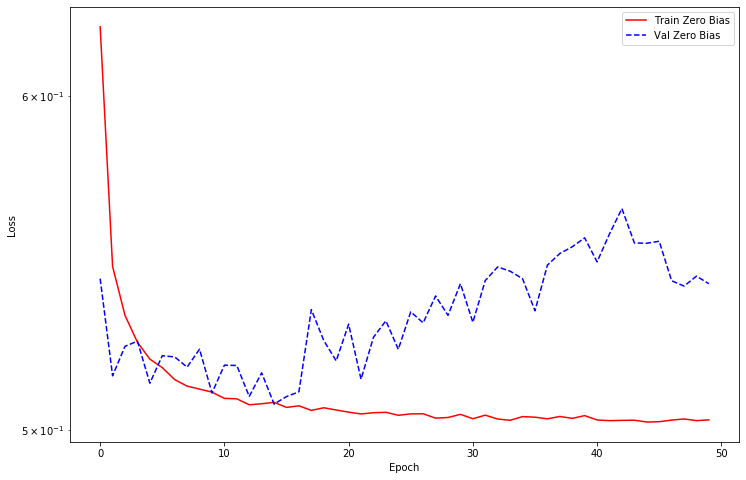

In [251]:
plot_loss(history, "Zero Bias", 0)

Legitimate Transactions Detected (True Negatives):  134957
Legitimate Transactions Incorrectly Detected (False Positives):  94036
Fraudulent Transactions Missed (False Negatives):  3122
Fraudulent Transactions Detected (True Positives):  19209
Total Fraudulent Transactions:  22331


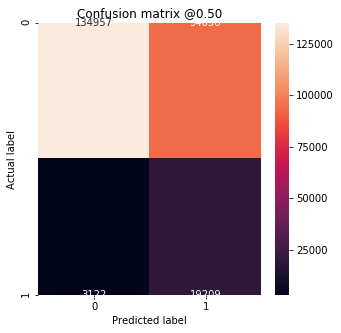

In [252]:
plot_cm(y_test, test_pred)

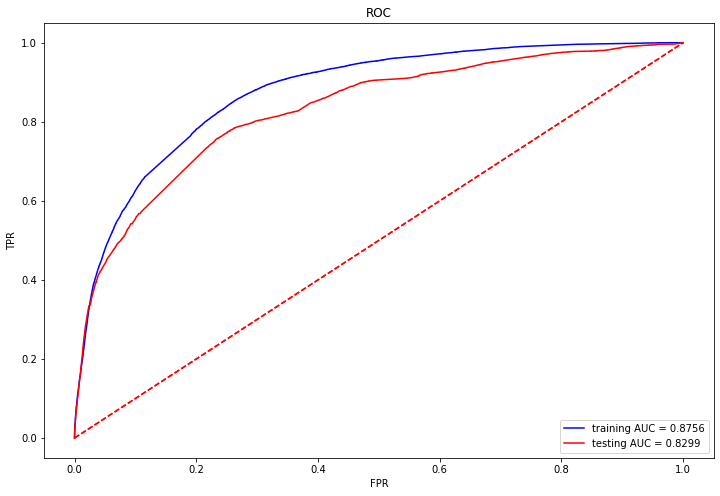

In [253]:
plt.figure(figsize=(12, 8))
plot_roc(y_train_up, train_pred, 'b', 'training AUC')
plot_roc(y_test, test_pred, 'r', 'testing AUC') # 

# Random Forest

In [58]:
features = train_label_1.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received','Date','label'], axis = 1)
feat_labels = features.columns
forest = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
#forest = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_ # feature importance ranking
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) day_gap_after                  0.083706
 2) day_of_month                   0.077482
 3) day_of_week                    0.052236
 4) this_month_user_receive_same_coupon_count 0.043326
 5) user_merchant_coupon_count     0.039954
 6) merchant_same_couponOut        0.039338
 7) Coupon_count                   0.036689
 8) merchant_uniqueUser            0.031477
 9) this_month_user_receive_all_coupon_count 0.030167
10) merchant_couponOut             0.030128
11) day_gap_before                 0.022545
12) user_coupon_total              0.022079
13) user_coupon_NOTuse             0.021859
14) user_coupon_type_count         0.019894
15) discount_rate                  0.019253
16) merchant_coupon_UseRate        0.018157
17) user_received_counts           0.017261
18) merchant_avg_distance          0.016052
19) discount_man                   0.015651
20) merchant_total_receive_times   0.015090
21) merchant_distinct_users        0.014889
22) user_merchant_count            0.014732
23) merchan

Text(0.5, 1.0, 'Variable Importance')

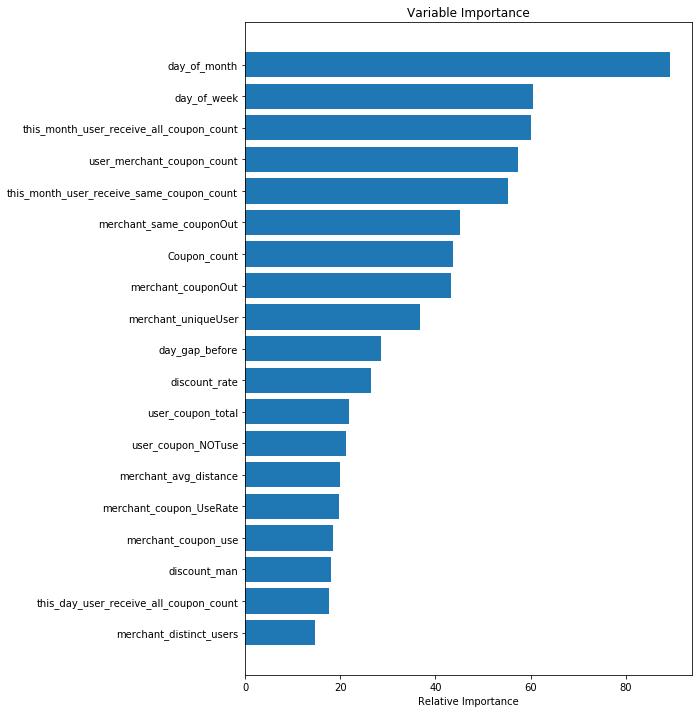

In [301]:
importances = 100.0 * (importances / importances.max())
sorted_idx_ = np.argsort(importances)
sorted_idx = sorted_idx_[-20:-1]
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = importances[sorted_idx] # calculate the importance of each feature
pcols = features.columns[sorted_idx] # feature name
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center') # bar
plt.yticks(pos, pcols) # feature name show on the left
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

# Bayesian optimization

In [275]:
def bayesian_optimization(dataset, function, parameters):
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 5
    gp_params = {"alpha": 1e-4}

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params)

    return BO.max

def rfc_optimization(cv_splits, X_train, y_train):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=0,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
    
    return function, parameters

In [276]:
def train_RF(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=0,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

In [277]:
function_rf, para_rf = rfc_optimization(10, X_train_up, y_train_up)
model_rf = train_RF(X_train_up, y_train_up, X_test, y_test, function_rf, para_rf)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8735   |  133.4    |  3.862    |  319.7    |
|  2        |  0.8796   |  61.12    |  6.592    |  151.4    |
|  3        |  0.8832   |  24.56    |  6.231    |  260.4    |
|  4        |  0.8707   |  68.29    |  2.179    |  474.2    |
|  5        |  0.8839   |  24.16    |  7.443    |  291.1    |
|  6        |  0.8612   |  5.115    |  7.547    |  998.7    |
|  7        |  0.8649   |  6.622    |  4.654    |  11.71    |
|  8        |  0.8702   |  145.7    |  7.624    |  11.39    |
|  9        |  0.8709   |  149.0    |  2.61     |  997.4    |
|  10       |  0.8742   |  146.8    |  9.869    |  11.75    |


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [302]:
y_rf_train = model_rf.predict(X_train)
y_rf_test = model_rf.predict(X_test)

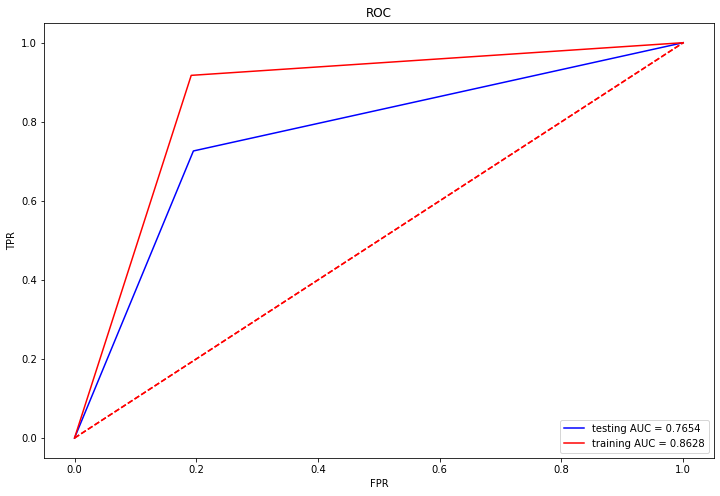

In [303]:
plt.figure(figsize=(12, 8))
plot_roc(y_test,y_rf_test, 'b', 'testing AUC')
plot_roc(y_train,y_rf_train, 'r', 'training AUC')

# XGboost

In [308]:
X_train = np.array(X_train)
y_train = np.array(y_train)
dtrain=xgb.DMatrix(X_train, label = y_train)
dtest=xgb.DMatrix(X_test)
from sklearn.preprocessing import MinMaxScaler

params_xgb={'booster':'gbtree', 
            'objective': 'rank:pairwise',
            'eval_metric': 'auc',
            'gamma':0.1,
            'max_depth':5,
            'lambda':10,
            'subsample':0.7,
            'colsample_bytree':0.7,
            'colsample_bylevel':0.7,
            'min_child_weight':1.1,
            'eta': 0.01,
            'tree_method':'exact',
            'seed':0,
            'nthread':12}

watchlist = [(dtrain,'train')]
model_xgb=xgb.train(params_xgb,dtrain,num_boost_round=40,evals=watchlist) 

#output auc
y_xgb_pred=model_xgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test,y_xgb_pred))

[0]	train-auc:0.83549
[1]	train-auc:0.86619
[2]	train-auc:0.86889
[3]	train-auc:0.86960
[4]	train-auc:0.87071
[5]	train-auc:0.87181
[6]	train-auc:0.87223
[7]	train-auc:0.87264
[8]	train-auc:0.87230
[9]	train-auc:0.87220
[10]	train-auc:0.87283
[11]	train-auc:0.87284
[12]	train-auc:0.87340
[13]	train-auc:0.87440
[14]	train-auc:0.87447
[15]	train-auc:0.87429
[16]	train-auc:0.87413
[17]	train-auc:0.87450
[18]	train-auc:0.87443
[19]	train-auc:0.87437
[20]	train-auc:0.87433
[21]	train-auc:0.87435
[22]	train-auc:0.87428
[23]	train-auc:0.87435
[24]	train-auc:0.87474
[25]	train-auc:0.87492
[26]	train-auc:0.87493
[27]	train-auc:0.87502
[28]	train-auc:0.87476
[29]	train-auc:0.87466
[30]	train-auc:0.87467
[31]	train-auc:0.87459
[32]	train-auc:0.87445
[33]	train-auc:0.87446
[34]	train-auc:0.87456
[35]	train-auc:0.87443
[36]	train-auc:0.87459
[37]	train-auc:0.87447
[38]	train-auc:0.87449
[39]	train-auc:0.87433
test AUC: 0.8373


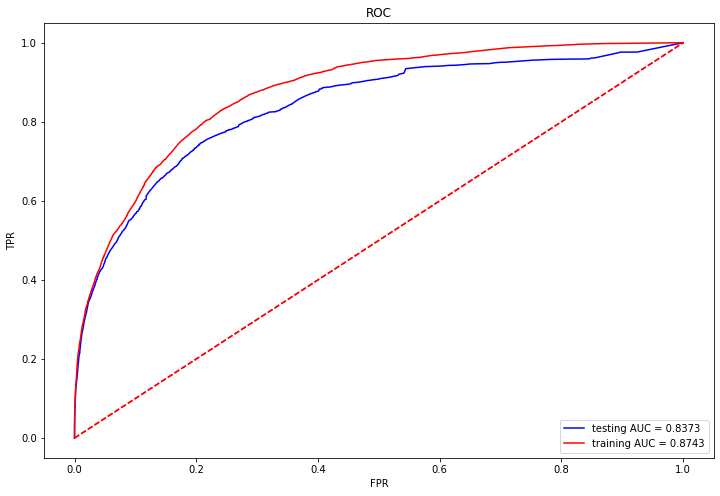

In [309]:
y_xgb_train=model_xgb.predict(dtrain)

plt.figure(figsize=(12, 8))
plot_roc(y_test,y_xgb_pred, 'b', 'testing AUC')
plot_roc(y_train,y_xgb_train, 'r', 'training AUC')

Legitimate Transactions Detected (True Negatives):  182949
Legitimate Transactions Incorrectly Detected (False Positives):  46044
Fraudulent Transactions Missed (False Negatives):  6113
Fraudulent Transactions Detected (True Positives):  16218
Total Fraudulent Transactions:  22331


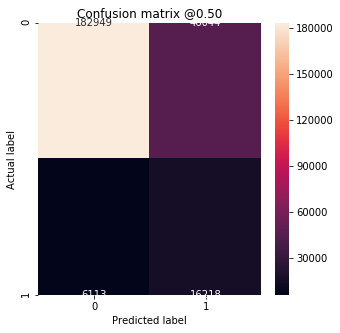

In [316]:
plot_cm(y_test, y_xgb_pred)

## upsampling

In [91]:
X_train_up = np.array(X_train_up)
y_train_up = np.array(y_train_up)

In [100]:
dtrain=xgb.DMatrix(X_train_up, label = y_train_up)
dtest=xgb.DMatrix(X_test)
from sklearn.preprocessing import MinMaxScaler

params_xgb={'booster':'gbtree', 
            'objective': 'rank:pairwise',
            'eval_metric': 'auc',
            'gamma':0.1,
            'max_depth':5,
            'lambda':10,
            'subsample':0.7,
            'colsample_bytree':0.7,
            'colsample_bylevel':0.7,
            'min_child_weight':1.1,
            'eta': 0.01,
            'tree_method':'exact',
            'seed':0,
            'nthread':12}

watchlist = [(dtrain,'train')]
model_xgb=xgb.train(params_xgb,dtrain,num_boost_round=40,evals=watchlist) 

#output auc
y_xgb_pred=model_xgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test,y_xgb_pred))

[0]	train-auc:0.83483
[1]	train-auc:0.85170
[2]	train-auc:0.85948
[3]	train-auc:0.86397
[4]	train-auc:0.86530
[5]	train-auc:0.86628
[6]	train-auc:0.86737
[7]	train-auc:0.86706
[8]	train-auc:0.86872
[9]	train-auc:0.86931
[10]	train-auc:0.86916
[11]	train-auc:0.86961
[12]	train-auc:0.87012
[13]	train-auc:0.87026
[14]	train-auc:0.87040
[15]	train-auc:0.87012
[16]	train-auc:0.86979
[17]	train-auc:0.87045
[18]	train-auc:0.87074
[19]	train-auc:0.87115
[20]	train-auc:0.87103
[21]	train-auc:0.87104
[22]	train-auc:0.87101
[23]	train-auc:0.87167
[24]	train-auc:0.87149
[25]	train-auc:0.87147
[26]	train-auc:0.87141
[27]	train-auc:0.87105
[28]	train-auc:0.87103
[29]	train-auc:0.87140
[30]	train-auc:0.87170
[31]	train-auc:0.87158
[32]	train-auc:0.87177
[33]	train-auc:0.87189
[34]	train-auc:0.87205
[35]	train-auc:0.87195
[36]	train-auc:0.87225
[37]	train-auc:0.87219
[38]	train-auc:0.87245
[39]	train-auc:0.87243
test AUC: 0.8349


In [131]:
y_xgb_train_up=model_xgb.predict(dtrain)

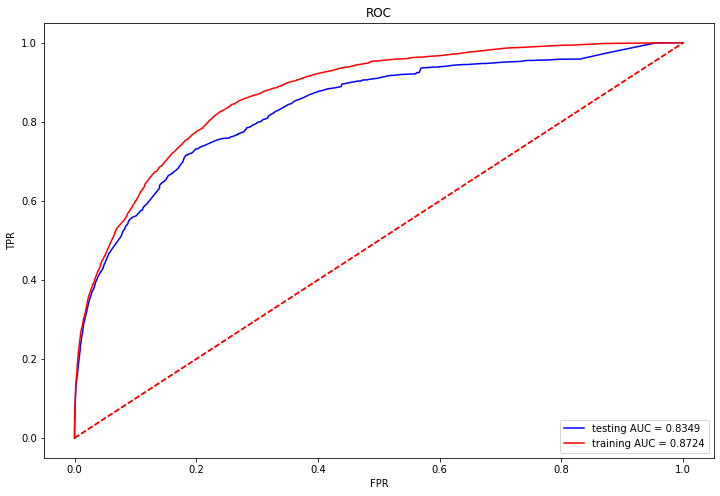

In [135]:
y_xgb_train_up=model_xgb.predict(dtrain)

plt.figure(figsize=(12, 8))
plot_roc(y_test,y_xgb_pred, 'b', 'testing AUC')
plot_roc(y_train_up,y_xgb_train_up, 'r', 'training AUC')

Legitimate Transactions Detected (True Negatives):  187258
Legitimate Transactions Incorrectly Detected (False Positives):  41735
Fraudulent Transactions Missed (False Negatives):  6393
Fraudulent Transactions Detected (True Positives):  15938
Total Fraudulent Transactions:  22331


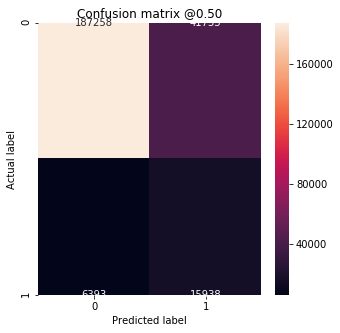

In [136]:
plot_cm(y_test, y_xgb_pred)

## downsampling

In [296]:
dtrain=xgb.DMatrix(X_train_down, label = y_train_down)
X_train_down = np.array(X_train_down)
y_train_down = np.array(y_train_down)

dtest=xgb.DMatrix(X_test)
from sklearn.preprocessing import MinMaxScaler

params_xgb={'booster':'gbtree', 
            'objective': 'rank:pairwise',
            'eval_metric': 'auc',
            'gamma':0.1,
            'max_depth':5,
            'lambda':10,
            'subsample':0.7,
            'colsample_bytree':0.7,
            'colsample_bylevel':0.7,
            'min_child_weight':1.1,
            'eta': 0.01,
            'tree_method':'exact',
            'seed':0,
            'nthread':12}

watchlist = [(dtrain,'train')]
model_xgb_down=xgb.train(params_xgb,dtrain,num_boost_round=40,evals=watchlist) 

#output auc
y_xgb_pred=model_xgb_down.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test,y_xgb_pred))

[0]	train-auc:0.83210
[1]	train-auc:0.86474
[2]	train-auc:0.86747
[3]	train-auc:0.86887
[4]	train-auc:0.86883
[5]	train-auc:0.86900
[6]	train-auc:0.87183
[7]	train-auc:0.87310
[8]	train-auc:0.87298
[9]	train-auc:0.87303
[10]	train-auc:0.87279
[11]	train-auc:0.87343
[12]	train-auc:0.87314
[13]	train-auc:0.87319
[14]	train-auc:0.87330
[15]	train-auc:0.87365
[16]	train-auc:0.87366
[17]	train-auc:0.87374
[18]	train-auc:0.87382
[19]	train-auc:0.87399
[20]	train-auc:0.87423
[21]	train-auc:0.87422
[22]	train-auc:0.87413
[23]	train-auc:0.87403
[24]	train-auc:0.87437
[25]	train-auc:0.87438
[26]	train-auc:0.87426
[27]	train-auc:0.87431
[28]	train-auc:0.87415
[29]	train-auc:0.87424
[30]	train-auc:0.87440
[31]	train-auc:0.87422
[32]	train-auc:0.87439
[33]	train-auc:0.87451
[34]	train-auc:0.87440
[35]	train-auc:0.87436
[36]	train-auc:0.87431
[37]	train-auc:0.87426
[38]	train-auc:0.87421
[39]	train-auc:0.87417
test AUC: 0.8345


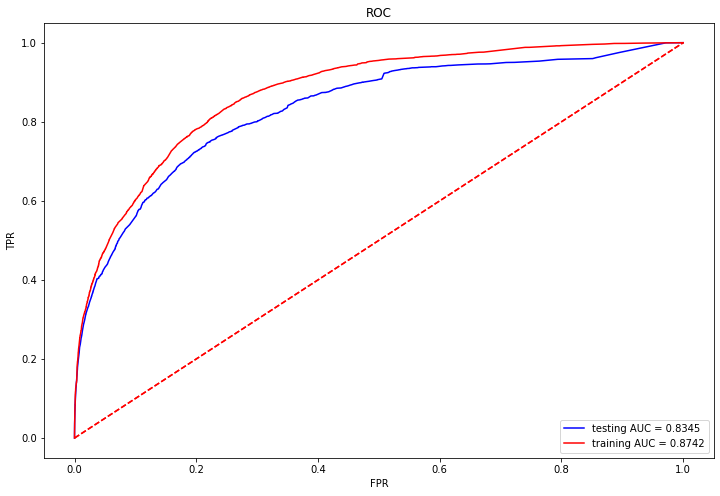

In [297]:
y_xgb_train_down=model_xgb_down.predict(dtrain)
plt.figure(figsize=(12, 8))
plot_roc(y_test,y_xgb_pred, 'b', 'testing AUC')
plot_roc(y_train_down, y_xgb_train_down, 'r', 'training AUC')

## SMOTE Algorithm

In [298]:
dtrain=xgb.DMatrix(X_train_SMOTE, label = y_train_SMOTE)
X_train_SMOTE = np.array(X_train_SMOTE)
y_train_SMOTE = np.array(y_train_SMOTE)

dtest=xgb.DMatrix(X_test)
from sklearn.preprocessing import MinMaxScaler

params_xgb={'booster':'gbtree', 
            'objective': 'rank:pairwise',
            'eval_metric': 'auc',
            'gamma':0.1,
            'max_depth':5,
            'lambda':10,
            'subsample':0.7,
            'colsample_bytree':0.7,
            'colsample_bylevel':0.7,
            'min_child_weight':1.1,
            'eta': 0.01,
            'tree_method':'exact',
            'seed':0,
            'nthread':12}

watchlist = [(dtrain,'train')]
model_xgb=xgb.train(params_xgb,dtrain,num_boost_round=40,evals=watchlist) 

#output auc
y_xgb_pred=model_xgb.predict(dtest)
print ('test AUC: %.4f' % metrics.roc_auc_score(y_test,y_xgb_pred))

[0]	train-auc:0.86437
[1]	train-auc:0.87844
[2]	train-auc:0.88810
[3]	train-auc:0.89215
[4]	train-auc:0.89180
[5]	train-auc:0.89280
[6]	train-auc:0.89488
[7]	train-auc:0.89504
[8]	train-auc:0.89585
[9]	train-auc:0.89534
[10]	train-auc:0.89517
[11]	train-auc:0.89551
[12]	train-auc:0.89703
[13]	train-auc:0.89677
[14]	train-auc:0.89679
[15]	train-auc:0.89642
[16]	train-auc:0.89623
[17]	train-auc:0.89698
[18]	train-auc:0.89718
[19]	train-auc:0.89791
[20]	train-auc:0.89794
[21]	train-auc:0.89781
[22]	train-auc:0.89767
[23]	train-auc:0.89841
[24]	train-auc:0.89829
[25]	train-auc:0.89816
[26]	train-auc:0.89834
[27]	train-auc:0.89799
[28]	train-auc:0.89782
[29]	train-auc:0.89800
[30]	train-auc:0.89846
[31]	train-auc:0.89823
[32]	train-auc:0.89836
[33]	train-auc:0.89843
[34]	train-auc:0.89850
[35]	train-auc:0.89847
[36]	train-auc:0.89873
[37]	train-auc:0.89853
[38]	train-auc:0.89866
[39]	train-auc:0.89856
test AUC: 0.6124


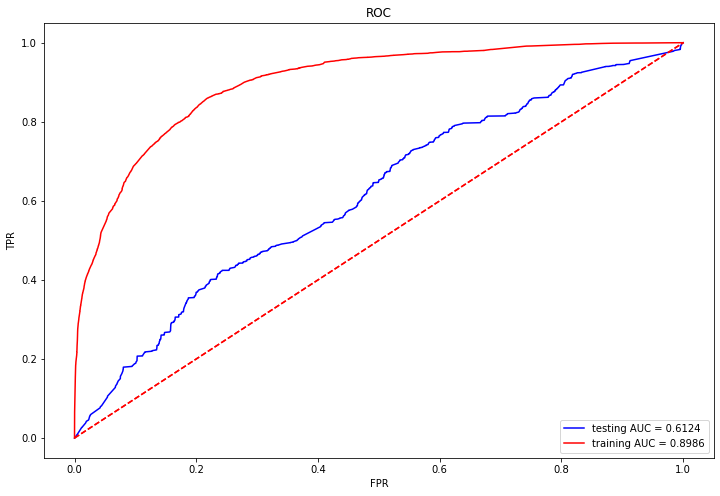

In [299]:
y_xgb_train_SMOTE=model_xgb.predict(dtrain)

plt.figure(figsize=(12, 8))
plot_roc(y_test,y_xgb_pred, 'b', 'testing AUC')
plot_roc(y_train_SMOTE,y_xgb_train_SMOTE, 'r', 'training AUC')

In [127]:
result = X_predict.drop(['User_id','Merchant_id','Coupon_id','Discount_rate','Distance','Date_received'], axis = 1)
result1 = scaler.fit_transform(result)
#X_re = np.array(result)
#X_re = scaler.fit_transform(X_re)
result1 = xgb.DMatrix(result1)
prob = model_xgb.predict(result1)
result = X_predict[['User_id','Coupon_id','Date_received']]
result['prob'] = prob
result['Date_received'] = result.Date_received.astype('str').apply(lambda x:x.replace('-', ''))
result.to_csv('result_xgb_upsample.csv', index = None, header = None)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [61]:
# Supervised transformation based on xgboost
xgb1 = xgb.XGBClassifier(nthread=12,     #nthread=-1 uses all CPUs for parallel computation (default), nthread=1 uses 1 CPU for computation.
                          learning_rate=0.08,    #Learning rate, controls the step size when updating weights in each iteration, default is 0.3, the smaller the value, the slower the training. Typical values are 0.01-0.2.
                          n_estimators=50,       #The total number of iterations, also the number of decision trees.
                          max_depth=5,           #The depth of the tree, default is 6, typical values are 3-10, larger values tend to overfit, smaller values tend to underfit.
                          gamma=0.1,               #Regularization coefficient, specifies the minimum loss reduction required to make a split.
                          subsample=0.7,       #The proportion of the training set used to train each tree. Default is 1, typical values are 0.5-1. Be careful of overfitting.
                          colsample_bytree=0.7) #The proportion of features used to train each tree. Default is 1, typical values are 0.5-1. Be careful of overfitting.
 
xgb_enc = OneHotEncoder()
xgb_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
 
xgb1.fit(X_grd, y_grd)
xgb_enc.fit(xgb1.apply(X_grd))
xgb_lm.fit(xgb_enc.transform(xgb1.apply(X_lr)), y_lr)
 
y_pred_xgb_lm = xgb_lm.predict_proba(
    xgb_enc.transform(xgb1.apply(X_test)))[:, 1]
fpr_xgb_lm, tpr_xgb_lm, _ = roc_curve(y_test, y_pred_xgb_lm)
print("xgboost+LR的AUC为：", roc_auc_score(y_test, y_pred_xgb_lm))

xgboost+LR的AUC为： 0.7113479191954284


# RandomForest & XGBoost Stacking

In [254]:
def xgb_model(X_train, y_train, X_test, y_test=None):
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eval_metric' : 'auc',
              'eta': 0.01,
              'max_depth': 5,
              'colsample_bytree': 0.7,
              'subsample': 0.7,
              'min_child_weight': 1,
              'seed': 1,
              'silent':1
              }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=300)
    predict = model.predict(dtest)

    return predict

def rf_model(X_train, y_train, X_test, y_test=None):
    rf = RandomForestClassifier(n_estimators = 10, max_depth = 8, min_samples_split = 9, n_jobs = -1, random_state = 0)
    model = rf.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    return predict

In [256]:
# create dataset
dataset = Dataset(X_train_up,y_train_up,X_test)

# initialize RandomForest & LinearRegression
model_rf = Classifier(dataset=dataset, estimator=rf_model,name='rf')
model_xgb = Classifier(dataset=dataset, estimator=xgb_model,name='xgb')

# Stack two models
pipeline = ModelsPipeline(model_rf,model_xgb)
stack_ds = pipeline.stack(k=10,seed=111, full_test=True)

# Use logistic regression for the second layer
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, parameters={'fit_intercept': True})

results_stacking = stacker.predict()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

ValueError: feature_names mismatch: ['coupon_show_times', 'use_times', 'his_use_rate', 'receiv_use_interval', 'user_getCoupon_times', 'user_useCoupon_times', 'user_ReceivUse_rate', 'day_of_week', 'day_of_month', 'discount_man', 'discount_jian', 'is_man_jian', 'discount_rate', 'Coupon_count', 'merchant_total_receive_times', 'merchant_coupon_NOTuse', 'merchant_coupon_use', 'merchant_coupon_UseRate', 'merchant_avg_Discount_rate', 'merchant_min_Discount_rate', 'merchant_max_Discount_rate', 'merchant_min_distance', 'merchant_max_distance', 'merchant_avg_distance', 'merchant_distinct_users', 'merchant_distinct_coupon_numbers', 'user_coupon_total', 'user_coupon_NOTuse', 'user_coupon_use_x', 'user_coupon_UseRate', 'user_coupon_less50_rate', 'user_coupon50_UseRate', 'user_coupon_less200_rate', 'user_coupon200_UseRate', 'user_coupon_less500_rate', 'user_coupon500_UseRate', 'user_meanrate_use', 'user_minrate_use', 'user_maxrate_use', 'user_meandistance_use', 'user_mindistance_use', 'user_maxdistance_use', 'user_merchant_use', 'user_merchant_rate', 'user_coupon_use_y', 'user_coupon_rate', 'user_merchant_coupon_average', 'user_offline_none_consume', 'user_offline_coupon_consume', 'user_received_counts', 'user_online_action_counts', 'user_online_action_0_rate', 'user_online_action_1_rate', 'user_online_action_2_rate', 'user_online_none_consume_counts', 'user_online_received_counts', 'user_online_coupon_consume_counts', 'user_online_coupon_consume_rate', 'user_offline_none_consume_rate', 'user_offline_coupon_consume_rate', 'user_offline_rate', 'user_merchant_coupon_total', 'user_merchant_coupon_NOTuse', 'user_merchant_coupon_use', 'user_merchant_coupon_UseRate', 'user_merchant_NotUse_NotUseTotal_Rate', 'user_merchant_Use_UseTotal_Rate', 'user_merchant_NotUse_MerchantNotUseTotal_Rate', 'user_merchant_Use_MerchantUseTotal_Rate', 'this_month_user_receive_same_coupon_count', 'this_month_user_receive_all_coupon_count', 'this_day_user_receive_all_coupon_count', 'this_day_user_receive_same_coupon_count', 'day_gap_before', 'day_gap_after', 'user_merchant_coupon_count', 'user_merchant_count', 'user_coupon_type_count', 'merchant_couponOut', 'merchant_same_couponOut', 'merchant_uniqueUser', 'merchant_uniqueCoupon'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81']
expected merchant_avg_Discount_rate, user_online_coupon_consume_rate, user_getCoupon_times, user_offline_coupon_consume, user_coupon_use_y, user_coupon_use_x, user_online_none_consume_counts, user_coupon500_UseRate, user_coupon_less200_rate, user_coupon_rate, user_coupon_less500_rate, user_coupon_total, merchant_couponOut, user_merchant_coupon_average, merchant_avg_distance, this_day_user_receive_same_coupon_count, use_times, day_gap_after, merchant_max_Discount_rate, merchant_distinct_coupon_numbers, user_received_counts, user_merchant_coupon_NOTuse, user_minrate_use, is_man_jian, day_of_week, merchant_min_distance, user_offline_none_consume, user_online_action_1_rate, discount_rate, user_online_action_2_rate, user_coupon50_UseRate, user_coupon_less50_rate, user_ReceivUse_rate, user_offline_none_consume_rate, user_merchant_coupon_UseRate, user_coupon200_UseRate, user_merchant_NotUse_MerchantNotUseTotal_Rate, merchant_coupon_use, user_offline_coupon_consume_rate, this_month_user_receive_same_coupon_count, Coupon_count, merchant_coupon_UseRate, discount_jian, merchant_min_Discount_rate, day_gap_before, user_merchant_coupon_count, user_merchant_use, this_day_user_receive_all_coupon_count, merchant_coupon_NOTuse, merchant_uniqueCoupon, coupon_show_times, receiv_use_interval, user_maxdistance_use, user_merchant_coupon_use, user_merchant_Use_UseTotal_Rate, user_coupon_UseRate, merchant_max_distance, user_mindistance_use, user_merchant_NotUse_NotUseTotal_Rate, user_offline_rate, his_use_rate, user_useCoupon_times, discount_man, user_coupon_NOTuse, merchant_distinct_users, user_online_action_counts, user_online_received_counts, merchant_total_receive_times, user_coupon_type_count, user_merchant_coupon_total, user_merchant_rate, this_month_user_receive_all_coupon_count, user_online_coupon_consume_counts, user_meandistance_use, merchant_same_couponOut, user_merchant_Use_MerchantUseTotal_Rate, user_merchant_count, day_of_month, user_meanrate_use, user_maxrate_use, merchant_uniqueUser, user_online_action_0_rate in input data
training data did not have the following fields: f40, f68, f21, f69, f32, f60, f57, f78, f66, f64, f49, f0, f34, f7, f2, f59, f3, f77, f10, f53, f47, f73, f19, f24, f36, f70, f50, f41, f16, f12, f8, f58, f23, f11, f62, f17, f18, f80, f33, f26, f13, f5, f9, f52, f63, f71, f74, f42, f48, f55, f35, f15, f54, f4, f61, f67, f75, f1, f43, f45, f46, f31, f65, f27, f38, f14, f28, f29, f30, f79, f51, f6, f44, f20, f37, f76, f81, f25, f56, f39, f72, f22